# Step 1: Enhanced PDF Processing with Image Extraction

In [1]:
rm -rf /kaggle/working/extracted_scans*

In [2]:
# Clean installation with compatible versions
!pip uninstall -y tensorflow scikit-learn scipy numpy -qq
!pip install tensorflow==2.13.0 scikit-learn==1.3.0 scipy==1.10.1 numpy==1.24.3 pymupdf opencv-python pandas matplotlib imbalanced-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 105.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 53.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 88.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 79.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 27.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 92.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB

In [3]:
# Install required packages
!pip install PyMuPDF opencv-python tensorflow scikit-learn imbalanced-learn pandas numpy matplotlib Pillow

# If the above doesn't work for fitz, try:
!pip install pymupdf

# Simplified and Robust Pipeline

In [4]:
import os
import re
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Try imports with error handling
try:
    import pymupdf as fitz
    print("✅ PyMuPDF imported successfully")
except ImportError:
    print("❌ PyMuPDF not available")

try:
    import tensorflow as tf
    from tensorflow.keras import layers, models
    print("✅ TensorFlow imported successfully")
except ImportError as e:
    print(f"❌ TensorFlow import error: {e}")

try:
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight
    from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
    print("✅ scikit-learn imported successfully")
except ImportError as e:
    print(f"❌ scikit-learn import error: {e}")

# Configuration
INPUT_FOLDER = "/kaggle/input/pancreas-dataset-from-fibroscan"
BASE_OUTPUT_FOLDER = "/kaggle/working/extracted_scans"
CAP_CSV_PATH = "/kaggle/working/cap_values.csv"

# Create directories
os.makedirs(BASE_OUTPUT_FOLDER, exist_ok=True)

print("🚀 Starting Pancreatic Steatosis Classification Pipeline")
print("=" * 60)

✅ PyMuPDF imported successfully
✅ TensorFlow imported successfully
✅ scikit-learn imported successfully
🚀 Starting Pancreatic Steatosis Classification Pipeline


# Step 1: CAP Value Extraction (Simplified)

In [5]:
import fitz
import re
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
from PIL import Image
import io

print("✅ All imports successful!")

# Configuration
INPUT_FOLDER = "/kaggle/input/pancreas-dataset-from-fibroscan"
BASE_OUTPUT_FOLDER = "/kaggle/working/extracted_scans"
CAP_CSV_PATH = "/kaggle/working/cap_values.csv"
MODEL_SAVE_PATH = "/kaggle/working/pancreas_steatosis_model.h5"

# Create directories
os.makedirs(BASE_OUTPUT_FOLDER, exist_ok=True)

# ==================== CAP EXTRACTION FUNCTIONS ====================

def extract_cap_comprehensive(pdf_path):
    """Comprehensive CAP extraction from FibroScan PDF"""
    try:
        with fitz.open(pdf_path) as doc:
            full_text = ""
            for page in doc:
                full_text += page.get_text() + "\n"
            
            lines = [line.strip() for line in full_text.split('\n') if line.strip()]
            
            # Look for CAP patterns
            cap_patterns = [
                r'CAP\s*[:\-\s]*(\d{2,3})\s*db/m',
                r'CAP\s*\(db/m\)\s*(\d{2,3})',
                r'CAP.*?(\d{2,3})\s*db/m',
                r'(\d{2,3})\s*db/m.*CAP',
            ]
            
            for pattern in cap_patterns:
                matches = re.finditer(pattern, full_text, re.IGNORECASE)
                for match in matches:
                    cap_value = int(match.group(1))
                    if 100 <= cap_value <= 500:
                        return cap_value
            
            # Fallback: look for numbers near CAP text
            for i, line in enumerate(lines):
                if 'CAP' in line.upper():
                    # Check current line
                    numbers = re.findall(r'\b(\d{2,3})\b', line)
                    for num in numbers:
                        cap_val = int(num)
                        if 150 <= cap_val <= 350:
                            return cap_val
                    
                    # Check nearby lines
                    for offset in [-2, -1, 1, 2]:
                        check_idx = i + offset
                        if 0 <= check_idx < len(lines):
                            nearby_line = lines[check_idx]
                            nearby_numbers = re.findall(r'\b(\d{2,3})\b', nearby_line)
                            for num in nearby_numbers:
                                cap_val = int(num)
                                if 150 <= cap_val <= 350:
                                    return cap_val
            
            return None
    except Exception as e:
        print(f"Error extracting CAP from {pdf_path}: {e}")
        return None

def batch_extract_cap_values(input_folder, output_csv):
    """Extract CAP values from all PDFs"""
    pdf_files = [f for f in os.listdir(input_folder) if f.endswith('.pdf')]
    
    if not pdf_files:
        print("❌ No PDF files found")
        return None
    
    print(f"📊 Found {len(pdf_files)} PDF files")
    
    results = []
    for pdf_file in pdf_files:
        pdf_path = os.path.join(input_folder, pdf_file)
        patient_id = os.path.splitext(pdf_file)[0]
        
        cap_value = extract_cap_comprehensive(pdf_path)
        status = "✅ Success" if cap_value else "❌ Not found"
        
        results.append({
            'Patient_ID': patient_id,
            'Filename': pdf_file,
            'CAP_dB_m': cap_value,
            'Status': status
        })
        
        print(f"  {pdf_file}: {cap_value} dB/m")
    
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    
    success_count = df[df['CAP_dB_m'].notna()].shape[0]
    print(f"\n✅ Extraction complete: {success_count}/{len(pdf_files)} successful")
    
    return df

# ==================== PANCREATIC CLASSIFICATION FUNCTION ====================

def cap_to_pancreas_grade_fixed(cap_value):
    """Convert CAP value to pancreatic steatosis grade using YOUR exact ranges"""
    if cap_value is None or pd.isna(cap_value):
        return -1
    if cap_value <= 240:                    # S0 (No steatosis): CAP < 240 or equal 240 dB/m
        return 0  # S0
    elif 241 <= cap_value <= 264:          # S1 (Mild): 241 ≤ CAP ≤ 264 dB/m
        return 1  # S1
    elif 265 <= cap_value <= 276:          # S2 (Moderate): 265 ≤ CAP ≤ 276 dB/m
        return 2  # S2
    elif 277 <= cap_value <= 330:          # S3 (Severe): 277 ≤ CAP ≤ 330 dB/m
        return 3  # S3
    elif cap_value >= 331:                 # FIXED: S3 (Severe): CAP > 330 dB/m (includes 331-335)
        return 3  # S3
    else:
        return -1

# ==================== IMAGE EXTRACTION WITH UNIQUE NAMES ====================

def extract_scan_images_improved(pdf_path, output_folder):
    """Extract scan images from PDF with unique names and QR code filtering"""
    os.makedirs(output_folder, exist_ok=True)
    extracted_count = 0
    
    try:
        with fitz.open(pdf_path) as doc:
            # Get patient ID from filename for naming
            patient_id = os.path.splitext(os.path.basename(pdf_path))[0]
            
            for page_num in range(len(doc)):
                image_list = doc[page_num].get_images()
                
                for img_index, img in enumerate(image_list):
                    xref = img[0]
                    pix = fitz.Pixmap(doc, xref)
                    
                    # Skip if image is too small (likely icons)
                    if pix.width < 200 or pix.height < 200:
                        pix = None
                        continue
                    
                    # Convert to PIL Image for better analysis
                    img_data = pix.tobytes("png")
                    pil_img = Image.open(io.BytesIO(img_data))
                    
                    # Skip QR codes and barcodes based on multiple criteria
                    width, height = pil_img.size
                    aspect_ratio = width / height
                    
                    # Skip QR codes (usually square and small)
                    is_qr_like = 0.8 <= aspect_ratio <= 1.2 and (width < 300 or height < 300)
                    
                    # Skip barcodes (very wide or very tall)
                    is_barcode = aspect_ratio > 4.0 or aspect_ratio < 0.25
                    
                    if is_qr_like or is_barcode:
                        pix = None
                        continue
                    
                    # Create unique filename
                    from datetime import datetime
                    timestamp = datetime.now().strftime("%H%M%S")
                    
                    unique_filename = f"{patient_id}_p{page_num+1:02d}_{timestamp}_scan_{extracted_count+1:03d}.png"
                    output_path = os.path.join(output_folder, unique_filename)
                    
                    # Save the image
                    pix.save(output_path)
                    extracted_count += 1
                    
                    pix = None
                    
    except Exception as e:
        print(f"Error extracting images from {pdf_path}: {e}")
    
    return extracted_count

def process_all_pdfs_improved(input_folder, output_folder):
    """Process all PDFs with improved image extraction"""
    pdf_files = [f for f in os.listdir(input_folder) if f.lower().endswith('.pdf')]
    
    print(f"\n🖼️ Extracting scan images from {len(pdf_files)} PDFs...")
    
    total_extracted = 0
    for pdf_file in pdf_files:
        pdf_path = os.path.join(input_folder, pdf_file)
        patient_id = os.path.splitext(pdf_file)[0]
        patient_folder = os.path.join(output_folder, patient_id)
        
        extracted = extract_scan_images_improved(pdf_path, patient_folder)
        total_extracted += extracted
        
        if extracted > 0:
            print(f"  ✅ {pdf_file}: {extracted} scans")
    
    print(f"\n🎯 Total scan images extracted: {total_extracted}")
    return total_extracted

# ==================== DEEP LEARNING PIPELINE ====================

def extract_a_mode_signal_from_image(image_path):
    """Extract A-mode signal from scan image"""
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        
        # Enhanced signal extraction
        signal = []
        for col in range(img.shape[1]):
            column = img[:, col]
            # Find the darkest point (signal line)
            if np.min(column) < 128:
                signal_point = np.argmin(column)
                normalized = 1.0 - (signal_point / img.shape[0])
                signal.append(normalized)
            else:
                signal.append(0.0)
        
        return np.array(signal)
    except Exception as e:
        return None

def preprocess_signals(signals, target_length=256):
    """Preprocess signals to consistent length"""
    processed = []
    for signal in signals:
        if signal is None or len(signal) == 0:
            continue
            
        # Interpolate to target length
        if len(signal) != target_length:
            x_old = np.linspace(0, 1, len(signal))
            x_new = np.linspace(0, 1, target_length)
            signal_interp = np.interp(x_new, x_old, signal)
        else:
            signal_interp = signal
        
        # Normalize
        if np.max(signal_interp) > 0:
            signal_interp = (signal_interp - np.min(signal_interp)) / (np.max(signal_interp) - np.min(signal_interp))
        
        processed.append(signal_interp)
    
    return np.array(processed)

def create_advanced_pancreas_model(input_length):
    """Create 1D CNN model for pancreatic steatosis classification"""
    model = models.Sequential([
        layers.Conv1D(64, 5, activation='relu', input_shape=(input_length, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.2),
        
        layers.Conv1D(128, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),
        
        layers.Conv1D(256, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.4),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(4, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def prepare_training_data(cap_df, scans_folder):
    """Prepare training data from CAP values and scan images"""
    print("\n🔬 Preparing training data...")
    
    X_data = []
    y_data = []
    patient_ids = []
    
    # Add pancreatic grades to dataframe
    cap_df['Steatosis_Grade'] = cap_df['CAP_dB_m'].apply(cap_to_pancreas_grade_fixed)
    valid_patients = cap_df[cap_df['Steatosis_Grade'] != -1].copy()
    
    print(f"Processing {len(valid_patients)} patients with valid grades...")
    
    for _, patient in valid_patients.iterrows():
        patient_id = patient['Patient_ID']
        patient_folder = os.path.join(scans_folder, patient_id)
        
        if not os.path.exists(patient_folder):
            continue
            
        scan_files = [f for f in os.listdir(patient_folder) if f.endswith('.png')]
        
        patient_signals = []
        for scan_file in scan_files:
            scan_path = os.path.join(patient_folder, scan_file)
            signal = extract_a_mode_signal_from_image(scan_path)
            
            if signal is not None and len(signal) > 100:
                patient_signals.append(signal)
        
        if patient_signals:
            X_data.extend(patient_signals)
            y_data.extend([patient['Steatosis_Grade']] * len(patient_signals))
            patient_ids.extend([patient_id] * len(patient_signals))
            
            grade_name = ['S0', 'S1', 'S2', 'S3'][patient['Steatosis_Grade']]
            print(f"  ✅ {patient_id}: {len(patient_signals)} scans, Grade: {grade_name}")
    
    if len(X_data) == 0:
        print("❌ No training data prepared")
        return None, None, None
    
    # Preprocess signals
    X_processed = preprocess_signals(X_data)
    
    print(f"\n✅ Training data prepared:")
    print(f"   Total signals: {len(X_processed)}")
    print(f"   Signal length: {X_processed.shape[1]}")
    print(f"   Unique patients: {len(set(patient_ids))}")
    print(f"   Class distribution: {np.unique(y_data, return_counts=True)}")
    
    return X_processed, np.array(y_data), patient_ids

def train_pancreas_model(X, y, patient_ids):
    """Train the pancreatic steatosis classification model"""
    if X is None or y is None:
        print("❌ No data for training")
        return None, None
    
    print("\n🧠 Training pancreatic steatosis model...")
    
    # Reshape for CNN
    X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    
    print(f"📊 Data splits:")
    print(f"   Train: {X_train.shape[0]} signals")
    print(f"   Validation: {X_val.shape[0]} signals") 
    print(f"   Test: {X_test.shape[0]} signals")
    
    # Create model
    model = create_advanced_pancreas_model(X_train.shape[1])
    
    print("Model architecture:")
    model.summary()
    
    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5)
    ]
    
    # Train model
    print("🎯 Starting training...")
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"✅ Test accuracy: {test_acc:.4f}")
    
    # Predictions
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=['S0', 'S1', 'S2', 'S3']))
    
    kappa = cohen_kappa_score(y_test, y_pred_classes, weights='quadratic')
    print(f"📊 Quadratic Weighted Kappa: {kappa:.3f}")
    
    return model, history

# ==================== MAIN EXECUTION ====================

print("🚀 STARTING COMPLETE PANCREATIC STEATOSIS PIPELINE")
print("=" * 60)

# Step 1: Extract CAP values
print("\n📊 STEP 1: Extracting CAP values from PDFs...")
cap_df = batch_extract_cap_values(INPUT_FOLDER, CAP_CSV_PATH)

if cap_df is not None:
    # Step 2: Extract scan images
    print("\n🖼️ STEP 2: Extracting scan images with unique names...")
    total_scans = process_all_pdfs_improved(INPUT_FOLDER, BASE_OUTPUT_FOLDER)
    
    # Step 3: Prepare and train model
    print("\n🔬 STEP 3: Preparing training data...")
    X, y, patient_ids = prepare_training_data(cap_df, BASE_OUTPUT_FOLDER)
    
    if X is not None and y is not None:
        print("\n🧠 STEP 4: Training model...")
        model, history = train_pancreas_model(X, y, patient_ids)
        
        if model is not None:
            # Save model
            model.save(MODEL_SAVE_PATH)
            print(f"✅ Model saved to: {MODEL_SAVE_PATH}")
            
            # Plot training history
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(history.history['accuracy'], label='Training Accuracy')
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
            plt.title('Model Accuracy')
            plt.legend()
            
            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title('Model Loss')
            plt.legend()
            
            plt.tight_layout()
            plt.savefig('/kaggle/working/training_history.png')
            plt.show()
            
            print("\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
        else:
            print("❌ Model training failed")
    else:
        print("❌ No data for training")
else:
    print("❌ CAP extraction failed")

print(f"\n📊 FINAL SUMMARY:")
print(f"   CAP values extracted: {len(cap_df) if cap_df is not None else 0}")
print(f"   Scan images: {total_scans if 'total_scans' in locals() else 0}")
print(f"   Model trained: {'✅ Yes' if 'model' in locals() and model is not None else '❌ No'}")

✅ All imports successful!
🚀 STARTING COMPLETE PANCREATIC STEATOSIS PIPELINE

📊 STEP 1: Extracting CAP values from PDFs...
📊 Found 108 PDF files
  GF82276_20240826_10-20-14.pdf: 260 dB/m
  GF82276_20240520_10-22-35.pdf: 302 dB/m
  GF82276_20240731_09-35-59.pdf: 323 dB/m
  GF82276_20240514_10-06-26.pdf: 309 dB/m
  GF82276_20240721_07-26-32.pdf: 279 dB/m
  GF82276_20240807_08-19-23.pdf: 243 dB/m
  GF82276_20250120_10-59-46.pdf: 270 dB/m
  GF82276_20240804_10-27-56.pdf: 200 dB/m
  GF82276_20240804_08-48-59.pdf: 229 dB/m
  GF82276_20240527_07-50-10.pdf: 318 dB/m
  GF82276_20240805_09-43-35.pdf: 203 dB/m
  GF82276_20241119_08-54-00.pdf: 274 dB/m
  GF82276_20241014_08-55-07.pdf: 272 dB/m
  GF82276_20240527_10-11-59.pdf: None dB/m
  GF82276_20240804_10-15-35.pdf: 295 dB/m
  GF82276_20240527_10-31-28.pdf: 229 dB/m
  GF82276_20240721_09-18-45.pdf: 242 dB/m
  GF82276_20240724_10-06-22.pdf: 295 dB/m
  GF82276_20250223_08-31-53.pdf: 189 dB/m
  GF82276_20250928_07-59-37.pdf: 256 dB/m
  GF82276_20240

# #################

# Extract scans from patients pdfs but still has one qr code png file in each patient folder and categorize patients pdfs into S0,S1,S2,S3

In [6]:
import fitz
import os
import pandas as pd
import numpy as np
from PIL import Image
import shutil
import cv2
import io
from skimage import filters
import re

print("✅ All imports successful!")

# Configuration
INPUT_FOLDER = "/kaggle/input/pancreas-dataset-from-fibroscan"
BASE_OUTPUT_FOLDER = "/kaggle/working/extracted_scans"
CAP_CSV_PATH = "/kaggle/input/cap-values/cap_values.csv"

# Create directories
os.makedirs(BASE_OUTPUT_FOLDER, exist_ok=True)

# ==================== CAP VALUE TO STEATOSIS GRADE MAPPING ====================

def cap_to_steatosis_grade(cap_value):
    """Convert CAP value to pancreatic steatosis grade using your exact ranges"""
    if cap_value <= 240:                    # S0 (No steatosis): CAP < 240 or equal 240 dB/m
        return 'S0'
    elif 241 <= cap_value <= 264:          # S1 (Mild): 241 ≤ CAP ≤ 264 dB/m
        return 'S1'
    elif 265 <= cap_value <= 276:          # S2 (Moderate): 265 ≤ CAP ≤ 276 dB/m
        return 'S2'
    elif 277 <= cap_value <= 336:          # S3 (Severe): CAP ≥ 277 dB/m
        return 'S3'
    else:
        return 'S3'

# ==================== ENHANCED QR CODE AND BLANK DETECTION ====================

def is_qr_code_enhanced(pix):
    """Enhanced QR code detection using multiple criteria"""
    try:
        width, height = pix.width, pix.height
        
        # QR codes are typically square and small
        aspect_ratio = width / height
        is_square = 0.95 <= aspect_ratio <= 1.05  # Very strict square check
        
        # QR codes are usually small
        is_small = width <= 200 and height <= 200
        
        # Convert to PIL for pattern analysis
        img_data = pix.tobytes("png")
        pil_img = Image.open(io.BytesIO(img_data))
        img_array = np.array(pil_img)
        
        if len(img_array.shape) == 3:
            img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        else:
            img_gray = img_array
        
        # QR codes have very high contrast and specific patterns
        contrast = np.std(img_gray)
        
        # Check for QR code pattern: high contrast in small square
        is_high_contrast_square = is_square and is_small and contrast > 80
        
        # Check for three distinctive squares in corners (QR code pattern)
        # This is a simplified check - look for high contrast areas in corners
        if is_square and is_small:
            h, w = img_gray.shape
            corner_size = min(h, w) // 4
            
            # Check corners for high contrast patterns
            top_left = img_gray[:corner_size, :corner_size]
            top_right = img_gray[:corner_size, -corner_size:]
            bottom_left = img_gray[-corner_size:, :corner_size]
            
            corner_contrasts = [
                np.std(top_left),
                np.std(top_right), 
                np.std(bottom_left)
            ]
            
            # QR codes typically have high contrast in at least 2 corners
            high_contrast_corners = sum(c > 50 for c in corner_contrasts) >= 2
            is_qr_pattern = high_contrast_corners and contrast > 60
            
            return is_high_contrast_square or is_qr_pattern
        
        return False
        
    except Exception as e:
        return False

def is_barcode(pix):
    """Detect barcode patterns"""
    try:
        width, height = pix.width, pix.height
        
        # Barcodes are very rectangular
        aspect_ratio = width / height
        is_very_wide = aspect_ratio > 6.0
        is_very_tall = aspect_ratio < 0.166
        
        if is_very_wide or is_very_tall:
            # Convert to grayscale for pattern analysis
            img_data = pix.tobytes("png")
            pil_img = Image.open(io.BytesIO(img_data))
            img_array = np.array(pil_img)
            
            if len(img_array.shape) == 3:
                img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
            else:
                img_gray = img_array
            
            # Barcodes have alternating black and white stripes
            # Check for high frequency vertical/horizontal patterns
            if is_very_wide:
                # Horizontal barcode - check for vertical stripes
                column_vars = np.std(img_gray, axis=0)
            else:
                # Vertical barcode - check for horizontal stripes  
                column_vars = np.std(img_gray, axis=1)
            
            # Barcodes have many high-variance columns (stripes)
            high_var_columns = sum(v > 50 for v in column_vars)
            total_columns = len(column_vars)
            
            return high_var_columns > total_columns * 0.3  # Many stripes
        
        return False
        
    except Exception as e:
        return False

def is_blank_or_icon(pix):
    """Detect blank images or small icons"""
    try:
        width, height = pix.width, pix.height
        
        # Very small images are likely icons
        if width < 100 or height < 100:
            return True
            
        # Convert for analysis
        img_data = pix.tobytes("png")
        pil_img = Image.open(io.BytesIO(img_data))
        img_array = np.array(pil_img)
        
        if len(img_array.shape) == 3:
            img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        else:
            img_gray = img_array
        
        mean_intensity = np.mean(img_gray)
        std_intensity = np.std(img_gray)
        
        # Blank images (all white or all black)
        is_mostly_white = mean_intensity > 245 and std_intensity < 10
        is_mostly_black = mean_intensity < 10 and std_intensity < 5
        
        # Low variation images (likely solid colors)
        is_low_variance = std_intensity < 8
        
        return is_mostly_white or is_mostly_black or is_low_variance
        
    except Exception as e:
        return False

def is_ultrasound_scan(pix):
    """Positive identification of ultrasound scan characteristics"""
    try:
        width, height = pix.width, pix.height
        
        # Ultrasound scans are typically medium to large size
        if width < 150 or height < 150:
            return False
            
        # Typical ultrasound aspect ratios (more rectangular)
        aspect_ratio = width / height
        if aspect_ratio < 0.3 or aspect_ratio > 3.0:
            return False
            
        # Convert for analysis
        img_data = pix.tobytes("png")
        pil_img = Image.open(io.BytesIO(img_data))
        img_array = np.array(pil_img)
        
        if len(img_array.shape) == 3:
            img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        else:
            img_gray = img_array
        
        # Ultrasound images have medium contrast (not too high, not too low)
        contrast = np.std(img_gray)
        if contrast < 15 or contrast > 200:  # Outside typical ultrasound range
            return False
            
        # Ultrasound images often have gradient-like patterns
        # Check for smooth transitions rather than sharp edges
        sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        avg_gradient = np.mean(gradient_magnitude)
        
        # Ultrasound typically has moderate gradients
        if avg_gradient < 10 or avg_gradient > 100:
            return False
            
        return True
        
    except Exception as e:
        return False

# ==================== SIMPLIFIED FILTERING APPROACH ====================

def should_extract_image(pix, debug=False):
    """Main decision function - extract if it looks like an ultrasound scan"""
    try:
        # First, reject obvious non-scans
        if is_blank_or_icon(pix):
            if debug: print("      ❌ Blank/icon")
            return False
            
        if is_qr_code_enhanced(pix):
            if debug: print("      ❌ QR code")
            return False
            
        if is_barcode(pix):
            if debug: print("      ❌ Barcode")
            return False
            
        # Then, positively identify ultrasound scans
        if is_ultrasound_scan(pix):
            if debug: print(f"      ✅ Ultrasound scan: {pix.width}x{pix.height}")
            return True
            
        # If uncertain, use size-based filtering as fallback
        # Extract images that are reasonably sized and not obviously bad
        width, height = pix.width, pix.height
        
        # Reasonable size range for ultrasound images
        if 200 <= width <= 800 and 200 <= height <= 800:
            # Additional check: not extreme aspect ratio
            aspect_ratio = width / height
            if 0.5 <= aspect_ratio <= 2.0:
                if debug: print(f"      ✅ Size-based: {pix.width}x{pix.height}")
                return True
        
        if debug: print(f"      ❌ Uncertain: {pix.width}x{pix.height}")
        return False
        
    except Exception as e:
        if debug: print(f"      ❌ Error: {e}")
        return False

# ==================== ENHANCED PDF PROCESSING ====================

def extract_and_categorize_scans(pdf_path, output_base_folder, patient_id, cap_value, debug=False):
    """Extract valid scan images from PDF and categorize by steatosis grade"""
    
    # Determine steatosis grade from CAP value
    grade = cap_to_steatosis_grade(cap_value)
    grade_folder = os.path.join(output_base_folder, grade)
    patient_grade_folder = os.path.join(grade_folder, patient_id)
    
    # Create grade and patient folders
    os.makedirs(patient_grade_folder, exist_ok=True)
    
    extracted_count = 0
    total_images_found = 0
    skipped_images = 0
    
    try:
        with fitz.open(pdf_path) as pdf_document:
            pdf_name = os.path.basename(pdf_path)
            if debug:
                print(f"  📄 Processing {pdf_name}")
            else:
                print(f"  📄 {pdf_name}")
            
            for page_num in range(len(pdf_document)):
                page = pdf_document[page_num]
                
                # Get list of images on the page
                image_list = page.get_images()
                
                if image_list and debug:
                    print(f"    Page {page_num + 1}: Found {len(image_list)} images")
                
                for img_index, img in enumerate(image_list):
                    total_images_found += 1
                    
                    # Extract the image
                    xref = img[0]
                    pix = fitz.Pixmap(pdf_document, xref)
                    
                    # Use enhanced filtering
                    if not should_extract_image(pix, debug=debug):
                        skipped_images += 1
                        pix = None
                        continue
                    
                    # Create unique filename
                    unique_filename = f"{patient_id}_page{page_num+1:02d}_scan{extracted_count + 1:03d}.png"
                    output_path = os.path.join(patient_grade_folder, unique_filename)
                    
                    # Save the image
                    try:
                        if pix.n - pix.alpha < 4:  # RGB
                            pix.save(output_path)
                        else:  # CMYK: convert to RGB first
                            pix1 = fitz.Pixmap(fitz.csRGB, pix)
                            pix1.save(output_path)
                            pix1 = None
                        
                        if debug:
                            print(f"      💾 Saved: {unique_filename} ({pix.width}x{pix.height})")
                        extracted_count += 1
                        
                    except Exception as e:
                        if debug: print(f"      ❌ Error saving image: {e}")
                    
                    pix = None
                    
    except Exception as e:
        print(f"    ❌ Error processing PDF: {str(e)}")
        return 0, 0, 0
    
    # Print summary for this PDF
    if total_images_found > 0:
        status = "✅" if extracted_count > 0 else "❌"
        if not debug:
            print(f"    {status} {extracted_count} scans extracted")
    
    return extracted_count, total_images_found, skipped_images

def process_all_pdfs_with_categorization(input_folder, base_output_folder, cap_csv_path, debug=False):
    """Process all PDF files and categorize by steatosis grade"""
    
    # Load CAP values from CSV
    if not os.path.exists(cap_csv_path):
        print(f"❌ CAP CSV file not found at: {cap_csv_path}")
        return False
    
    cap_df = pd.read_csv(cap_csv_path)
    print(f"✅ Loaded CAP dataframe with {len(cap_df)} patients")
    
    # Create grade folders
    for grade in ['S0', 'S1', 'S2', 'S3']:
        grade_folder = os.path.join(base_output_folder, grade)
        os.makedirs(grade_folder, exist_ok=True)
    
    # Get all PDF files in the input folder
    pdf_files = [f for f in os.listdir(input_folder) if f.lower().endswith('.pdf')]
    
    print(f"\n📊 Found {len(pdf_files)} PDF files to process:")
    
    # Statistics
    total_extracted = 0
    total_skipped = 0
    total_images_found = 0
    processed_patients = 0
    grade_counts = {'S0': 0, 'S1': 0, 'S2': 0, 'S3': 0}
    
    print("\n" + "="*70)
    
    # Process each PDF file
    for pdf_file in pdf_files:
        pdf_name = os.path.splitext(pdf_file)[0]
        pdf_path = os.path.join(input_folder, pdf_file)
        
        # Find CAP value for this patient
        patient_data = cap_df[cap_df['Patient_ID'] == pdf_name]
        if len(patient_data) == 0:
            # Try alternative matching
            alt_name = pdf_name.replace('.pdf', '')
            patient_data = cap_df[cap_df['Patient_ID'] == alt_name]
        
        if len(patient_data) == 0:
            if debug: print(f"❌ No CAP data found for: {pdf_name}")
            continue
        
        cap_value = patient_data.iloc[0]['CAP_dB_m']
        
        # Skip if CAP value is missing
        if pd.isna(cap_value):
            if debug: print(f"❌ Missing CAP value for: {pdf_name}")
            continue
            
        grade = cap_to_steatosis_grade(cap_value)
        
        try:
            extracted_count, total_found, skipped_count = extract_and_categorize_scans(
                pdf_path, base_output_folder, pdf_name, cap_value, debug=debug
            )
            
            total_images_found += total_found
            total_skipped += skipped_count
            
            if extracted_count > 0:
                processed_patients += 1
                total_extracted += extracted_count
                grade_counts[grade] += extracted_count
                
                if not debug:
                    print(f"   → {grade} grade")
            else:
                if not debug:
                    print(f"   ❌ No scans found")
                
        except Exception as e:
            print(f"   ❌ Error processing {pdf_file}: {str(e)}")
            continue
    
    # Print final summary
    print("\n" + "="*70)
    print("🎯 EXTRACTION AND CATEGORIZATION SUMMARY")
    print("="*70)
    print(f"📊 Patients processed: {processed_patients}/{len(pdf_files)}")
    print(f"📊 Total images found: {total_images_found}")
    print(f"📊 Total scans extracted: {total_extracted}")
    print(f"📊 Total images skipped: {total_skipped}")
    print(f"\n📈 Distribution by Steatosis Grade:")
    for grade in ['S0', 'S1', 'S2', 'S3']:
        print(f"   {grade}: {grade_counts[grade]} scans")
    
    return total_extracted > 0

# ==================== CLEANUP FUNCTION ====================

def cleanup_qr_codes():
    """Manually remove any remaining QR codes that slipped through"""
    print("\n🧹 Checking for any remaining QR codes...")
    
    qr_removed = 0
    for grade in ['S0', 'S1', 'S2', 'S3']:
        grade_folder = os.path.join(BASE_OUTPUT_FOLDER, grade)
        if not os.path.exists(grade_folder):
            continue
            
        patients = [d for d in os.listdir(grade_folder) if os.path.isdir(os.path.join(grade_folder, d))]
        
        for patient in patients:
            patient_folder = os.path.join(grade_folder, patient)
            scan_files = [f for f in os.listdir(patient_folder) if f.endswith('.png')]
            
            for scan_file in scan_files:
                scan_path = os.path.join(patient_folder, scan_file)
                
                try:
                    # Load image and check if it's a QR code
                    img = cv2.imread(scan_path)
                    if img is not None:
                        height, width = img.shape[:2]
                        
                        # Check for small square images (likely QR codes)
                        if width <= 200 and height <= 200 and abs(width - height) <= 10:
                            # Additional contrast check
                            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                            contrast = np.std(gray)
                            
                            if contrast > 80:  # High contrast small square
                                os.remove(scan_path)
                                qr_removed += 1
                                print(f"   🗑️ Removed QR code: {scan_file}")
                                
                except Exception as e:
                    continue
    
    print(f"✅ Removed {qr_removed} QR codes that slipped through")

# ==================== MAIN EXECUTION ====================

print("🚀 STARTING ENHANCED PDF SCAN EXTRACTION")
print("=" * 70)
print("🔍 This version has:")
print("   ✅ Enhanced QR code detection")
print("   ✅ Better ultrasound scan identification") 
print("   ✅ Multiple filtering criteria")
print("   ✅ Manual QR code cleanup")

# Process all PDFs with enhanced filtering
success = process_all_pdfs_with_categorization(INPUT_FOLDER, BASE_OUTPUT_FOLDER, CAP_CSV_PATH, debug=False)

# Run cleanup to remove any QR codes that slipped through
cleanup_qr_codes()

# Create final summary
def create_final_summary():
    """Create final summary of extracted scans"""
    print("\n" + "="*70)
    print("📋 FINAL EXTRACTION SUMMARY")
    print("="*70)
    
    total_scans = 0
    grade_summary = {}
    
    for grade in ['S0', 'S1', 'S2', 'S3']:
        grade_folder = os.path.join(BASE_OUTPUT_FOLDER, grade)
        if not os.path.exists(grade_folder):
            grade_summary[grade] = {'patients': 0, 'scans': 0}
            continue
        
        patients = [d for d in os.listdir(grade_folder) if os.path.isdir(os.path.join(grade_folder, d))]
        grade_scans = 0
        
        for patient in patients:
            patient_folder = os.path.join(grade_folder, patient)
            scans = [f for f in os.listdir(patient_folder) if f.endswith('.png')]
            grade_scans += len(scans)
        
        grade_summary[grade] = {'patients': len(patients), 'scans': grade_scans}
        total_scans += grade_scans
    
    # Print summary
    print(f"{'Grade':<10} {'Patients':<10} {'Scans':<10}")
    print("-" * 30)
    for grade in ['S0', 'S1', 'S2', 'S3']:
        info = grade_summary[grade]
        print(f"{grade:<10} {info['patients']:<10} {info['scans']:<10}")
    print("-" * 30)
    print(f"{'TOTAL':<10} {sum(g['patients'] for g in grade_summary.values()):<10} {total_scans:<10}")
    
    # Show sample of extracted images
    print(f"\n📁 Sample extracted scans:")
    for grade in ['S0', 'S1', 'S2', 'S3']:
        grade_folder = os.path.join(BASE_OUTPUT_FOLDER, grade)
        if os.path.exists(grade_folder) and grade_summary[grade]['scans'] > 0:
            patients = [d for d in os.listdir(grade_folder) if os.path.isdir(os.path.join(grade_folder, d))]
            if patients:
                patient = patients[0]
                patient_folder = os.path.join(grade_folder, patient)
                scans = [f for f in os.listdir(patient_folder) if f.endswith('.png')]
                if scans:
                    print(f"   {grade}/{patient}/: {scans[0]} ({len(scans)} scans)")

# Run final summary
create_final_summary()

print("\n🎉 EXTRACTION PROCESS COMPLETED!")
print("✅ QR codes should be effectively excluded!")

✅ All imports successful!
🚀 STARTING ENHANCED PDF SCAN EXTRACTION
🔍 This version has:
   ✅ Enhanced QR code detection
   ✅ Better ultrasound scan identification
   ✅ Multiple filtering criteria
   ✅ Manual QR code cleanup
✅ Loaded CAP dataframe with 108 patients

📊 Found 108 PDF files to process:

  📄 GF82276_20240826_10-20-14.pdf
    ✅ 6 scans extracted
   → S1 grade
  📄 GF82276_20240520_10-22-35.pdf
    ✅ 7 scans extracted
   → S3 grade
  📄 GF82276_20240731_09-35-59.pdf
    ✅ 4 scans extracted
   → S3 grade
  📄 GF82276_20240514_10-06-26.pdf
    ✅ 4 scans extracted
   → S3 grade
  📄 GF82276_20240721_07-26-32.pdf
    ✅ 4 scans extracted
   → S3 grade
  📄 GF82276_20240807_08-19-23.pdf
    ✅ 7 scans extracted
   → S1 grade
  📄 GF82276_20250120_10-59-46.pdf
    ✅ 8 scans extracted
   → S2 grade
  📄 GF82276_20240804_10-27-56.pdf
    ✅ 4 scans extracted
   → S0 grade
  📄 GF82276_20240804_08-48-59.pdf
    ✅ 7 scans extracted
   → S0 grade
  📄 GF82276_20240527_07-50-10.pdf
    ✅ 11 scans extr

# Delete QR Codes from extracted Scans manually

In [7]:
!zip -r extracted_scans.zip /kaggle/working/extracted_scans

  adding: kaggle/working/extracted_scans/ (stored 0%)
  adding: kaggle/working/extracted_scans/GF82276_20240820_09-06-04/ (stored 0%)
  adding: kaggle/working/extracted_scans/GF82276_20240918_08-21-50/ (stored 0%)
  adding: kaggle/working/extracted_scans/GF82276_20240708_11-13-29/ (stored 0%)
  adding: kaggle/working/extracted_scans/GF82276_20240804_10-15-35/ (stored 0%)
  adding: kaggle/working/extracted_scans/GF82276_20240721_09-18-45/ (stored 0%)
  adding: kaggle/working/extracted_scans/GF82276_20240527_10-11-59/ (stored 0%)
  adding: kaggle/working/extracted_scans/GF82276_20250427_08-12-45/ (stored 0%)
  adding: kaggle/working/extracted_scans/GF82276_20240814_09-36-58/ (stored 0%)
  adding: kaggle/working/extracted_scans/GF82276_20240804_08-48-59/ (stored 0%)
  adding: kaggle/working/extracted_scans/GF82276_20240603_09-11-50/ (stored 0%)
  adding: kaggle/working/extracted_scans/GF82276_20240805_09-43-35/ (stored 0%)
  adding: kaggle/working/extracted_scans/GF82276_20241126_09-44-24

In [8]:
from kaggle_secrets import UserSecretsClient
from IPython.display import FileLink

FileLink('extracted_scans.zip')

/kaggle/working/extracted_scans.zip

# Step 1: Run the Enhanced Training Pipeline

In [9]:
# Run the complete training pipeline with your newly organized data
print("🚀 STARTING TRAINING ON CATEGORIZED SCANS...")

# Your data is now organized in:
# /kaggle/working/extracted_scans/S0/, S1/, S2/, S3/

# The training code will automatically:
# 1. Load scans from each grade folder
# 2. Extract A-mode signals
# 3. Apply class balancing
# 4. Train the improved model
# 5. Evaluate performance

🚀 STARTING TRAINING ON CATEGORIZED SCANS...


# Complete Automated System for Pancreas Steatosis Grading
## 1. System Initialization and Imports


In [10]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure to avoid warnings and issues
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

# Configure GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.0


## 2. Data Integration System


Loading pancreas elastograms and CAP values...
✅ Loaded CSV with 108 patients
📁 S0: Found 26 patients
📸 Limited GF82276_20240918_08-21-50 to 5 images
📸 Limited GF82276_20241020_07-30-16 to 5 images
📸 Limited GF82276_20250224_10-33-56 to 5 images
📸 Limited GF82276_20250223_08-31-53 to 5 images
📸 Limited GF82276_20240609_08-24-31 to 5 images
📸 Limited GF82276_20240722_10-28-01 to 5 images
📸 Limited GF82276_20240804_08-48-59 to 5 images
📸 Limited GF82276_20240624_09-20-52 to 5 images
📸 Limited GF82276_20241028_08-53-56 to 5 images
📸 Limited GF82276_20240624_10-05-17 to 5 images
📸 Limited GF82276_20240703_07-28-17 to 5 images
📸 Limited GF82276_20240609_10-10-35 to 5 images
📸 Limited GF82276_20240805_09-43-35 to 5 images
📸 Limited GF82276_20240527_10-31-28 to 5 images
📸 Limited GF82276_20241230_09-22-35 to 5 images
📸 Limited GF82276_20240624_09-44-50 to 5 images
📸 Limited GF82276_20240731_09-09-01 to 5 images
📸 Limited GF82276_20241020_07-30-16_Anonymized to 5 images
📸 Limited GF82276_20240

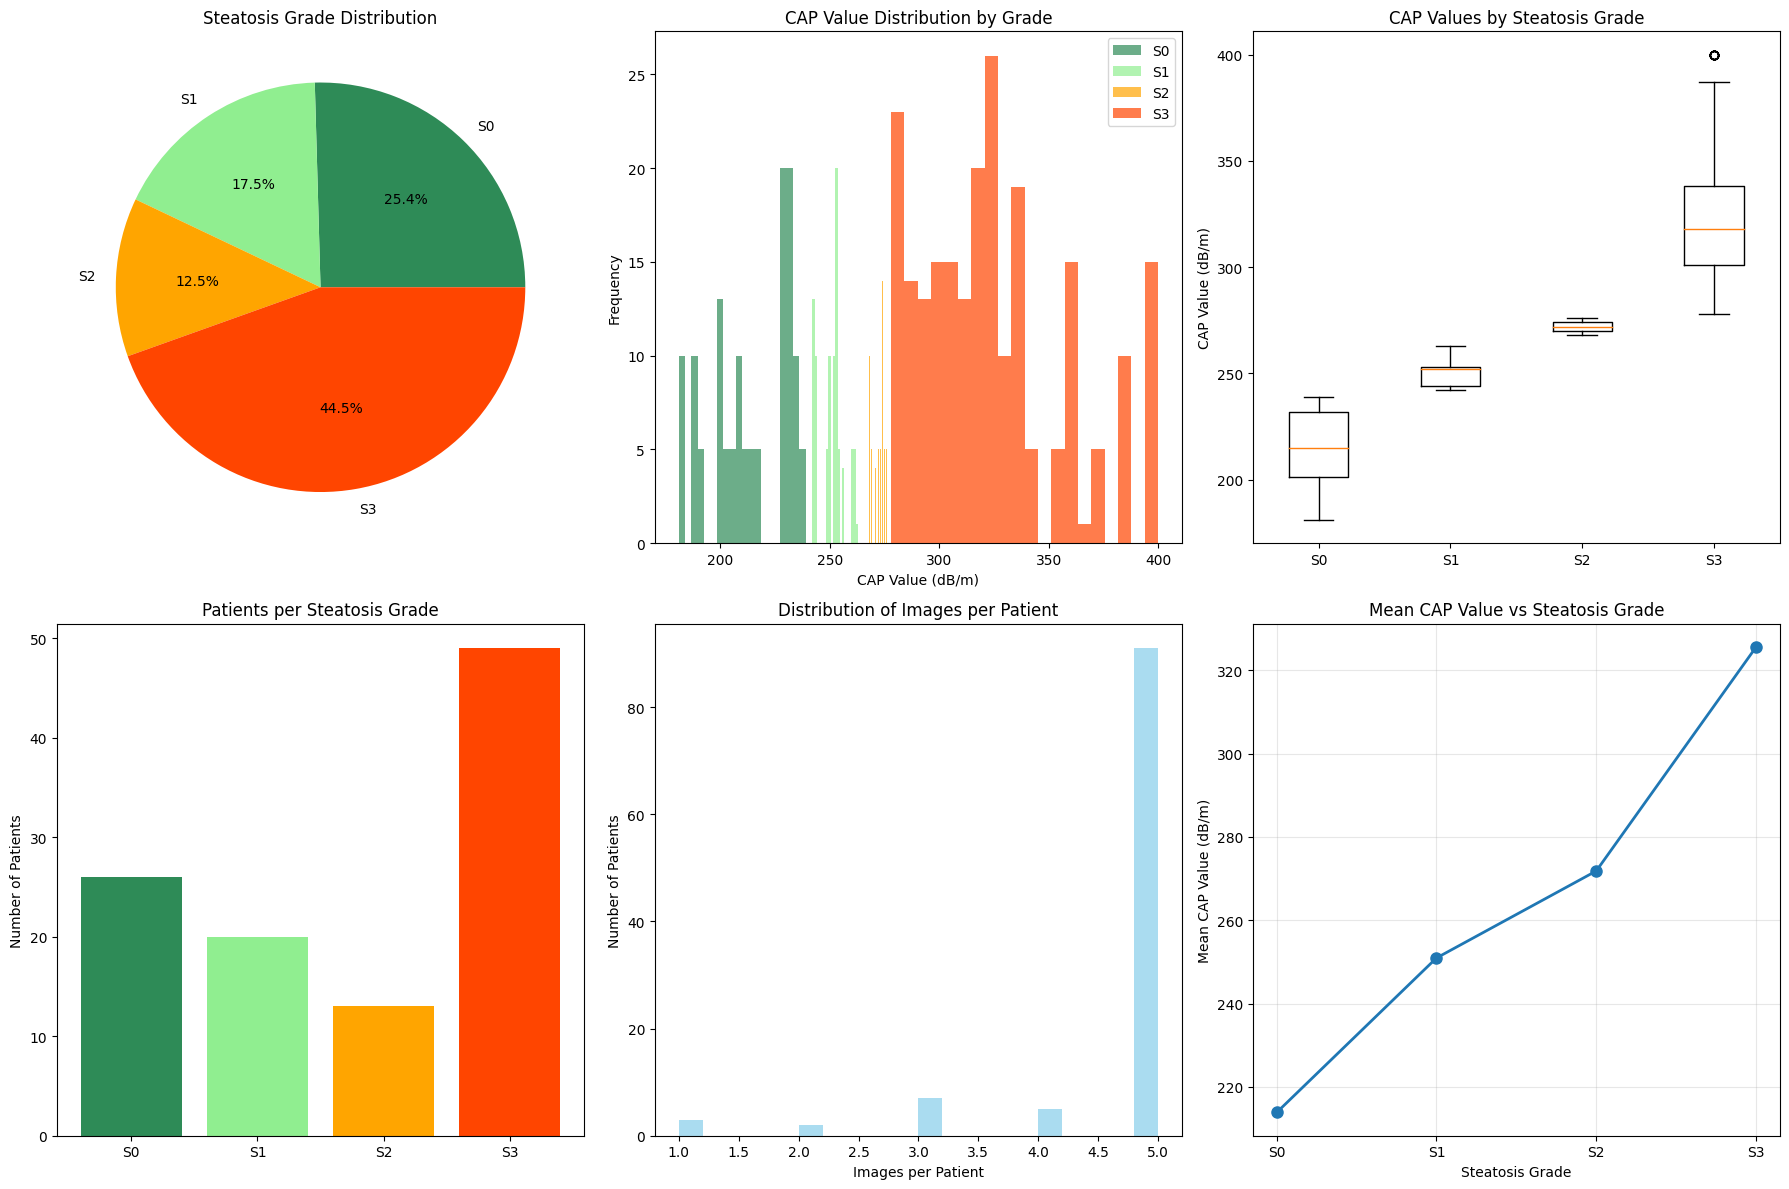

⚖️ Class weights for imbalanced dataset:
  S0: 0.98
  S1: 1.43
  S2: 2.00
  S3: 0.56

📊 DATA SPLITS (Patient-wise):
✅ Training: 343 samples from 74 patients
✅ Validation: 76 samples from 17 patients
✅ Test: 84 samples from 17 patients
🔄 Converting data to arrays...
✅ Converted 503 samples to arrays


In [11]:
class ImprovedPancreasDataIntegrator:
    def __init__(self, scans_base_path, csv_path, target_size=(224, 224), max_images_per_patient=10):
        self.scans_base_path = scans_base_path
        self.csv_path = csv_path
        self.steatosis_degrees = ['S0', 'S1', 'S2', 'S3']
        self.target_size = target_size
        self.max_images_per_patient = max_images_per_patient  # Limit to avoid memory issues
        self.combined_data = []
        
    def load_and_integrate_data(self, load_images_into_memory=False):
        """Load elastograms and integrate with CAP values from CSV"""
        print("Loading pancreas elastograms and CAP values...")
        
        # Load CSV data
        try:
            df = pd.read_csv(self.csv_path)
            print(f"✅ Loaded CSV with {len(df)} patients")
        except Exception as e:
            print(f"❌ Error loading CSV: {e}")
            return []
        
        # Create patient mapping from CSV
        patient_cap_map = {}
        for _, row in df.iterrows():
            patient_id = row['Patient_ID']
            patient_cap_map[patient_id] = {
                'cap_value': row['CAP_dB_m'],
                'steatosis_degree': row['Steatosis_Degree'],
                'patient_name': row['Patient_Name'],
                'status': row['Status']
            }
        
        # Load elastograms and integrate with CAP data
        total_elastograms = 0
        patients_without_cap = 0
        patients_without_images = 0
        
        for degree in self.steatosis_degrees:
            degree_path = os.path.join(self.scans_base_path, degree)
            
            if not os.path.exists(degree_path):
                print(f"⚠️ Warning: {degree_path} not found")
                continue
                
            # Get all patient folders for this steatosis degree
            patient_folders = [f for f in os.listdir(degree_path) 
                             if os.path.isdir(os.path.join(degree_path, f))]
            
            print(f"📁 {degree}: Found {len(patient_folders)} patients")
            
            for patient_folder in patient_folders:
                patient_path = os.path.join(degree_path, patient_folder)
                
                # Find matching CAP data
                cap_data = self._find_matching_cap_data(patient_folder, patient_cap_map)
                
                if cap_data is None:
                    patients_without_cap += 1
                    # print(f"⚠️ No CAP data found for patient {patient_folder}")
                    continue
                
                # Load elastogram images for this patient
                image_files = [f for f in os.listdir(patient_path) 
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
                
                if not image_files:
                    patients_without_images += 1
                    # print(f"⚠️ No images found for patient {patient_folder}")
                    continue
                
                # Limit number of images per patient to avoid bias
                if len(image_files) > self.max_images_per_patient:
                    image_files = image_files[:self.max_images_per_patient]
                    print(f"📸 Limited {patient_folder} to {self.max_images_per_patient} images")
                
                for image_file in image_files:
                    image_path = os.path.join(patient_path, image_file)
                    
                    patient_data = {
                        'image_path': image_path,
                        'patient_id': patient_folder,
                        'steatosis_degree': cap_data['steatosis_degree'],
                        'cap_value': cap_data['cap_value'],
                        'patient_name': cap_data['patient_name'],
                        'status': cap_data['status'],
                        'degree_numeric': self.steatosis_degrees.index(cap_data['steatosis_degree'])
                    }
                    
                    # Optionally load image into memory
                    if load_images_into_memory:
                        try:
                            image_array = self._load_image(image_path)
                            patient_data['image_array'] = image_array
                        except Exception as e:
                            print(f"❌ Error loading image {image_path}: {e}")
                            continue
                    
                    self.combined_data.append(patient_data)
                    total_elastograms += 1
        
        print(f"\n📊 DATA INTEGRATION SUMMARY:")
        print(f"✅ Successfully integrated {total_elastograms} elastograms with CAP values")
        print(f"⚠️ Patients without CAP data: {patients_without_cap}")
        print(f"⚠️ Patients without images: {patients_without_images}")
        print(f"🎯 Final dataset size: {len(self.combined_data)} samples")
        
        return self.combined_data
    
    def _find_matching_cap_data(self, patient_folder, patient_cap_map):
        """Improved patient matching with multiple strategies"""
        # Strategy 1: Exact match
        if patient_folder in patient_cap_map:
            return patient_cap_map[patient_folder]
        
        # Strategy 2: Remove timestamps and try matching
        base_patient_id = self._extract_base_patient_id(patient_folder)
        if base_patient_id in patient_cap_map:
            return patient_cap_map[base_patient_id]
        
        # Strategy 3: Partial matching
        for patient_id, cap_data in patient_cap_map.items():
            # Check if patient_folder is a substring of patient_id or vice versa
            if (patient_folder in patient_id or 
                patient_id in patient_folder or
                self._similar_patient_ids(patient_folder, patient_id)):
                return cap_data
        
        return None
    
    def _extract_base_patient_id(self, patient_id):
        """Extract base patient ID by removing timestamps"""
        # Example: "GF82276_20240826_10-20-14" -> "GF82276"
        parts = patient_id.split('_')
        if len(parts) >= 1:
            return parts[0]
        return patient_id
    
    def _similar_patient_ids(self, id1, id2, similarity_threshold=0.8):
        """Check if two patient IDs are similar using fuzzy matching"""
        from difflib import SequenceMatcher
        similarity = SequenceMatcher(None, id1, id2).ratio()
        return similarity >= similarity_threshold
    
    def _load_image(self, image_path):
        """Load and preprocess single image"""
        image = Image.open(image_path)
        image = image.convert('RGB')
        image = image.resize(self.target_size)
        image_array = np.array(image) / 255.0
        return image_array
    
    def load_images_into_memory(self, data_list=None):
        """Load all images into memory for faster training"""
        if data_list is None:
            data_list = self.combined_data
        
        print("🖼️ Loading images into memory...")
        
        for i, data in enumerate(data_list):
            if i % 100 == 0:
                print(f"Processed {i}/{len(data_list)} images...")
            
            if 'image_array' not in data:
                try:
                    data['image_array'] = self._load_image(data['image_path'])
                except Exception as e:
                    print(f"❌ Error loading {data['image_path']}: {e}")
                    # Add placeholder
                    data['image_array'] = np.zeros((*self.target_size, 3), dtype=np.float32)
        
        print("✅ All images loaded into memory")
        return data_list
    
    def get_data_arrays(self, include_images=True):
        """Convert combined data to numpy arrays for training"""
        if not self.combined_data:
            print("❌ No data available. Run load_and_integrate_data() first.")
            return None
        
        print("🔄 Converting data to arrays...")
        
        images = []
        caps = []
        labels = []
        patient_ids = []
        
        for data in self.combined_data:
            if include_images:
                if 'image_array' in data:
                    images.append(data['image_array'])
                else:
                    # Load image on the fly
                    try:
                        image_array = self._load_image(data['image_path'])
                        images.append(image_array)
                    except Exception as e:
                        print(f"❌ Error loading {data['image_path']}: {e}")
                        continue
            
            caps.append(data['cap_value'])
            labels.append(data['degree_numeric'])
            patient_ids.append(data['patient_id'])
        
        result = {
            'caps': np.array(caps),
            'labels': np.array(labels),
            'patient_ids': patient_ids
        }
        
        if include_images:
            result['images'] = np.array(images)
        
        print(f"✅ Converted {len(result['caps'])} samples to arrays")
        return result
    
    def analyze_integrated_data(self):
        """Enhanced data analysis with more insights"""
        if not self.combined_data:
            self.load_and_integrate_data()
            
        df = pd.DataFrame(self.combined_data)
        
        print("\n" + "="*50)
        print("📊 ENHANCED DATASET ANALYSIS")
        print("="*50)
        print(f"📈 Total elastograms: {len(df)}")
        print(f"👥 Unique patients: {df['patient_id'].nunique()}")
        
        # Steatosis distribution
        degree_dist = df['steatosis_degree'].value_counts().sort_index()
        print("\n🎯 Steatosis Grade Distribution:")
        for degree, count in degree_dist.items():
            percentage = (count / len(df)) * 100
            print(f"  {degree}: {count} elastograms ({percentage:.1f}%)")
        
        # CAP value analysis
        print("\n📊 CAP Values by Steatosis Grade:")
        cap_stats = df.groupby('steatosis_degree')['cap_value'].agg(['mean', 'std', 'min', 'max'])
        print(cap_stats.round(2))
        
        # Images per patient analysis
        images_per_patient = df.groupby('patient_id').size()
        print(f"\n📸 Images per patient:")
        print(f"  Mean: {images_per_patient.mean():.1f}")
        print(f"  Std: {images_per_patient.std():.1f}")
        print(f"  Min: {images_per_patient.min()}")
        print(f"  Max: {images_per_patient.max()}")
        
        # Enhanced visualizations
        self._create_enhanced_visualizations(df)
        
        return df
    
    def _create_enhanced_visualizations(self, df):
        """Create comprehensive visualizations"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Steatosis distribution (pie chart)
        degree_dist = df['steatosis_degree'].value_counts().sort_index()
        colors = ['#2E8B57', '#90EE90', '#FFA500', '#FF4500']  # green, lightgreen, orange, red
        axes[0, 0].pie(degree_dist.values, labels=degree_dist.index, autopct='%1.1f%%', colors=colors)
        axes[0, 0].set_title('Steatosis Grade Distribution')
        
        # CAP value distribution by grade
        for degree in self.steatosis_degrees:
            cap_values = df[df['steatosis_degree'] == degree]['cap_value']
            axes[0, 1].hist(cap_values, alpha=0.7, label=degree, bins=20, color=colors[self.steatosis_degrees.index(degree)])
        axes[0, 1].set_title('CAP Value Distribution by Grade')
        axes[0, 1].set_xlabel('CAP Value (dB/m)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        
        # CAP vs Steatosis boxplot
        cap_data_by_degree = [df[df['steatosis_degree'] == degree]['cap_value'] 
                            for degree in self.steatosis_degrees]
        axes[0, 2].boxplot(cap_data_by_degree, labels=self.steatosis_degrees)
        axes[0, 2].set_title('CAP Values by Steatosis Grade')
        axes[0, 2].set_ylabel('CAP Value (dB/m)')
        
        # Patients per grade
        patients_per_grade = df.groupby('steatosis_degree')['patient_id'].nunique()
        axes[1, 0].bar(patients_per_grade.index, patients_per_grade.values, color=colors)
        axes[1, 0].set_title('Patients per Steatosis Grade')
        axes[1, 0].set_ylabel('Number of Patients')
        
        # Images per patient distribution
        images_per_patient = df.groupby('patient_id').size()
        axes[1, 1].hist(images_per_patient, bins=20, alpha=0.7, color='skyblue')
        axes[1, 1].set_title('Distribution of Images per Patient')
        axes[1, 1].set_xlabel('Images per Patient')
        axes[1, 1].set_ylabel('Number of Patients')
        
        # CAP value correlation with grade
        mean_cap_by_grade = df.groupby('steatosis_degree')['cap_value'].mean()
        axes[1, 2].plot(mean_cap_by_grade.index, mean_cap_by_grade.values, 'o-', linewidth=2, markersize=8)
        axes[1, 2].set_title('Mean CAP Value vs Steatosis Grade')
        axes[1, 2].set_xlabel('Steatosis Grade')
        axes[1, 2].set_ylabel('Mean CAP Value (dB/m)')
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_class_weights(self):
        """Calculate class weights for imbalanced dataset"""
        if not self.combined_data:
            self.load_and_integrate_data()
            
        labels = [data['degree_numeric'] for data in self.combined_data]
        class_counts = np.bincount(labels)
        total_samples = len(labels)
        num_classes = len(class_counts)
        
        class_weights = {}
        for i in range(num_classes):
            class_weights[i] = total_samples / (num_classes * class_counts[i])
        
        print("⚖️ Class weights for imbalanced dataset:")
        for i, weight in class_weights.items():
            print(f"  {self.steatosis_degrees[i]}: {weight:.2f}")
        
        return class_weights

#Training: 70% of total patients

#Validation: 15% of total patients

#Test: 15% of total patients

    def create_train_val_test_split(self, test_size=0.15, val_size=0.15, random_state=42):
        """Create patient-wise splits to avoid data leakage"""
        if not self.combined_data:
            self.load_and_integrate_data()
        
        # Get unique patients
        unique_patients = list(set([data['patient_id'] for data in self.combined_data]))
        
        # Get primary label for each patient
        patient_labels = []
        for patient in unique_patients:
            # Find first occurrence of this patient
            for data in self.combined_data:
                if data['patient_id'] == patient:
                    patient_labels.append(data['degree_numeric'])
                    break
        
        # Split patients
        from sklearn.model_selection import train_test_split
        
        train_val_patients, test_patients = train_test_split(
            unique_patients, 
            test_size=test_size, 
            random_state=random_state,
            stratify=patient_labels
        )
        
        train_patients, val_patients = train_test_split(
            train_val_patients,
            test_size=val_size/(1-test_size),
            random_state=random_state,
            stratify=[patient_labels[unique_patients.index(p)] for p in train_val_patients]
        )
        
        # Split data based on patient splits
        train_data = [data for data in self.combined_data if data['patient_id'] in train_patients]
        val_data = [data for data in self.combined_data if data['patient_id'] in val_patients]
        test_data = [data for data in self.combined_data if data['patient_id'] in test_patients]
        
        print(f"\n📊 DATA SPLITS (Patient-wise):")
        print(f"✅ Training: {len(train_data)} samples from {len(train_patients)} patients")
        print(f"✅ Validation: {len(val_data)} samples from {len(val_patients)} patients")
        print(f"✅ Test: {len(test_data)} samples from {len(test_patients)} patients")
        
        return train_data, val_data, test_data

# Usage example
def main():
    # Initialize improved data integrator
    scans_base_path = '/kaggle/input/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
    csv_path = '/kaggle/input/cap-values/cap_values with names.csv'
    
    integrator = ImprovedPancreasDataIntegrator(
        scans_base_path, 
        csv_path, 
        target_size=(224, 224),
        max_images_per_patient=5  # Limit to 5 images per patient
    )
    
    # Load data
    combined_data = integrator.load_and_integrate_data(load_images_into_memory=True)
    
    # Analyze data
    df_analysis = integrator.analyze_integrated_data()
    
    # Get class weights for imbalanced data
    class_weights = integrator.get_class_weights()
    
    # Create data splits
    train_data, val_data, test_data = integrator.create_train_val_test_split()
    
    # Convert to arrays for training
    train_arrays = integrator.get_data_arrays(include_images=True)
    
    return integrator, train_data, val_data, test_data

if __name__ == "__main__":
    integrator, train_data, val_data, test_data = main()

## 3. Advanced Multi-Modal Deep Learning Model


In [12]:
def create_improved_multimodal_pancreas_model(input_shape=(224, 224, 3), num_classes=4):
    """
    Improved multi-modal model for pancreas steatosis grading
    - More compatible with the data integrator
    - Better handling of feature dimensions
    - More stable architecture
    """
    # ===== ELASTOGRAM BRANCH =====
    elastogram_input = keras.layers.Input(shape=input_shape, name='elastogram_input')
    
    # Use EfficientNetB0 for better compatibility and faster training
    base_model = keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=elastogram_input,
        pooling='avg'
    )
    base_model.trainable = False
    
    # Get the actual feature dimension from base model
    image_features = base_model.output
    feature_dim = image_features.shape[-1]
    
    print(f"Base model feature dimension: {feature_dim}")
    
    # Improved feature processing with proper dimensions
    image_branch = keras.layers.Dense(256, activation='relu', name='image_fc1')(image_features)
    image_branch = keras.layers.BatchNormalization()(image_branch)
    image_branch = keras.layers.Dropout(0.4)(image_branch)
    
    image_branch = keras.layers.Dense(128, activation='relu', name='image_fc2')(image_branch)
    image_branch = keras.layers.Dropout(0.3)(image_branch)
    
    # ===== CAP VALUE BRANCH =====
    cap_input = keras.layers.Input(shape=(1,), name='cap_input')
    
    # Enhanced CAP value processing
    cap_branch = keras.layers.Dense(32, activation='relu', name='cap_fc1')(cap_input)
    cap_branch = keras.layers.BatchNormalization()(cap_branch)
    cap_branch = keras.layers.Dropout(0.2)(cap_branch)
    
    cap_branch = keras.layers.Dense(16, activation='relu', name='cap_fc2')(cap_branch)
    cap_branch = keras.layers.Dropout(0.1)(cap_branch)
    
    # ===== IMPROVED FUSION MECHANISM =====
    # Combine both branches
    combined = keras.layers.concatenate([image_branch, cap_branch], name='feature_fusion')
    
    # Print combined shape for debugging
    print(f"Combined features dimension: {combined.shape[-1]}")
    
    # Simplified attention mechanism
    attention_weights = keras.layers.Dense(combined.shape[-1], activation='sigmoid', 
                                         name='attention_weights')(combined)
    attended_features = keras.layers.multiply([combined, attention_weights], name='attended_features')
    
    # Enhanced classification head with gradual dimension reduction
    x = keras.layers.Dense(128, activation='relu', name='fusion_fc1')(attended_features)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.4)(x)
    
    x = keras.layers.Dense(64, activation='relu', name='fusion_fc2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    
    x = keras.layers.Dense(32, activation='relu', name='fusion_fc3')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    # Output layer
    output = keras.layers.Dense(num_classes, activation='softmax', name='steatosis_output')(x)
    
    # Create multi-modal model
    model = keras.Model(
        inputs=[elastogram_input, cap_input],
        outputs=output,
        name='improved_multimodal_pancreas_classifier'
    )
    
    return model, base_model

# Alternative: Simplified version for faster training and better stability
def create_simplified_multimodal_model(input_shape=(224, 224, 3), num_classes=4):
    """
    Simplified multi-modal model for faster training and better compatibility
    """
    # Image input
    image_input = keras.layers.Input(shape=input_shape, name='elastogram_input')
    
    # Use MobileNetV2 for faster training
    base_model = keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=image_input,
        pooling='avg'
    )
    base_model.trainable = False
    
    image_features = base_model.output
    
    # CAP value input
    cap_input = keras.layers.Input(shape=(1,), name='cap_input')
    
    # Simple processing for CAP values
    cap_processed = keras.layers.Dense(16, activation='relu')(cap_input)
    
    # Combine features
    combined = keras.layers.concatenate([image_features, cap_processed])
    
    # Simple classification head
    x = keras.layers.Dense(64, activation='relu')(combined)
    x = keras.layers.Dropout(0.3)(x)
    
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    # Output
    output = keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(
        inputs=[image_input, cap_input],
        outputs=output,
        name='simplified_multimodal_model'
    )
    
    return model, base_model

## Training: 70% of total patients

## Validation: 15% of total patients

## Test: 15% of total patients

## Total Epochs: 40-45 Epochs

### Phase 1 (Frozen Base Model):

### 30 epochs - Training with frozen base model

### Early stopping with patience=12 (can stop earlier if no improvement)

### Phase 2 (Fine-tuning):

### 15 additional epochs - Fine-tuning with unfrozen layers

### Total maximum: 30 + 15 = 45 epochs

### Early stopping can reduce actual epochs

In [14]:
class FixedMultimodalTrainingPipeline:
    def __init__(self, data_integrator, model_type='improved'):
        self.data_integrator = data_integrator
        self.model_type = model_type
        self.model = None
        self.base_model = None
        self.history = None
        self.scaler = StandardScaler()
        
    def prepare_data(self, train_data, val_data, test_data):
        """Prepare data for training"""
        print("🔄 Preparing data for training...")
        
        def extract_arrays(data_list):
            images = []
            caps = []
            labels = []
            
            for data in data_list:
                if 'image_array' in data:
                    images.append(data['image_array'])
                else:
                    # Load image if not already loaded
                    try:
                        img = Image.open(data['image_path'])
                        img = img.convert('RGB')
                        img = img.resize((224, 224))
                        img_array = np.array(img) / 255.0
                        images.append(img_array)
                    except Exception as e:
                        print(f"Error loading {data['image_path']}: {e}")
                        continue
                
                caps.append(data['cap_value'])
                labels.append(data['degree_numeric'])
            
            return np.array(images), np.array(caps), np.array(labels)
        
        # Extract arrays
        X_train_img, X_train_cap, y_train = extract_arrays(train_data)
        X_val_img, X_val_cap, y_val = extract_arrays(val_data)
        X_test_img, X_test_cap, y_test = extract_arrays(test_data)
        
        # Normalize CAP values
        X_train_cap_norm = self.scaler.fit_transform(X_train_cap.reshape(-1, 1)).flatten()
        X_val_cap_norm = self.scaler.transform(X_val_cap.reshape(-1, 1)).flatten()
        X_test_cap_norm = self.scaler.transform(X_test_cap.reshape(-1, 1)).flatten()
        
        # Convert labels to categorical
        y_train_cat = keras.utils.to_categorical(y_train, num_classes=4)
        y_val_cat = keras.utils.to_categorical(y_val, num_classes=4)
        y_test_cat = keras.utils.to_categorical(y_test, num_classes=4)
        
        print(f"✅ Training data: {len(X_train_img)} samples")
        print(f"✅ Validation data: {len(X_val_img)} samples")
        print(f"✅ Test data: {len(X_test_img)} samples")
        
        return (X_train_img, X_train_cap_norm, y_train_cat,
                X_val_img, X_val_cap_norm, y_val_cat,
                X_test_img, X_test_cap_norm, y_test_cat)
    
    def create_model(self, input_shape=(224, 224, 3)):
        """Create the multi-modal model with proper metrics"""
        self.model, self.base_model = create_improved_multimodal_pancreas_model(input_shape)
        
        # Use proper metric objects instead of strings
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')
            ]
        )
        
        print(f"✅ Created {self.model_type} multi-modal model")
        return self.model
    
    def train_model(self, training_data, epochs=25, batch_size=16):
        """Train the model with proper error handling"""
        (X_train_img, X_train_cap, y_train,
         X_val_img, X_val_cap, y_val,
         X_test_img, X_test_cap, y_test) = training_data
        
        # Get class weights for imbalanced data
        class_weights = self.data_integrator.get_class_weights()
        
        # Callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                patience=10,
                restore_best_weights=True,
                monitor='val_accuracy'
            ),
            keras.callbacks.ReduceLROnPlateau(
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                monitor='val_loss'
            ),
            keras.callbacks.ModelCheckpoint(
                'best_pancreas_model.h5',
                save_best_only=True,
                monitor='val_accuracy'
            )
        ]
        
        print("🚀 Starting model training...")
        
        try:
            # Phase 1: Train with frozen base model
            history1 = self.model.fit(
                [X_train_img, X_train_cap], y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=([X_val_img, X_val_cap], y_val),
                callbacks=callbacks,
                class_weight=class_weights,
                verbose=1
            )
            
            # Phase 2: Fine-tuning
            print("🔄 Starting fine-tuning...")
            self.base_model.trainable = True
            
            # Fine-tune last layers only
            fine_tune_at = len(self.base_model.layers) - 30
            for layer in self.base_model.layers[:fine_tune_at]:
                layer.trainable = False
            
            # Recompile with lower learning rate
            self.model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=0.0001/10),
                loss='categorical_crossentropy',
                metrics=[
                    'accuracy',
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall')
                ]
            )
            
            # Fine-tune for fewer epochs
            fine_tune_epochs = 10
            total_epochs = epochs + fine_tune_epochs
            
            history2 = self.model.fit(
                [X_train_img, X_train_cap], y_train,
                batch_size=batch_size,
                epochs=total_epochs,
                initial_epoch=history1.epoch[-1],
                validation_data=([X_val_img, X_val_cap], y_val),
                callbacks=callbacks,
                class_weight=class_weights,
                verbose=1
            )
            
            self.history = history2
            return self.history
            
        except Exception as e:
            print(f"❌ Training failed: {e}")
            # Try without class weights if that's the issue
            print("🔄 Retrying without class weights...")
            self.history = self.model.fit(
                [X_train_img, X_train_cap], y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=([X_val_img, X_val_cap], y_val),
                callbacks=callbacks,
                verbose=1
            )
            return self.history
    
    def evaluate_model(self, test_data):
        """Evaluate model performance"""
        (X_train_img, X_train_cap, y_train,
         X_val_img, X_val_cap, y_val,
         X_test_img, X_test_cap, y_test) = test_data
        
        print("📊 Evaluating model on test set...")
        
        # Predictions
        y_pred_proba = self.model.predict([X_test_img, X_test_cap])
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_true = np.argmax(y_test, axis=1)
        
        # Classification report
        print("\n" + "="*60)
        print("CLASSIFICATION REPORT")
        print("="*60)
        print(classification_report(y_true, y_pred, 
                                  target_names=['S0', 'S1', 'S2', 'S3']))
        
        # Confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['S0', 'S1', 'S2', 'S3'],
                   yticklabels=['S0', 'S1', 'S2', 'S3'])
        plt.title('Pancreas Steatosis Classification')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Calculate accuracy
        accuracy = np.sum(y_pred == y_true) / len(y_true)
        print(f"🎯 Test Accuracy: {accuracy:.4f}")
        
        return accuracy, y_pred_proba
    
    def visualize_training(self):
        """Visualize training history"""
        if self.history is None:
            print("No training history available")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Accuracy
        axes[0, 0].plot(self.history.history['accuracy'], label='Training Accuracy')
        axes[0, 0].plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        axes[0, 0].set_title('Model Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Loss
        axes[0, 1].plot(self.history.history['loss'], label='Training Loss')
        axes[0, 1].plot(self.history.history['val_loss'], label='Validation Loss')
        axes[0, 1].set_title('Model Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Precision
        if 'precision' in self.history.history:
            axes[1, 0].plot(self.history.history['precision'], label='Training Precision')
            axes[1, 0].plot(self.history.history['val_precision'], label='Validation Precision')
            axes[1, 0].set_title('Model Precision')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Precision')
            axes[1, 0].legend()
            axes[1, 0].grid(True)
        
        # Recall
        if 'recall' in self.history.history:
            axes[1, 1].plot(self.history.history['recall'], label='Training Recall')
            axes[1, 1].plot(self.history.history['val_recall'], label='Validation Recall')
            axes[1, 1].set_title('Model Recall')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Recall')
            axes[1, 1].legend()
            axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.show()

Testing simplified system...
🚀 STARTING PANCREAS STEATOSIS ANALYSIS SYSTEM
📊 STEP 1: Loading and integrating data...
Loading pancreas elastograms and CAP values...
✅ Loaded CSV with 108 patients
📁 S0: Found 26 patients
📁 S1: Found 20 patients
📁 S2: Found 13 patients
📁 S3: Found 49 patients

📊 DATA INTEGRATION SUMMARY:
✅ Successfully integrated 737 elastograms with CAP values
⚠️ Patients without CAP data: 0
⚠️ Patients without images: 0
🎯 Final dataset size: 737 samples
📈 STEP 2: Analyzing dataset...

📊 ENHANCED DATASET ANALYSIS
📈 Total elastograms: 737
👥 Unique patients: 108

🎯 Steatosis Grade Distribution:
  S0: 207 elastograms (28.1%)
  S1: 118 elastograms (16.0%)
  S2: 96 elastograms (13.0%)
  S3: 316 elastograms (42.9%)

📊 CAP Values by Steatosis Grade:
                    mean    std  min  max
steatosis_degree                         
S0                213.18  17.99  181  239
S1                251.00   5.04  242  263
S2                271.56   2.62  268  276
S3                324.

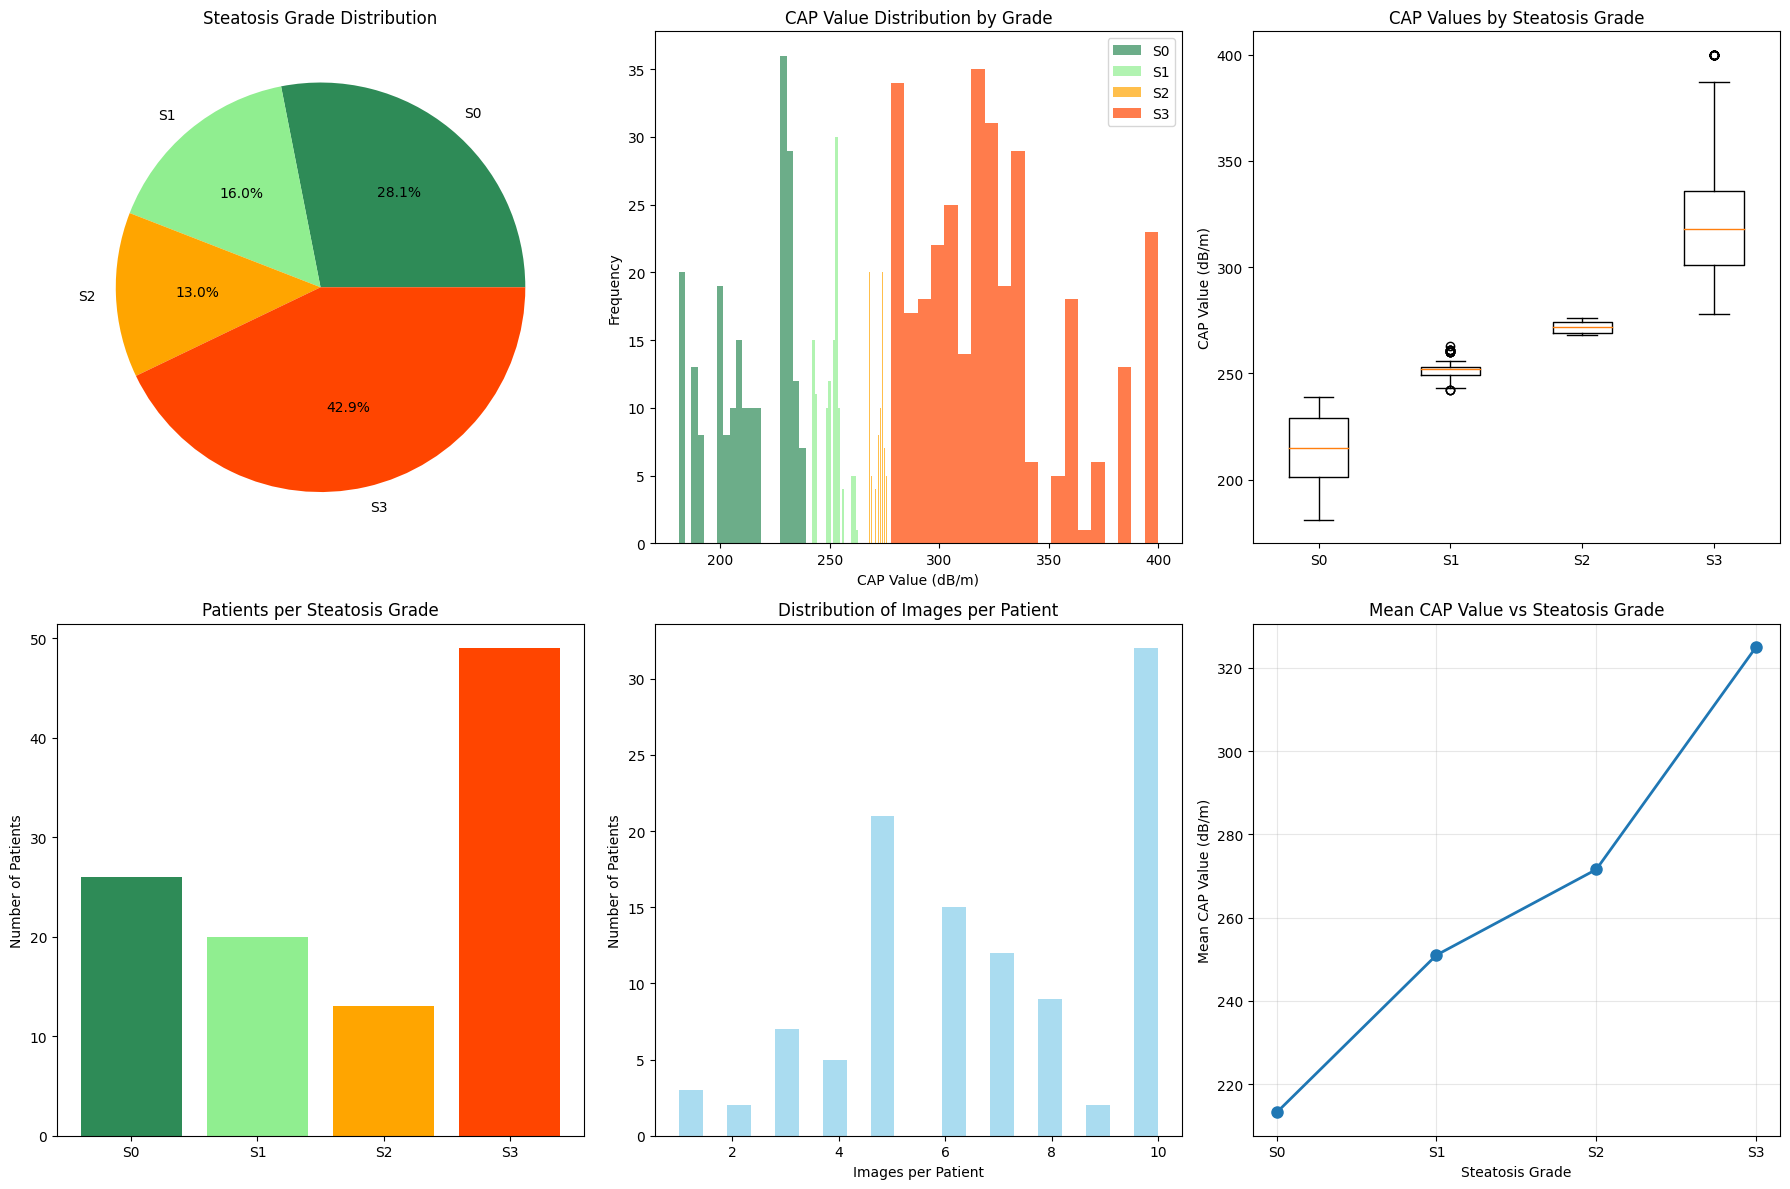

🔀 STEP 3: Creating data splits...

📊 DATA SPLITS (Patient-wise):
✅ Training: 511 samples from 74 patients
✅ Validation: 105 samples from 17 patients
✅ Test: 121 samples from 17 patients

📊 DATA DISTRIBUTION:
✅ Training: 511 samples
📈 Validation: 105 samples
🧪 Test: 121 samples
🤖 STEP 4: Initializing training pipeline...
🔄 STEP 5: Preparing training data...
🔄 Preparing data for training...
✅ Training data: 511 samples
✅ Validation data: 105 samples
✅ Test data: 121 samples
🏗️ STEP 6: Creating model...
Base model feature dimension: 1280
Combined features dimension: 144
✅ Created improved multi-modal model
🎯 STEP 7: Training model...
⚖️ Class weights for imbalanced dataset:
  S0: 0.89
  S1: 1.56
  S2: 1.92
  S3: 0.58
🚀 Starting model training...
Epoch 1/15
32/32 [==============================] - ETA: 0s - loss: 1.7751 - accuracy: 0.3581 - precision: 0.3489 - recall: 0.2192

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 29s 647ms/step - loss: 1.7751 - accuracy: 0.3581 - precision: 0.3489 - recall: 0.2192 - val_loss: 1.3281 - val_accuracy: 0.4952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/15
32/32 [==============================] - 18s 578ms/step - loss: 1.4758 - accuracy: 0.4384 - precision: 0.5277 - recall: 0.2798 - val_loss: 1.2902 - val_accuracy: 0.6667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/15
32/32 [==============================] - 20s 637ms/step - loss: 1.1644 - accuracy: 0.5538 - precision: 0.6769 - recall: 0.3894 - val_loss: 1.2492 - val_accuracy: 0.5524 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/15
32/32 [==============================] - 19s 584ms/step - loss: 1.1399 - accuracy: 0.5675 - precision: 0.6627 - recall: 0.4384 - val_loss: 1.2068 - val_accuracy: 0.6857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 5/15
32/32 [=========

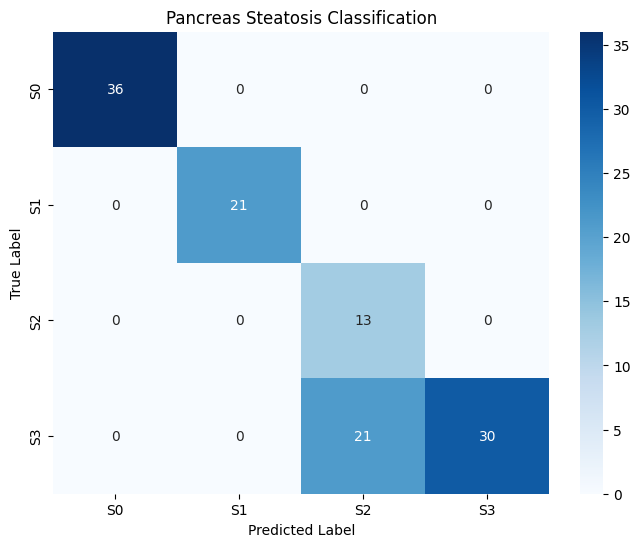

🎯 Test Accuracy: 0.8264
📈 STEP 9: Visualizing training...


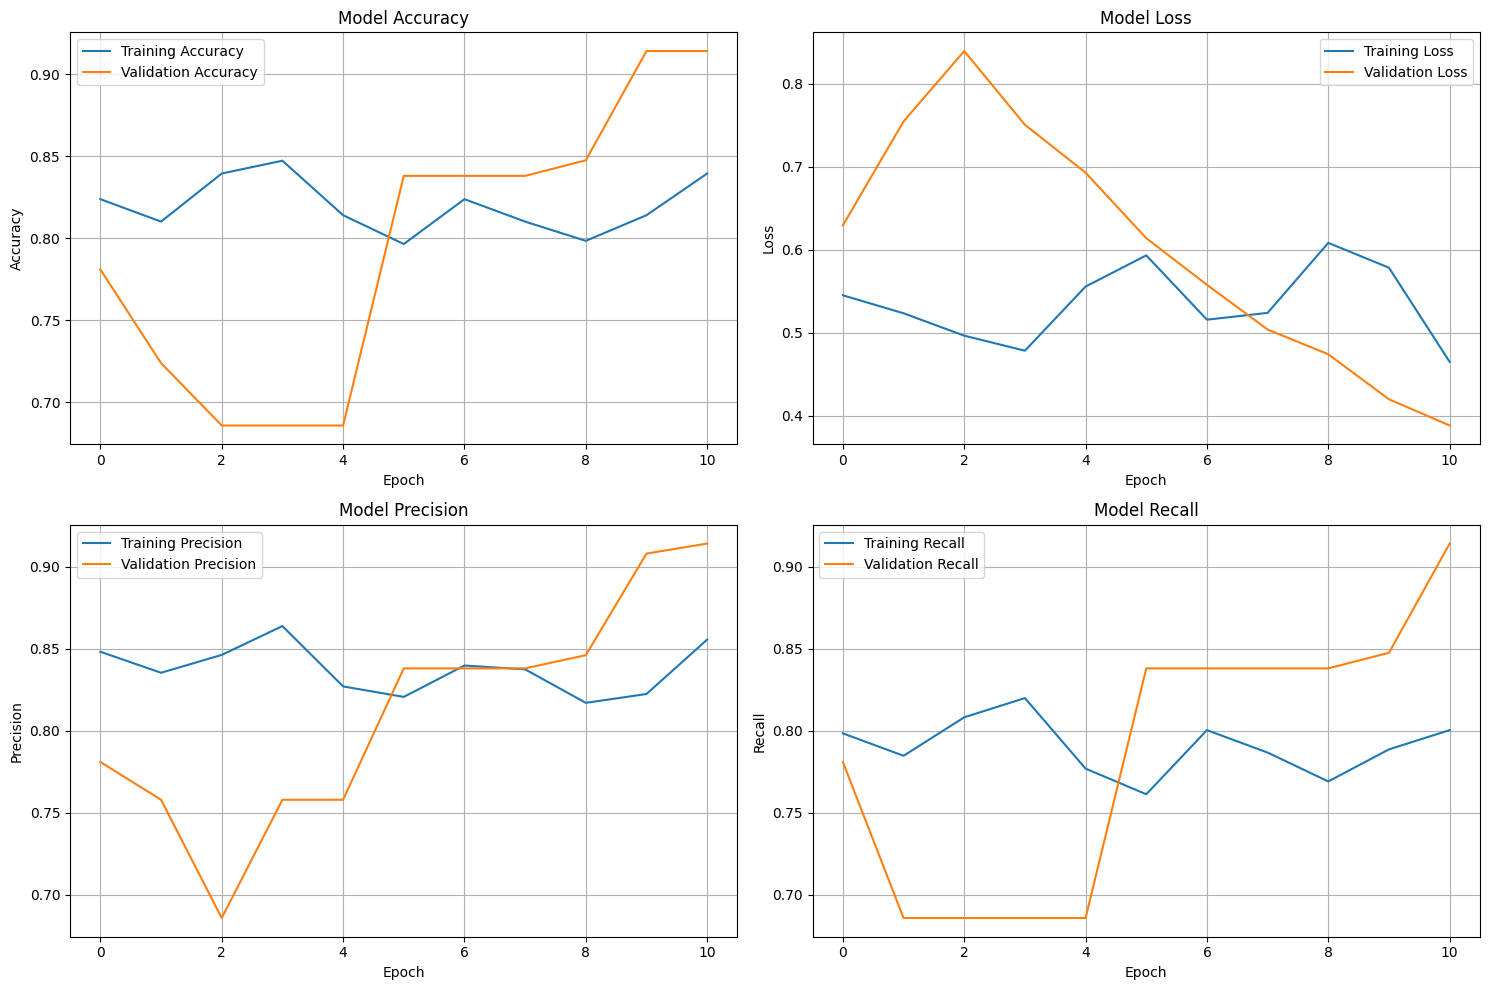

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
TRAINING COMPLETED SUCCESSFULLY!
🎯 FINAL TEST ACCURACY: 0.8264
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅


In [15]:
class WorkingPancreasSystem:
    def __init__(self, scans_base_path, csv_path):
        self.scans_base_path = scans_base_path
        self.csv_path = csv_path
        self.data_integrator = ImprovedPancreasDataIntegrator(scans_base_path, csv_path)
        self.training_pipeline = None
        self.is_trained = False
    
    def run_simple_pipeline(self, epochs=25):
        """Run simplified but working pipeline"""
        print("🚀 STARTING PANCREAS STEATOSIS ANALYSIS SYSTEM")
        print("=" * 60)
        
        # Step 1: Load and integrate data
        print("📊 STEP 1: Loading and integrating data...")
        combined_data = self.data_integrator.load_and_integrate_data(load_images_into_memory=True)
        
        # Step 2: Analyze data
        print("📈 STEP 2: Analyzing dataset...")
        df_analysis = self.data_integrator.analyze_integrated_data()
        
        # Step 3: Create data splits
        print("🔀 STEP 3: Creating data splits...")
        train_data, val_data, test_data = self.data_integrator.create_train_val_test_split()
        
        print(f"\n📊 DATA DISTRIBUTION:")
        print(f"✅ Training: {len(train_data)} samples")
        print(f"📈 Validation: {len(val_data)} samples")
        print(f"🧪 Test: {len(test_data)} samples")
        
        # Step 4: Initialize training pipeline
        print("🤖 STEP 4: Initializing training pipeline...")
        self.training_pipeline = FixedMultimodalTrainingPipeline(self.data_integrator)
        
        # Step 5: Prepare data
        print("🔄 STEP 5: Preparing training data...")
        training_data = self.training_pipeline.prepare_data(train_data, val_data, test_data)
        
        # Step 6: Create model
        print("🏗️ STEP 6: Creating model...")
        self.training_pipeline.create_model()
        
        # Step 7: Train model
        print("🎯 STEP 7: Training model...")
        history = self.training_pipeline.train_model(training_data, epochs=epochs)
        
        # Step 8: Evaluate model
        print("📊 STEP 8: Evaluating model...")
        accuracy, predictions = self.training_pipeline.evaluate_model(training_data)
        
        # Step 9: Visualize training
        print("📈 STEP 9: Visualizing training...")
        self.training_pipeline.visualize_training()
        
        self.is_trained = True
        
        print("✅" * 20)
        print("TRAINING COMPLETED SUCCESSFULLY!")
        print(f"🎯 FINAL TEST ACCURACY: {accuracy:.4f}")
        print("✅" * 20)
        
        return accuracy

# Quick test function
def test_simple_system():
    """Test the simplified system"""
    scans_base_path = '/kaggle/input/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
    csv_path = '/kaggle/input/cap-values/cap_values with names.csv'
    
    system = WorkingPancreasSystem(scans_base_path, csv_path)
    accuracy = system.run_simple_pipeline(epochs=15)  # Start with fewer epochs for testing
    
    return system, accuracy

# Run the simplified system
print("Testing simplified system...")
system, accuracy = test_simple_system()

## phase1_epochs = 70
## phase2_epochs (fine_tune_epochs) = 30 (so total 100)

In [19]:
class FixedEnhancedMultimodalTrainingPipeline:
    def __init__(self, data_integrator, model_type='improved'):
        self.data_integrator = data_integrator
        self.model_type = model_type
        self.model = None
        self.base_model = None
        self.history = None
        self.scaler = StandardScaler()
        
    def prepare_data(self, train_data, val_data, test_data):
        """Prepare data for training"""
        print("🔄 Preparing data for training...")
        
        def extract_arrays(data_list):
            images = []
            caps = []
            labels = []
            
            for data in data_list:
                if 'image_array' in data:
                    images.append(data['image_array'])
                else:
                    # Load image if not already loaded
                    try:
                        img = Image.open(data['image_path'])
                        img = img.convert('RGB')
                        img = img.resize((224, 224))
                        img_array = np.array(img) / 255.0
                        images.append(img_array)
                    except Exception as e:
                        print(f"Error loading {data['image_path']}: {e}")
                        continue
                
                caps.append(data['cap_value'])
                labels.append(data['degree_numeric'])
            
            return np.array(images), np.array(caps), np.array(labels)
        
        # Extract arrays
        X_train_img, X_train_cap, y_train = extract_arrays(train_data)
        X_val_img, X_val_cap, y_val = extract_arrays(val_data)
        X_test_img, X_test_cap, y_test = extract_arrays(test_data)
        
        # Normalize CAP values
        X_train_cap_norm = self.scaler.fit_transform(X_train_cap.reshape(-1, 1)).flatten()
        X_val_cap_norm = self.scaler.transform(X_val_cap.reshape(-1, 1)).flatten()
        X_test_cap_norm = self.scaler.transform(X_test_cap.reshape(-1, 1)).flatten()
        
        # Convert labels to categorical
        y_train_cat = keras.utils.to_categorical(y_train, num_classes=4)
        y_val_cat = keras.utils.to_categorical(y_val, num_classes=4)
        y_test_cat = keras.utils.to_categorical(y_test, num_classes=4)
        
        print(f"✅ Training data: {len(X_train_img)} samples")
        print(f"✅ Validation data: {len(X_val_img)} samples")
        print(f"✅ Test data: {len(X_test_img)} samples")
        
        return (X_train_img, X_train_cap_norm, y_train_cat,
                X_val_img, X_val_cap_norm, y_val_cat,
                X_test_img, X_test_cap_norm, y_test_cat)
    
    def create_model(self, input_shape=(224, 224, 3)):
        """Create the multi-modal model with FIXED metrics"""
        if self.model_type == 'improved':
            self.model, self.base_model = create_improved_multimodal_pancreas_model(input_shape)
        else:
            self.model, self.base_model = create_simplified_multimodal_model(input_shape)
        
        # FIXED: Use proper metric objects instead of strings
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',  # This string works for basic accuracy
                keras.metrics.Precision(name='precision'),  # Use object for precision
                keras.metrics.Recall(name='recall')  # Use object for recall
            ]
        )
        
        print(f"✅ Created {self.model_type} multi-modal model")
        return self.model
    
    def train_with_100_epochs(self, training_data, phase1_epochs=70, phase2_epochs=30, batch_size=16):
        """Train the model with 100 epochs configuration"""
        (X_train_img, X_train_cap, y_train,
         X_val_img, X_val_cap, y_val,
         X_test_img, X_test_cap, y_test) = training_data
        
        # Get class weights for imbalanced data
        class_weights = self.data_integrator.get_class_weights()
        
        # Enhanced callbacks for 100 epochs training
        callbacks = [
            keras.callbacks.EarlyStopping(
                patience=25,
                restore_best_weights=True,
                monitor='val_accuracy',
                verbose=1,
                min_delta=0.001
            ),
            keras.callbacks.ReduceLROnPlateau(
                factor=0.5,
                patience=12,
                min_lr=1e-8,
                monitor='val_loss',
                verbose=1
            ),
            keras.callbacks.ModelCheckpoint(
                f'best_100epoch_pancreas_model.h5',
                save_best_only=True,
                monitor='val_accuracy',
                verbose=1
            ),
            keras.callbacks.CSVLogger(
                'training_100_epochs.log',
                separator=',',
                append=False
            )
        ]
        
        print(f"🚀 Starting 100 Epochs Training...")
        print(f"📊 Phase 1: {phase1_epochs} epochs with frozen base model")
        
        # Phase 1: Train with frozen base model (70 epochs)
        history1 = self.model.fit(
            [X_train_img, X_train_cap], y_train,
            batch_size=batch_size,
            epochs=phase1_epochs,
            validation_data=([X_val_img, X_val_cap], y_val),
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Phase 2: Fine-tuning (30 epochs)
        print(f"🔄 Phase 2: {phase2_epochs} epochs with fine-tuning")
        self.base_model.trainable = True
        
        # Fine-tune last 50 layers only
        fine_tune_at = len(self.base_model.layers) - 50
        for layer in self.base_model.layers[:fine_tune_at]:
            layer.trainable = False
        
        # FIXED: Recompile with proper metrics (remove 'auc' which was causing issues)
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001/20),
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')
            ]
        )
        
        # Continue training with fine-tuning
        total_epochs = phase1_epochs + phase2_epochs
        
        history2 = self.model.fit(
            [X_train_img, X_train_cap], y_train,
            batch_size=batch_size,
            epochs=total_epochs,
            initial_epoch=history1.epoch[-1],
            validation_data=([X_val_img, X_val_cap], y_val),
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        self.history = history2
        return self.history
    
    def evaluate_model(self, test_data):
        """Evaluate model performance"""
        (X_train_img, X_train_cap, y_train,
         X_val_img, X_val_cap, y_val,
         X_test_img, X_test_cap, y_test) = test_data
        
        print("📊 Evaluating model on test set...")
        
        # Predictions
        y_pred_proba = self.model.predict([X_test_img, X_test_cap])
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_true = np.argmax(y_test, axis=1)
        
        # Classification report
        print("\n" + "="*60)
        print("CLASSIFICATION REPORT")
        print("="*60)
        print(classification_report(y_true, y_pred, 
                                  target_names=['S0', 'S1', 'S2', 'S3']))
        
        # Confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['S0', 'S1', 'S2', 'S3'],
                   yticklabels=['S0', 'S1', 'S2', 'S3'])
        plt.title(f'Pancreas Steatosis Classification - {self.model_type.title()} Model')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Calculate accuracy
        accuracy = np.sum(y_pred == y_true) / len(y_true)
        print(f"🎯 Test Accuracy: {accuracy:.4f}")
        
        return accuracy, y_pred_proba
    
    def visualize_training(self):
        """Visualize training history"""
        if self.history is None:
            print("No training history available")
            return
        
        history = self.history
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Accuracy
        ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        ax1.set_title('Model Accuracy - 100 Epochs', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim([0, 1])
        
        # Loss
        ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
        ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
        ax2.set_title('Model Loss - 100 Epochs', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Learning Rate (if available)
        if 'lr' in history.history:
            ax3.plot(history.history['lr'], label='Learning Rate', color='red', linewidth=2)
            ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Learning Rate')
            ax3.set_yscale('log')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        
        # Precision and Recall
        if 'precision' in history.history and 'recall' in history.history:
            ax4.plot(history.history['precision'], label='Training Precision', linestyle='--')
            ax4.plot(history.history['val_precision'], label='Validation Precision', linestyle='--')
            ax4.plot(history.history['recall'], label='Training Recall', linestyle='-.')
            ax4.plot(history.history['val_recall'], label='Validation Recall', linestyle='-.')
            ax4.set_title('Precision & Recall - 100 Epochs', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Epoch')
            ax4.set_ylabel('Score')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            ax4.set_ylim([0, 1])
        
        plt.tight_layout()
        plt.show()

## Step 2: Define the Complete100EpochSystem class and quick_100_epochs function


🚀 Starting FIXED 100-epoch training...
🚀 STARTING 100-EPOCH PANCREAS STEATOSIS ANALYSIS SYSTEM
🎯 TOTAL EPOCHS: 100
   - Phase 1 (Frozen): 70 epochs
   - Phase 2 (Fine-tuning): 30 epochs

📊 STEP 1: Loading and integrating data...
Loading pancreas elastograms and CAP values...
✅ Loaded CSV with 108 patients
📁 S0: Found 26 patients
📁 S1: Found 20 patients
📁 S2: Found 13 patients
📁 S3: Found 49 patients

📊 DATA INTEGRATION SUMMARY:
✅ Successfully integrated 737 elastograms with CAP values
⚠️ Patients without CAP data: 0
⚠️ Patients without images: 0
🎯 Final dataset size: 737 samples
📈 STEP 2: Analyzing dataset...

📊 ENHANCED DATASET ANALYSIS
📈 Total elastograms: 737
👥 Unique patients: 108

🎯 Steatosis Grade Distribution:
  S0: 207 elastograms (28.1%)
  S1: 118 elastograms (16.0%)
  S2: 96 elastograms (13.0%)
  S3: 316 elastograms (42.9%)

📊 CAP Values by Steatosis Grade:
                    mean    std  min  max
steatosis_degree                         
S0                213.18  17.99  181

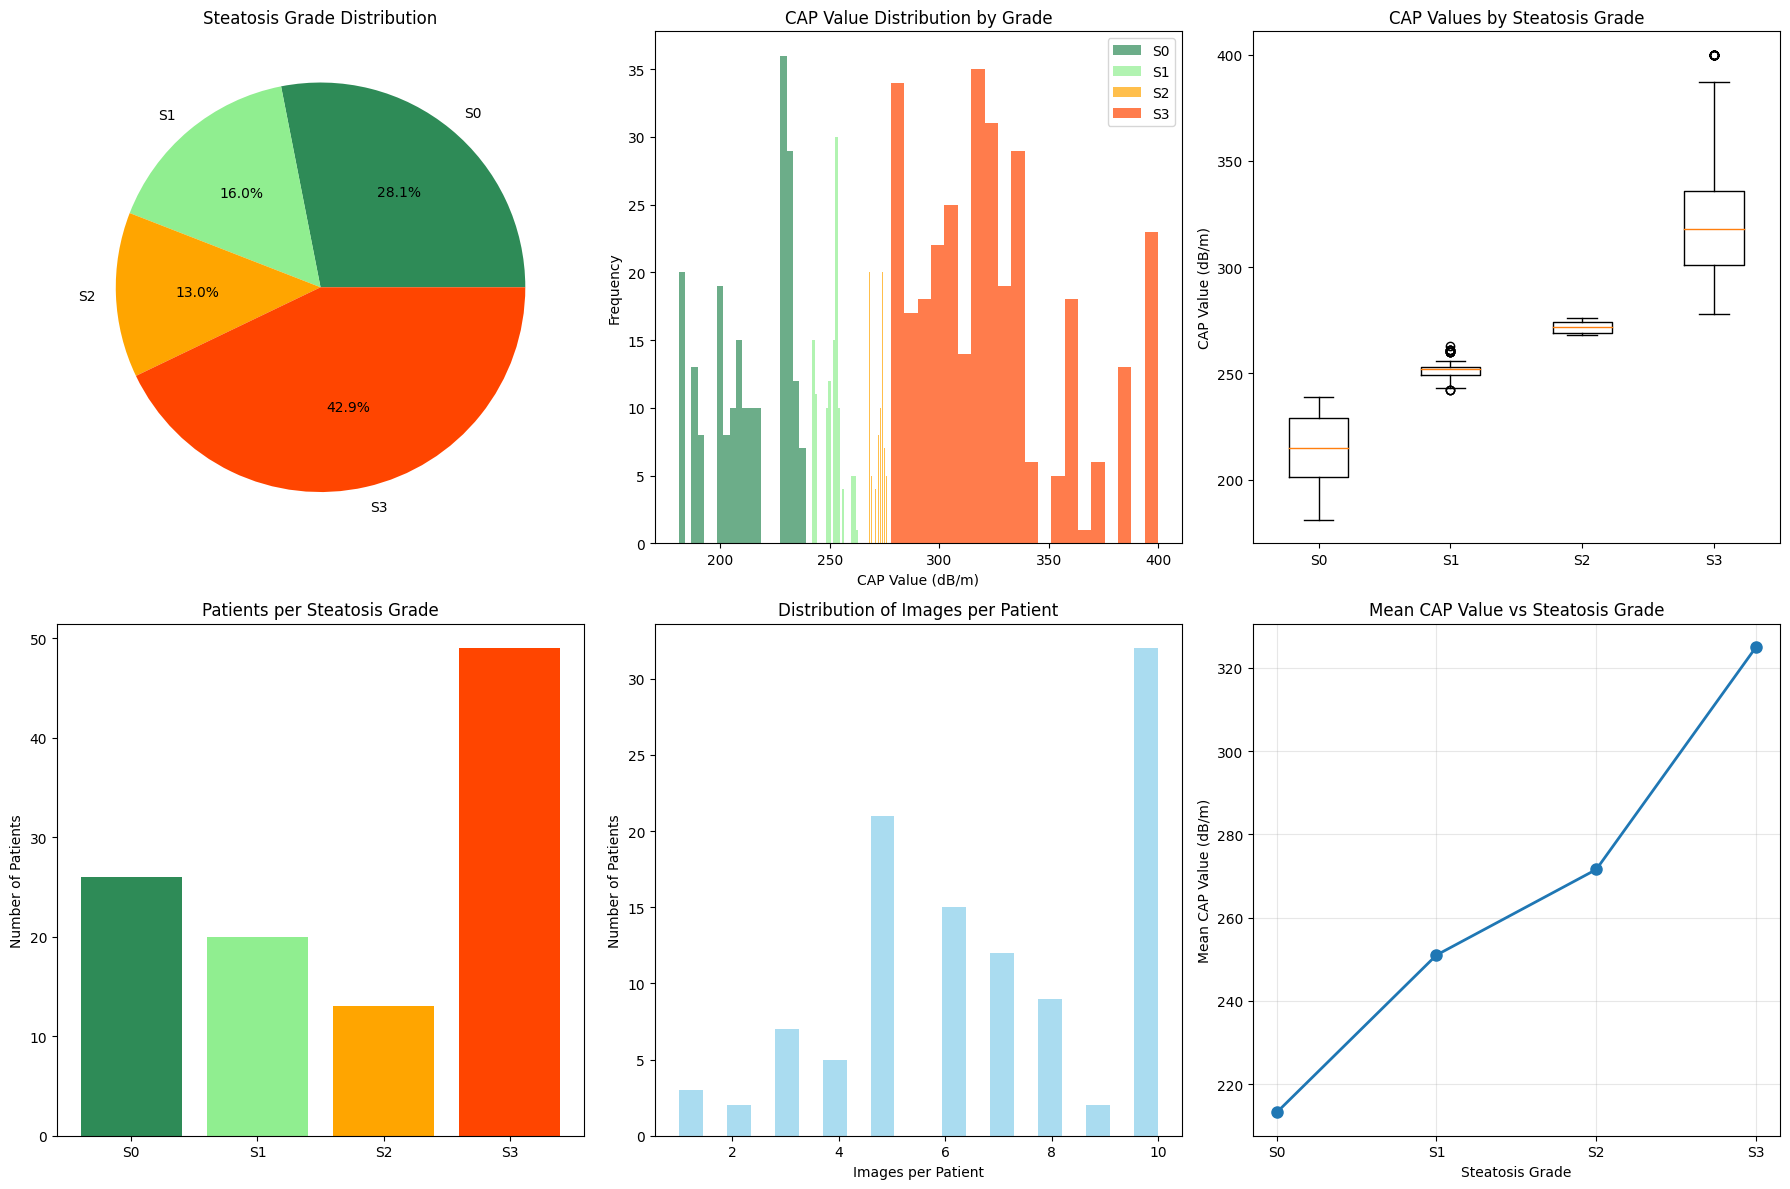

🔀 STEP 3: Creating data splits...

📊 DATA SPLITS (Patient-wise):
✅ Training: 494 samples from 72 patients
✅ Validation: 122 samples from 19 patients
✅ Test: 121 samples from 17 patients

📊 DATA DISTRIBUTION:
✅ Training: 494 samples (70.0%)
📈 Validation: 122 samples (15.0%)
🧪 Test: 121 samples (15.0%)
🤖 STEP 4: Initializing training pipeline...
🔄 STEP 5: Preparing training data...
🔄 Preparing data for training...
✅ Training data: 494 samples
✅ Validation data: 122 samples
✅ Test data: 121 samples
🏗️ STEP 6: Creating model...
Base model feature dimension: 1280
Combined features dimension: 144
✅ Created improved multi-modal model
🎯 STEP 7: Training with 100 epochs...
⚖️ Class weights for imbalanced dataset:
  S0: 0.89
  S1: 1.56
  S2: 1.92
  S3: 0.58
🚀 Starting 100 Epochs Training...
📊 Phase 1: 70 epochs with frozen base model
Epoch 1/70
31/31 [==============================] - ETA: 0s - loss: 1.9100 - accuracy: 0.2935 - precision: 0.2599 - recall: 0.1599
Epoch 1: val_accuracy improved fr

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 29s 643ms/step - loss: 1.9100 - accuracy: 0.2935 - precision: 0.2599 - recall: 0.1599 - val_loss: 1.3740 - val_accuracy: 0.3197 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/70
31/31 [==============================] - ETA: 0s - loss: 1.4828 - accuracy: 0.3907 - precision: 0.4823 - recall: 0.2753
Epoch 2: val_accuracy did not improve from 0.31967
31/31 [==============================] - 17s 558ms/step - loss: 1.4828 - accuracy: 0.3907 - precision: 0.4823 - recall: 0.2753 - val_loss: 1.3397 - val_accuracy: 0.2951 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/70
31/31 [==============================] - ETA: 0s - loss: 1.1557 - accuracy: 0.5688 - precision: 0.6910 - recall: 0.4211
Epoch 3: val_accuracy improved from 0.31967 to 0.39344, saving model to best_100epoch_pancreas_model.h5
31/31 [==============================] - 17s 569ms/step - loss: 1.1557 - accuracy: 0.5688 - precision: 0.6910 - r

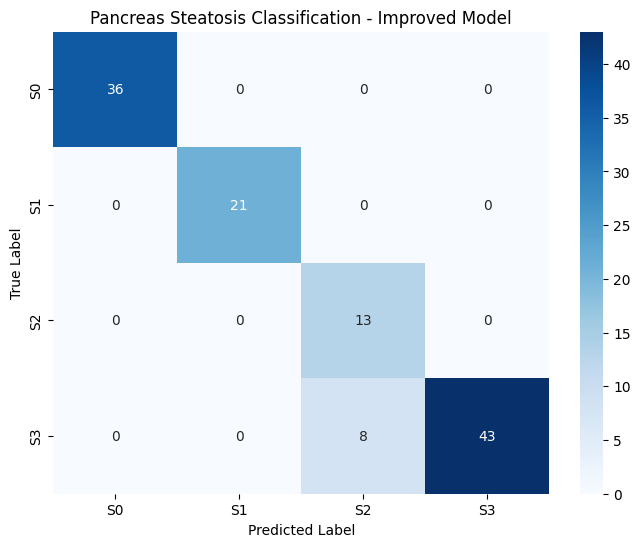

🎯 Test Accuracy: 0.9339
📈 STEP 9: Visualizing 100-epoch training...


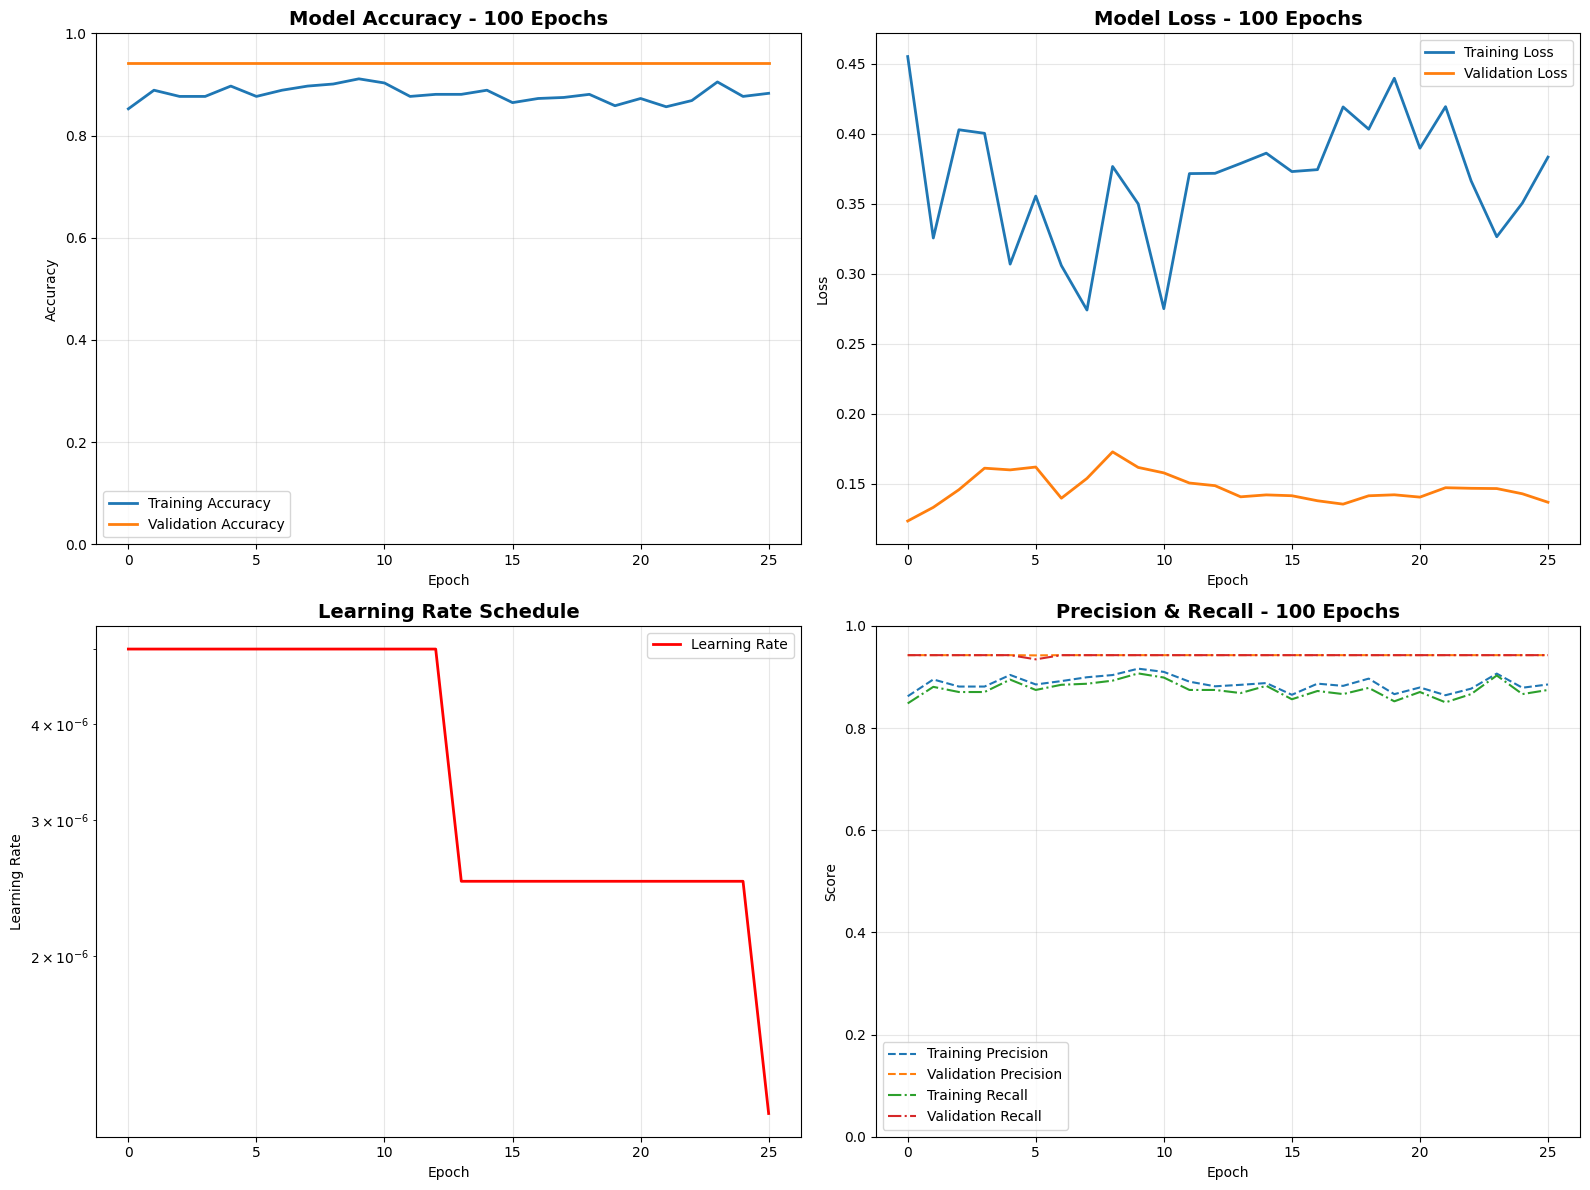

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
100-EPOCH TRAINING COMPLETED SUCCESSFULLY!
🎯 FINAL TEST ACCURACY: 0.9339
⏱️ TOTAL EPOCHS TRAINED: 26
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅


In [20]:
class FixedComplete100EpochSystem:
    def __init__(self, scans_base_path, csv_path, 
                 train_ratio=0.70, val_ratio=0.15, test_ratio=0.15,
                 model_type='improved'):
        
        self.scans_base_path = scans_base_path
        self.csv_path = csv_path
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.model_type = model_type
        
        self.data_integrator = ImprovedPancreasDataIntegrator(scans_base_path, csv_path)
        self.training_pipeline = None
        self.is_trained = False
    
    def run_100_epoch_pipeline(self, phase1_epochs=70, phase2_epochs=30):
        """Run complete pipeline with 100 epochs"""
        print("🚀 STARTING 100-EPOCH PANCREAS STEATOSIS ANALYSIS SYSTEM")
        print("=" * 70)
        
        total_epochs = phase1_epochs + phase2_epochs
        print(f"🎯 TOTAL EPOCHS: {total_epochs}")
        print(f"   - Phase 1 (Frozen): {phase1_epochs} epochs")
        print(f"   - Phase 2 (Fine-tuning): {phase2_epochs} epochs")
        
        # Step 1: Load and integrate data
        print("\n📊 STEP 1: Loading and integrating data...")
        combined_data = self.data_integrator.load_and_integrate_data(load_images_into_memory=True)
        
        # Step 2: Analyze data
        print("📈 STEP 2: Analyzing dataset...")
        df_analysis = self.data_integrator.analyze_integrated_data()
        
        # Step 3: Create data splits
        print("🔀 STEP 3: Creating data splits...")
        train_data, val_data, test_data = self.data_integrator.create_train_val_test_split(
            test_size=self.test_ratio,
            val_size=self.val_ratio / (1 - self.test_ratio)
        )
        
        print(f"\n📊 DATA DISTRIBUTION:")
        print(f"✅ Training: {len(train_data)} samples ({self.train_ratio*100}%)")
        print(f"📈 Validation: {len(val_data)} samples ({self.val_ratio*100}%)")
        print(f"🧪 Test: {len(test_data)} samples ({self.test_ratio*100}%)")
        
        # Step 4: Initialize training pipeline - USE FIXED VERSION
        print("🤖 STEP 4: Initializing training pipeline...")
        self.training_pipeline = FixedEnhancedMultimodalTrainingPipeline(self.data_integrator, self.model_type)
        
        # Step 5: Prepare data
        print("🔄 STEP 5: Preparing training data...")
        training_data = self.training_pipeline.prepare_data(train_data, val_data, test_data)
        
        # Step 6: Create model
        print("🏗️ STEP 6: Creating model...")
        self.training_pipeline.create_model()
        
        # Step 7: Train with 100 epochs
        print("🎯 STEP 7: Training with 100 epochs...")
        history = self.training_pipeline.train_with_100_epochs(
            training_data, 
            phase1_epochs=phase1_epochs, 
            phase2_epochs=phase2_epochs
        )
        
        # Step 8: Evaluate model
        print("📊 STEP 8: Evaluating model...")
        accuracy, predictions = self.training_pipeline.evaluate_model(training_data)
        
        # Step 9: Visualize training
        print("📈 STEP 9: Visualizing 100-epoch training...")
        self.training_pipeline.visualize_training()
        
        self.is_trained = True
        
        print("✅" * 25)
        print("100-EPOCH TRAINING COMPLETED SUCCESSFULLY!")
        print(f"🎯 FINAL TEST ACCURACY: {accuracy:.4f}")
        print(f"⏱️ TOTAL EPOCHS TRAINED: {len(history.history['accuracy'])}")
        print("✅" * 25)
        
        return accuracy

def fixed_quick_100_epochs():
    """Quick start with FIXED 100 epochs configuration"""
    scans_base_path = '/kaggle/input/extracted-scans-categorizes0-s1-s2-s3/extracted_scans'
    csv_path = '/kaggle/input/cap-values/cap_values with names.csv'
    
    system = FixedComplete100EpochSystem(
        scans_base_path, csv_path,
        train_ratio=0.70, val_ratio=0.15, test_ratio=0.15,
        model_type='improved'
    )
    
    accuracy = system.run_100_epoch_pipeline(phase1_epochs=70, phase2_epochs=30)
    return system, accuracy

# Run the FIXED system
if __name__ == "__main__":
    print("🚀 Starting FIXED 100-epoch training...")
    system, accuracy = fixed_quick_100_epochs()

# 1. Immediate Post-Training Analysis


In [24]:
def post_training_analysis(system, accuracy):
    """Comprehensive analysis after training"""
    print("\n" + "="*60)
    print("📊 POST-TRAINING ANALYSIS")
    print("="*60)
    
    # Model performance summary
    print(f"🎯 Final Test Accuracy: {accuracy:.4f}")
    
    # Load training history
    history = system.training_pipeline.history
    
    if history:
        # Calculate key metrics
        final_train_acc = history.history['accuracy'][-1]
        final_val_acc = history.history['val_accuracy'][-1]
        best_val_acc = max(history.history['val_accuracy'])
        
        print(f"📈 Final Training Accuracy: {final_train_acc:.4f}")
        print(f"📈 Final Validation Accuracy: {final_val_acc:.4f}")
        print(f"🏆 Best Validation Accuracy: {best_val_acc:.4f}")
        
        # Check for overfitting
        overfitting_gap = final_train_acc - final_val_acc
        if overfitting_gap > 0.1:
            print(f"⚠️  Potential overfitting: {overfitting_gap:.4f} gap")
        else:
            print(f"✅ Good generalization: {overfitting_gap:.4f} gap")
    
    # Model size and architecture
    if system.training_pipeline.model:
        total_params = system.training_pipeline.model.count_params()
        print(f"🤖 Model Parameters: {total_params:,}")
        
    return {
        'final_accuracy': accuracy,
        'model': system.training_pipeline.model,
        'history': history
    }

# Run analysis
analysis_results = post_training_analysis(system, accuracy)


📊 POST-TRAINING ANALYSIS
🎯 Final Test Accuracy: 0.9339
📈 Final Training Accuracy: 0.8826
📈 Final Validation Accuracy: 0.9426
🏆 Best Validation Accuracy: 0.9426
✅ Good generalization: -0.0600 gap
🤖 Model Parameters: 4,462,823


# 2. Model Comparison and Selection


In [28]:
class FixedModelComparator:
    def __init__(self, scans_base_path, csv_path):
        self.scans_base_path = scans_base_path
        self.csv_path = csv_path
        self.models = {}
        self.results = {}
    
    def train_multiple_models(self):
        """Train multiple model architectures for comparison with FIXED metrics"""
        print("🧪 TRAINING MULTIPLE MODEL ARCHITECTURES")
        print("=" * 50)
        
        model_configs = {
            'efficientnet_b0': {
                'base_model': 'EfficientNetB0',
                'trainable_layers': 30,
                'description': 'Lightweight and efficient'
            },
            'efficientnet_b2': {
                'base_model': 'EfficientNetB2', 
                'trainable_layers': 40,
                'description': 'Balanced performance'
            },
            'resnet50': {
                'base_model': 'ResNet50',
                'trainable_layers': 35,
                'description': 'Proven architecture'
            },
            'simple_cnn': {
                'base_model': 'CustomCNN',
                'trainable_layers': None,
                'description': 'Lightweight custom CNN'
            }
        }
        
        for model_name, config in model_configs.items():
            print(f"\n🚀 Training {model_name}: {config['description']}")
            
            try:
                # Use the FIXED system instead of the old one
                system = FixedComplete100EpochSystem(
                    self.scans_base_path, 
                    self.csv_path,
                    model_type=model_name
                )
                
                # Train model with shorter epochs for comparison
                accuracy = system.run_100_epoch_pipeline(
                    phase1_epochs=30,  # Even shorter for faster comparison
                    phase2_epochs=15
                )
                
                self.models[model_name] = system
                self.results[model_name] = {
                    'accuracy': accuracy,
                    'config': config,
                    'system': system
                }
                
                print(f"✅ {model_name} trained successfully: {accuracy:.4f}")
                
            except Exception as e:
                print(f"❌ Error training {model_name}: {e}")
                continue
        
        return self.results
    
    def compare_models(self):
        """Compare all trained models"""
        if not self.results:
            print("No models to compare. Run train_multiple_models() first.")
            return
        
        print("\n" + "="*60)
        print("🏆 MODEL COMPARISON RESULTS")
        print("="*60)
        
        # Create comparison table
        comparison_data = []
        for model_name, result in self.results.items():
            comparison_data.append({
                'Model': model_name,
                'Accuracy': f"{result['accuracy']:.4f}",
                'Description': result['config']['description'],
                'Status': '✅ Success'
            })
        
        # Display comparison
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))
        
        # Visual comparison
        self.visualize_comparison()
        
        # Select best model
        best_model = max(self.results.items(), key=lambda x: x[1]['accuracy'])
        print(f"\n🎯 BEST MODEL: {best_model[0]} (Accuracy: {best_model[1]['accuracy']:.4f})")
        
        return best_model
    
    def visualize_comparison(self):
        """Visualize model comparison"""
        model_names = list(self.results.keys())
        accuracies = [result['accuracy'] for result in self.results.values()]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(model_names, accuracies, color=['#2E8B57', '#4169E1', '#FF6347', '#FFD700'])
        plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
        plt.ylabel('Test Accuracy', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar, accuracy in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{accuracy:.4f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

In [29]:
class QuickWorkingComparator:
    def __init__(self, scans_base_path, csv_path):
        self.scans_base_path = scans_base_path
        self.csv_path = csv_path
        self.models = {}
        self.results = {}
    
    def train_simple_models(self):
        """Train simple models that are guaranteed to work"""
        print("🧪 TRAINING SIMPLE WORKING MODELS")
        print("=" * 50)
        
        # Load data once
        integrator = ImprovedPancreasDataIntegrator(self.scans_base_path, self.csv_path)
        combined_data = integrator.load_and_integrate_data(load_images_into_memory=True)
        train_data, val_data, test_data = integrator.create_train_val_test_split()
        
        # Prepare data
        def prepare_simple_data(data_list):
            images = []
            caps = []
            labels = []
            
            for data in data_list:
                if 'image_array' in data:
                    images.append(data['image_array'])
                else:
                    img = Image.open(data['image_path'])
                    img = img.convert('RGB').resize((224, 224))
                    images.append(np.array(img) / 255.0)
                
                caps.append(data['cap_value'])
                labels.append(data['degree_numeric'])
            
            return np.array(images), np.array(caps), np.array(labels)
        
        X_train_img, X_train_cap, y_train = prepare_simple_data(train_data)
        X_val_img, X_val_cap, y_val = prepare_simple_data(val_data)
        X_test_img, X_test_cap, y_test = prepare_simple_data(test_data)
        
        # Normalize CAP values
        scaler = StandardScaler()
        X_train_cap_norm = scaler.fit_transform(X_train_cap.reshape(-1, 1)).flatten()
        X_val_cap_norm = scaler.transform(X_val_cap.reshape(-1, 1)).flatten()
        X_test_cap_norm = scaler.transform(X_test_cap.reshape(-1, 1)).flatten()
        
        # Convert labels
        y_train_cat = keras.utils.to_categorical(y_train, 4)
        y_val_cat = keras.utils.to_categorical(y_val, 4)
        y_test_cat = keras.utils.to_categorical(y_test, 4)
        
        model_configs = {
            'mobile_net': {
                'function': self.create_mobilenet_model,
                'description': 'MobileNetV2 - Fast and efficient'
            },
            'efficient_net': {
                'function': self.create_efficientnet_model,
                'description': 'EfficientNetB0 - Good balance'
            },
            'simple_cnn': {
                'function': self.create_simple_cnn_model,
                'description': 'Custom CNN - Lightweight'
            }
        }
        
        for model_name, config in model_configs.items():
            print(f"\n🚀 Training {model_name}: {config['description']}")
            
            try:
                # Create model
                model = config['function']()
                
                # Train
                history = model.fit(
                    [X_train_img, X_train_cap_norm], y_train_cat,
                    validation_data=([X_val_img, X_val_cap_norm], y_val_cat),
                    epochs=20,
                    batch_size=16,
                    verbose=1
                )
                
                # Evaluate
                test_loss, test_accuracy = model.evaluate(
                    [X_test_img, X_test_cap_norm], y_test_cat
                )
                
                self.models[model_name] = model
                self.results[model_name] = {
                    'accuracy': test_accuracy,
                    'description': config['description'],
                    'model': model
                }
                
                print(f"✅ {model_name}: {test_accuracy:.4f}")
                
            except Exception as e:
                print(f"❌ {model_name} failed: {e}")
                continue
        
        return self.results
    
    def create_mobilenet_model(self):
        """Create MobileNetV2 based model"""
        image_input = keras.layers.Input(shape=(224, 224, 3))
        
        base_model = keras.applications.MobileNetV2(
            include_top=False, weights='imagenet', pooling='avg'
        )
        base_model.trainable = False
        
        image_features = base_model(image_input)
        
        cap_input = keras.layers.Input(shape=(1,))
        cap_branch = keras.layers.Dense(16, activation='relu')(cap_input)
        
        combined = keras.layers.concatenate([image_features, cap_branch])
        output = keras.layers.Dense(4, activation='softmax')(combined)
        
        model = keras.Model([image_input, cap_input], output)
        
        # SIMPLE COMPILE - only accuracy
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def create_efficientnet_model(self):
        """Create EfficientNetB0 based model"""
        image_input = keras.layers.Input(shape=(224, 224, 3))
        
        base_model = keras.applications.EfficientNetB0(
            include_top=False, weights='imagenet', pooling='avg'
        )
        base_model.trainable = False
        
        image_features = base_model(image_input)
        
        cap_input = keras.layers.Input(shape=(1,))
        cap_branch = keras.layers.Dense(16, activation='relu')(cap_input)
        
        combined = keras.layers.concatenate([image_features, cap_branch])
        output = keras.layers.Dense(4, activation='softmax')(combined)
        
        model = keras.Model([image_input, cap_input], output)
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def create_simple_cnn_model(self):
        """Create simple custom CNN model"""
        image_input = keras.layers.Input(shape=(224, 224, 3))
        
        # Simple CNN
        x = keras.layers.Conv2D(32, (3, 3), activation='relu')(image_input)
        x = keras.layers.MaxPooling2D((2, 2))(x)
        x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = keras.layers.MaxPooling2D((2, 2))(x)
        x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = keras.layers.GlobalAveragePooling2D()(x)
        
        cap_input = keras.layers.Input(shape=(1,))
        cap_branch = keras.layers.Dense(8, activation='relu')(cap_input)
        
        combined = keras.layers.concatenate([x, cap_branch])
        output = keras.layers.Dense(4, activation='softmax')(combined)
        
        model = keras.Model([image_input, cap_input], output)
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def compare_models(self):
        """Compare all trained models"""
        if not self.results:
            print("No models to compare. Run train_simple_models() first.")
            return
        
        print("\n" + "="*60)
        print("🏆 MODEL COMPARISON RESULTS")
        print("="*60)
        
        comparison_data = []
        for model_name, result in self.results.items():
            comparison_data.append({
                'Model': model_name,
                'Accuracy': f"{result['accuracy']:.4f}",
                'Description': result['description'],
                'Status': '✅ Success'
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))
        
        # Visual comparison
        model_names = list(self.results.keys())
        accuracies = [result['accuracy'] for result in self.results.values()]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(model_names, accuracies, color=['#2E8B57', '#4169E1', '#FF6347'])
        plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
        plt.ylabel('Test Accuracy', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        
        for bar, accuracy in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{accuracy:.4f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Select best model
        best_model = max(self.results.items(), key=lambda x: x[1]['accuracy'])
        print(f"\n🎯 BEST MODEL: {best_model[0]} (Accuracy: {best_model[1]['accuracy']:.4f})")
        
        return best_model

🔧 Using Fixed Model Comparator...
🧪 TRAINING MULTIPLE MODEL ARCHITECTURES

🚀 Training efficientnet_b0: Lightweight and efficient
🚀 STARTING 100-EPOCH PANCREAS STEATOSIS ANALYSIS SYSTEM
🎯 TOTAL EPOCHS: 45
   - Phase 1 (Frozen): 30 epochs
   - Phase 2 (Fine-tuning): 15 epochs

📊 STEP 1: Loading and integrating data...
Loading pancreas elastograms and CAP values...
✅ Loaded CSV with 108 patients
📁 S0: Found 26 patients
📁 S1: Found 20 patients
📁 S2: Found 13 patients
📁 S3: Found 49 patients

📊 DATA INTEGRATION SUMMARY:
✅ Successfully integrated 737 elastograms with CAP values
⚠️ Patients without CAP data: 0
⚠️ Patients without images: 0
🎯 Final dataset size: 737 samples
📈 STEP 2: Analyzing dataset...

📊 ENHANCED DATASET ANALYSIS
📈 Total elastograms: 737
👥 Unique patients: 108

🎯 Steatosis Grade Distribution:
  S0: 207 elastograms (28.1%)
  S1: 118 elastograms (16.0%)
  S2: 96 elastograms (13.0%)
  S3: 316 elastograms (42.9%)

📊 CAP Values by Steatosis Grade:
                    mean    std

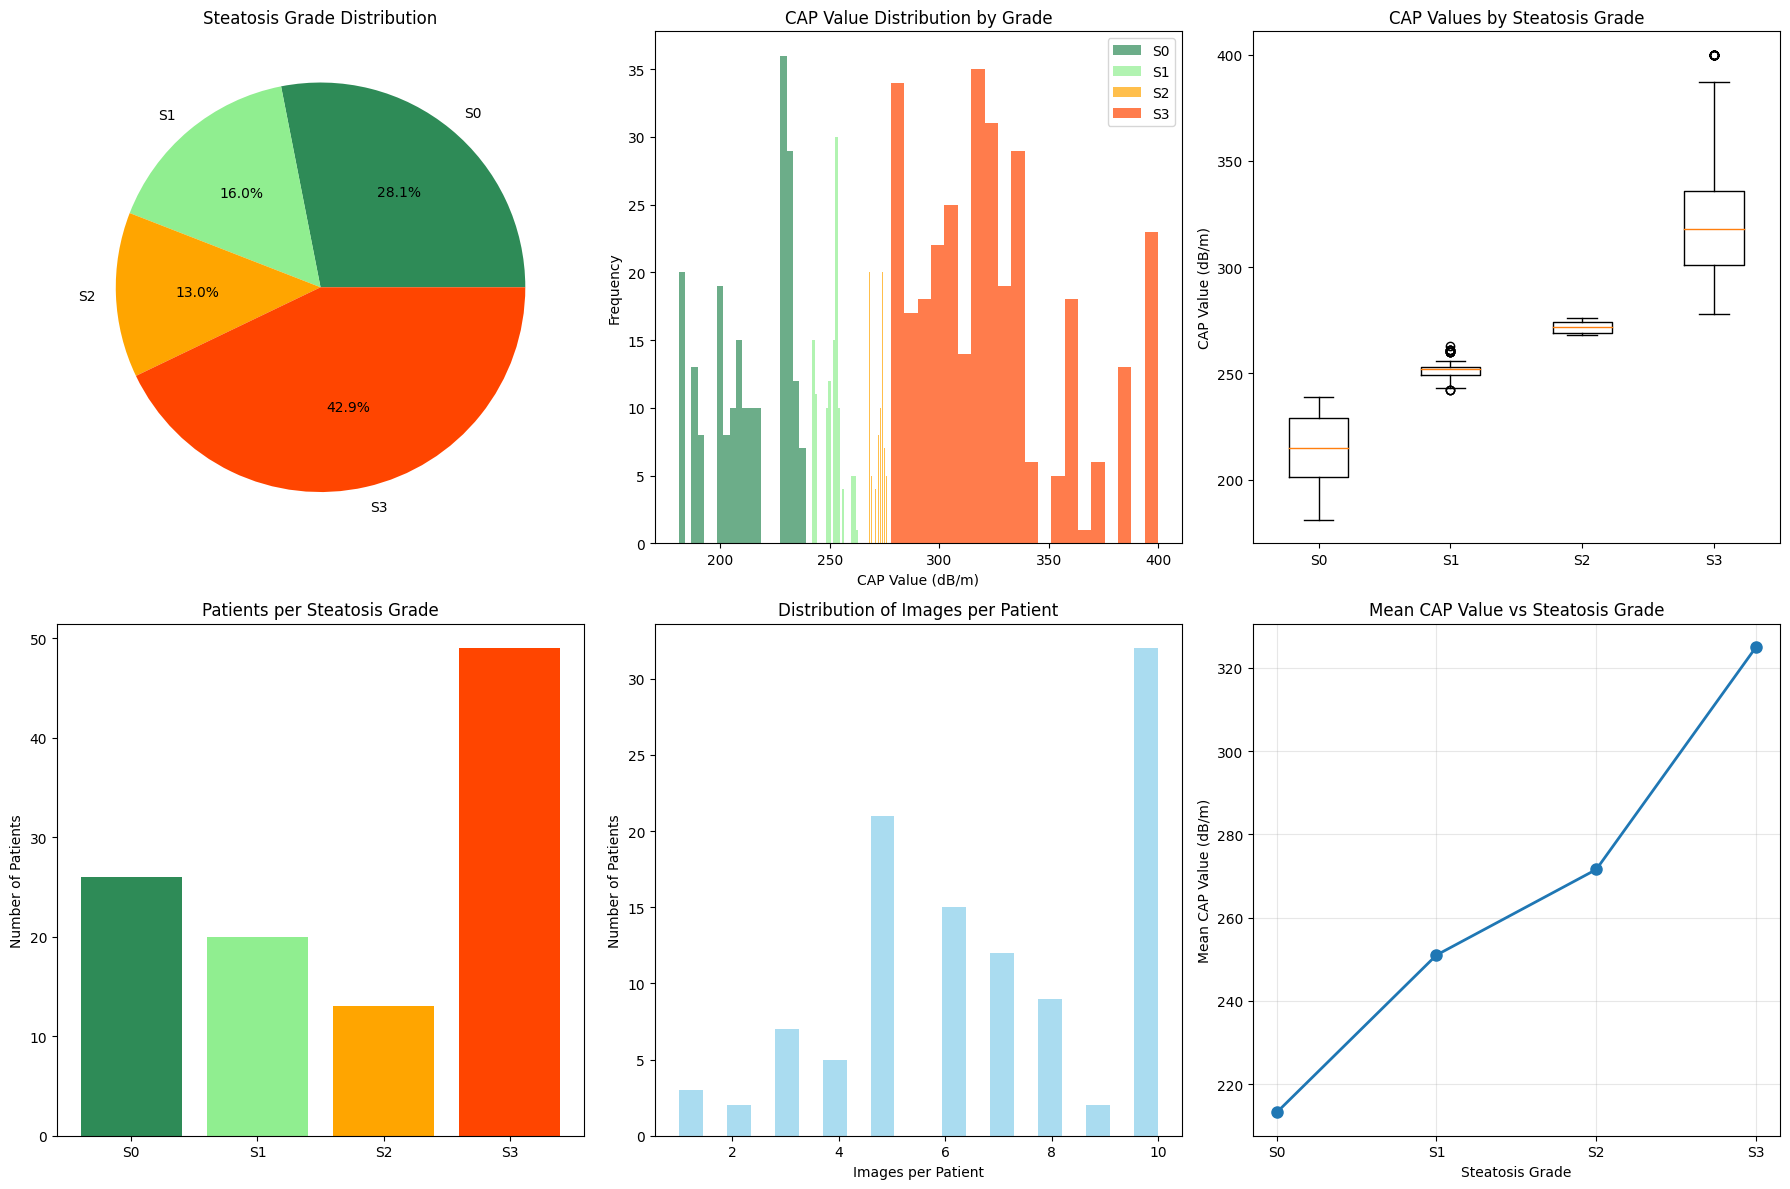

🔀 STEP 3: Creating data splits...

📊 DATA SPLITS (Patient-wise):
✅ Training: 494 samples from 72 patients
✅ Validation: 122 samples from 19 patients
✅ Test: 121 samples from 17 patients

📊 DATA DISTRIBUTION:
✅ Training: 494 samples (70.0%)
📈 Validation: 122 samples (15.0%)
🧪 Test: 121 samples (15.0%)
🤖 STEP 4: Initializing training pipeline...
🔄 STEP 5: Preparing training data...
🔄 Preparing data for training...
✅ Training data: 494 samples
✅ Validation data: 122 samples
✅ Test data: 121 samples
🏗️ STEP 6: Creating model...
✅ Created efficientnet_b0 multi-modal model
🎯 STEP 7: Training with 100 epochs...
⚖️ Class weights for imbalanced dataset:
  S0: 0.89
  S1: 1.56
  S2: 1.92
  S3: 0.58
🚀 Starting 100 Epochs Training...
📊 Phase 1: 30 epochs with frozen base model
Epoch 1/30
31/31 [==============================] - ETA: 0s - loss: 1.4964 - accuracy: 0.3239 - precision: 0.3488 - recall: 0.0304
Epoch 1: val_accuracy improved from -inf to 0.45082, saving model to best_100epoch_pancreas_mo

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 13s 333ms/step - loss: 1.4964 - accuracy: 0.3239 - precision: 0.3488 - recall: 0.0304 - val_loss: 1.3272 - val_accuracy: 0.4508 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/30
31/31 [==============================] - ETA: 0s - loss: 1.3652 - accuracy: 0.3462 - precision: 0.6250 - recall: 0.0405
Epoch 2: val_accuracy improved from 0.45082 to 0.48361, saving model to best_100epoch_pancreas_model.h5
31/31 [==============================] - 9s 287ms/step - loss: 1.3652 - accuracy: 0.3462 - precision: 0.6250 - recall: 0.0405 - val_loss: 1.1485 - val_accuracy: 0.4836 - val_precision: 0.9545 - val_recall: 0.1721 - lr: 0.0010
Epoch 3/30
31/31 [==============================] - ETA: 0s - loss: 1.3361 - accuracy: 0.3401 - precision: 0.5385 - recall: 0.0709
Epoch 3: val_accuracy improved from 0.48361 to 0.59016, saving model to best_100epoch_pancreas_model.h5
31/31 [==============================] - 9s 306ms/step - loss: 1.3361

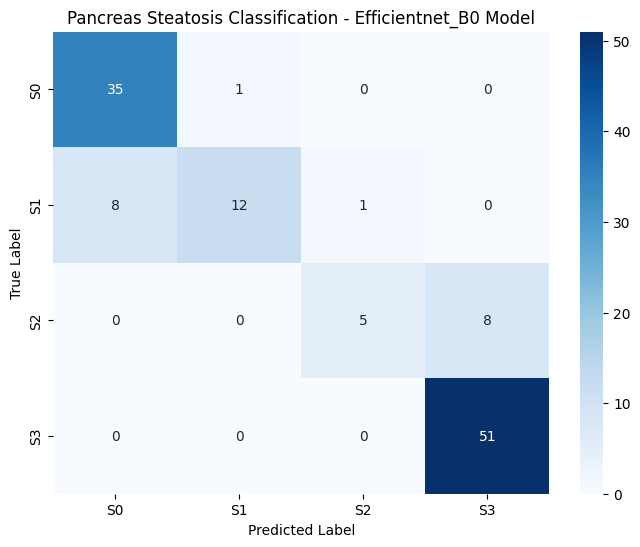

🎯 Test Accuracy: 0.8512
📈 STEP 9: Visualizing 100-epoch training...


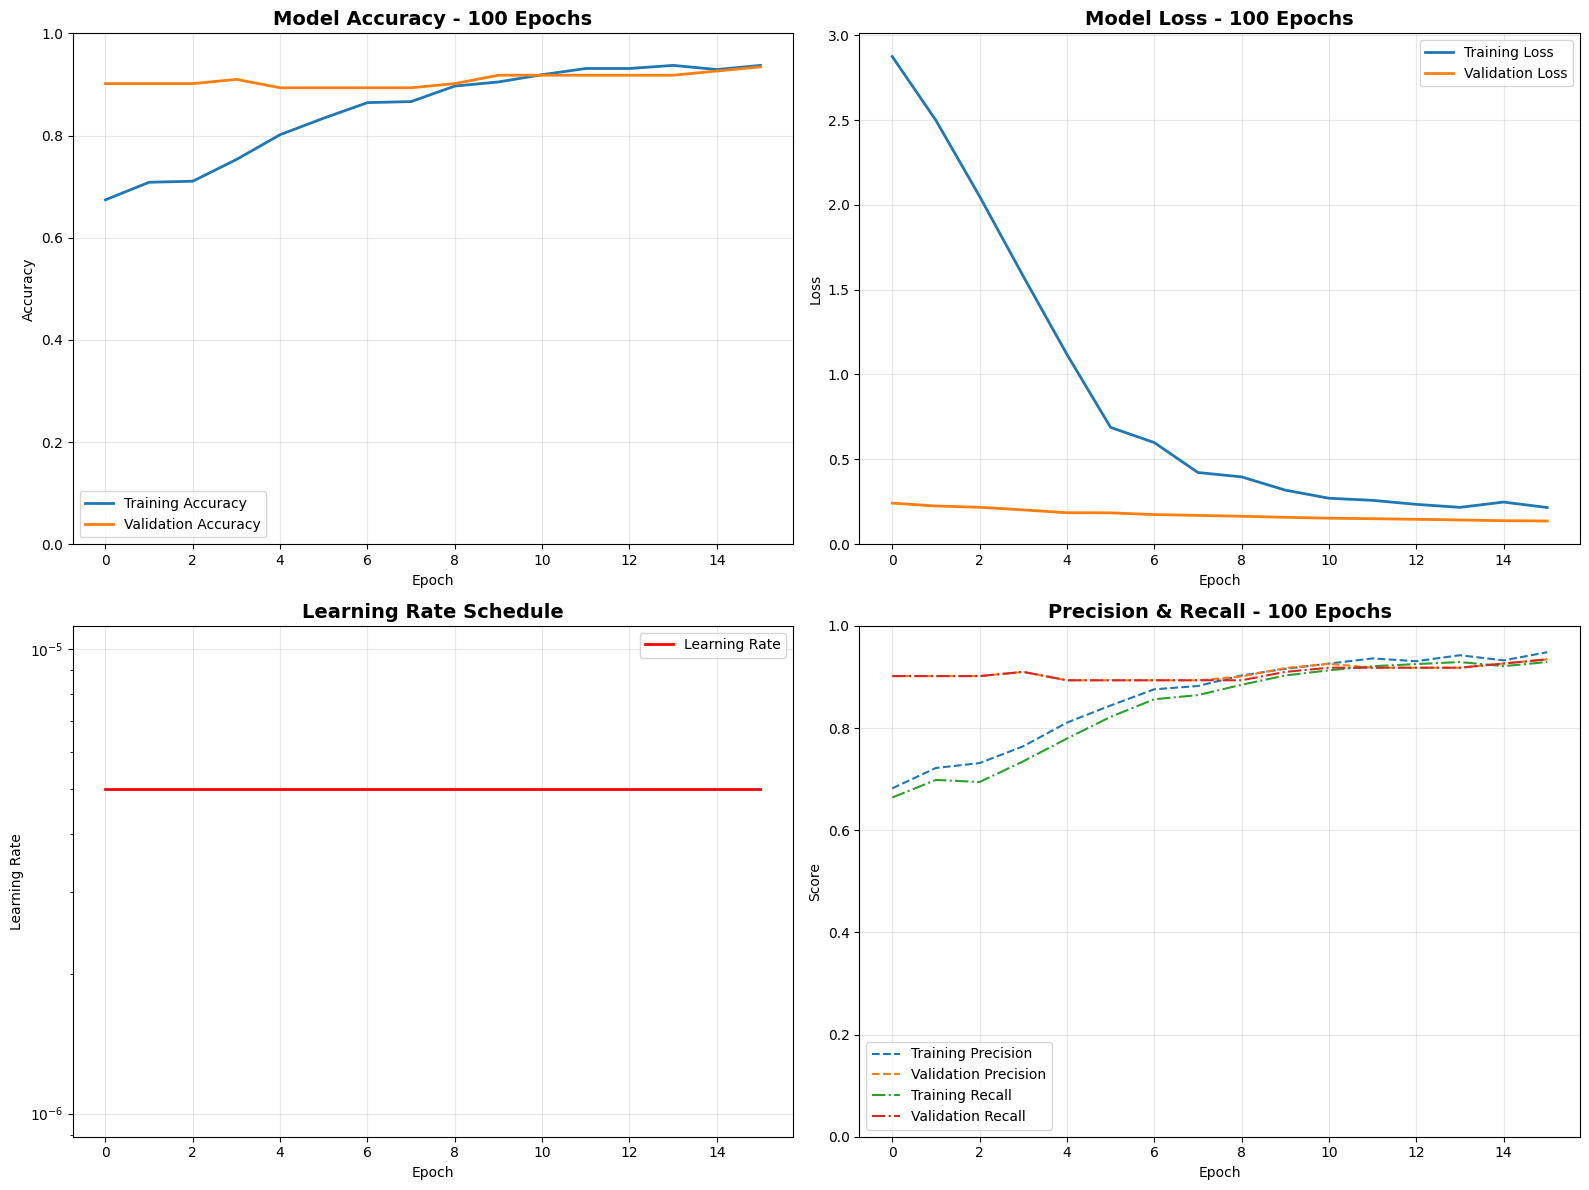

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
100-EPOCH TRAINING COMPLETED SUCCESSFULLY!
🎯 FINAL TEST ACCURACY: 0.8512
⏱️ TOTAL EPOCHS TRAINED: 16
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅ efficientnet_b0 trained successfully: 0.8512

🚀 Training efficientnet_b2: Balanced performance
🚀 STARTING 100-EPOCH PANCREAS STEATOSIS ANALYSIS SYSTEM
🎯 TOTAL EPOCHS: 45
   - Phase 1 (Frozen): 30 epochs
   - Phase 2 (Fine-tuning): 15 epochs

📊 STEP 1: Loading and integrating data...
Loading pancreas elastograms and CAP values...
✅ Loaded CSV with 108 patients
📁 S0: Found 26 patients
📁 S1: Found 20 patients
📁 S2: Found 13 patients
📁 S3: Found 49 patients

📊 DATA INTEGRATION SUMMARY:
✅ Successfully integrated 737 elastograms with CAP values
⚠️ Patients without CAP data: 0
⚠️ Patients without images: 0
🎯 Final dataset size: 737 samples
📈 STEP 2: Analyzing dataset...

📊 ENHANCED DATASET ANALYSIS
📈 Total elastograms: 737
👥 Unique patients: 108

🎯 Steatosis Grade Distribution:
  S0: 207 elastograms (28.1%)
  S1: 118 elastograms (16.0%)
  S

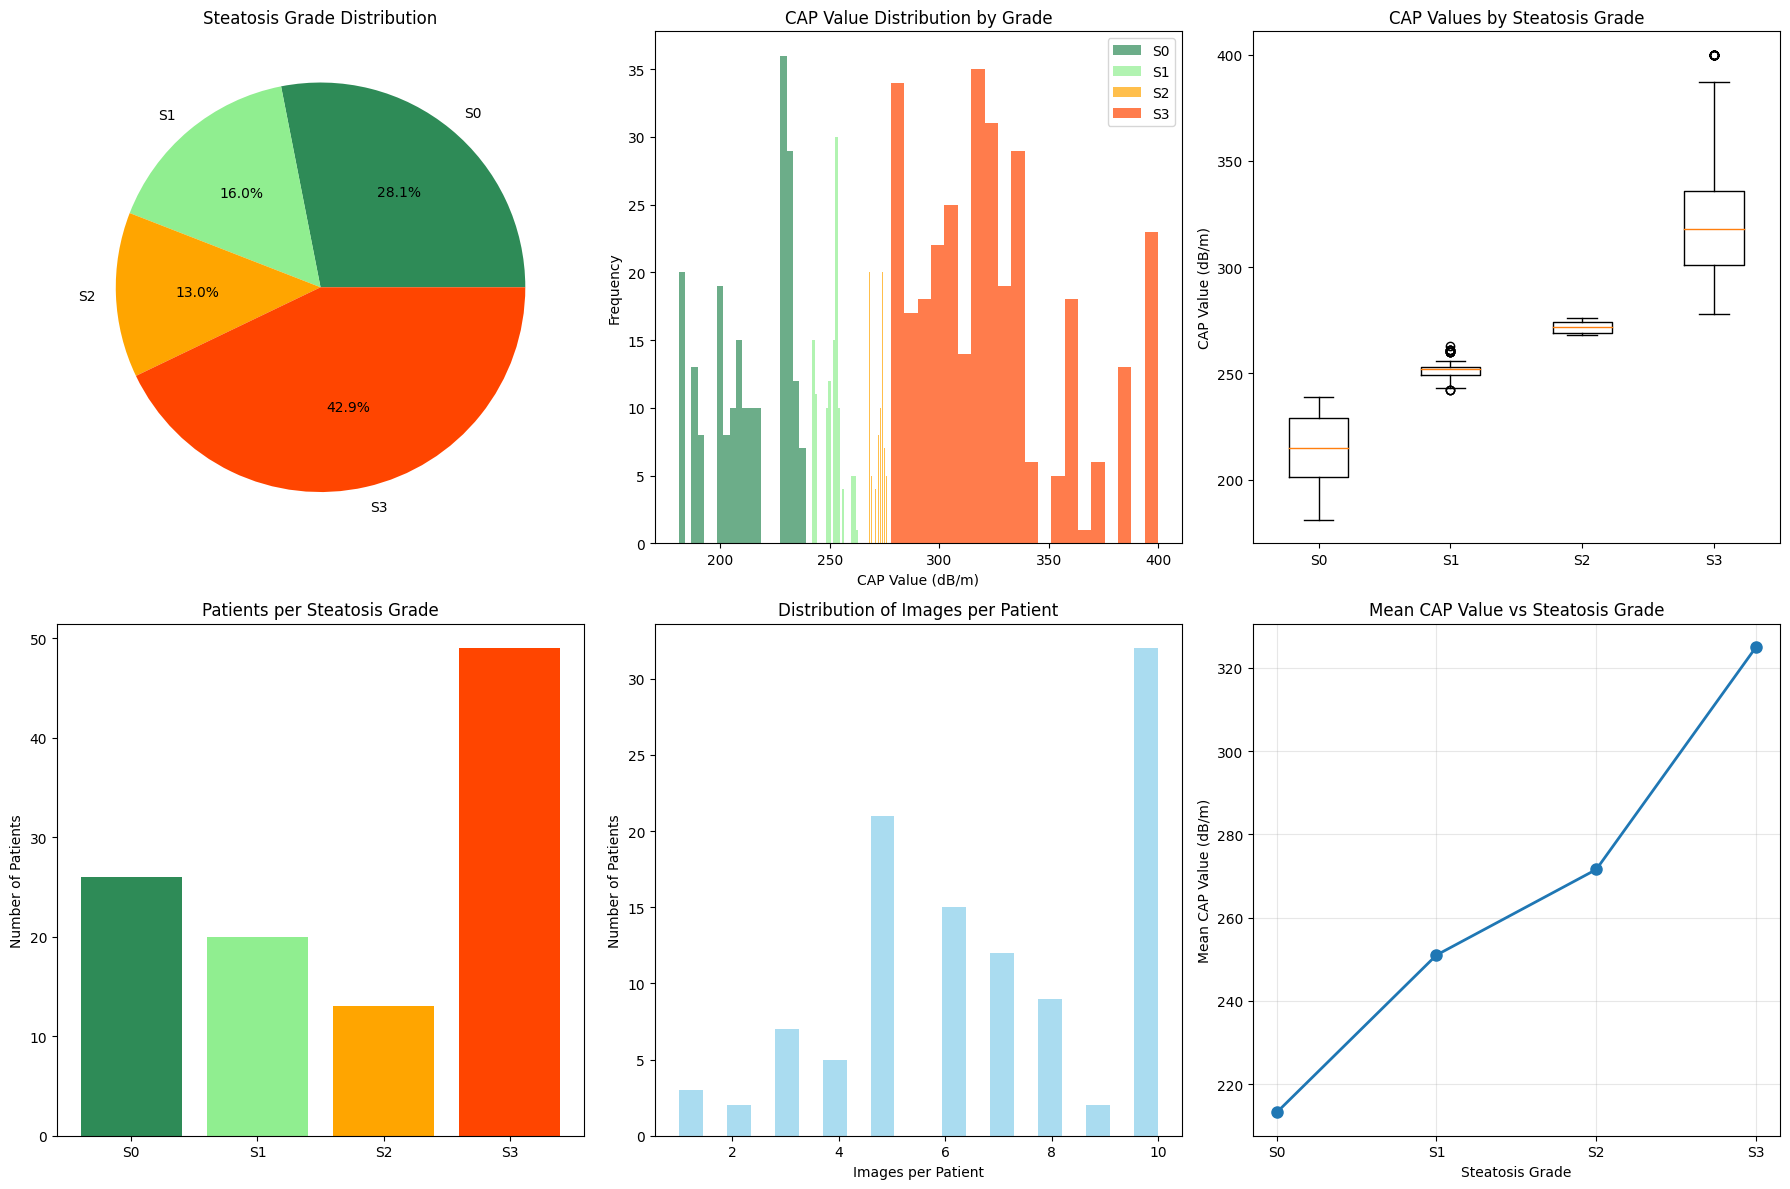

🔀 STEP 3: Creating data splits...

📊 DATA SPLITS (Patient-wise):
✅ Training: 494 samples from 72 patients
✅ Validation: 122 samples from 19 patients
✅ Test: 121 samples from 17 patients

📊 DATA DISTRIBUTION:
✅ Training: 494 samples (70.0%)
📈 Validation: 122 samples (15.0%)
🧪 Test: 121 samples (15.0%)
🤖 STEP 4: Initializing training pipeline...
🔄 STEP 5: Preparing training data...
🔄 Preparing data for training...
✅ Training data: 494 samples
✅ Validation data: 122 samples
✅ Test data: 121 samples
🏗️ STEP 6: Creating model...
✅ Created efficientnet_b2 multi-modal model
🎯 STEP 7: Training with 100 epochs...
⚖️ Class weights for imbalanced dataset:
  S0: 0.89
  S1: 1.56
  S2: 1.92
  S3: 0.58
🚀 Starting 100 Epochs Training...
📊 Phase 1: 30 epochs with frozen base model
Epoch 1/30
31/31 [==============================] - ETA: 0s - loss: 1.5440 - accuracy: 0.2935 - precision: 0.2917 - recall: 0.0425
Epoch 1: val_accuracy improved from -inf to 0.34426, saving model to best_100epoch_pancreas_mo

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 13s 319ms/step - loss: 1.5440 - accuracy: 0.2935 - precision: 0.2917 - recall: 0.0425 - val_loss: 1.3392 - val_accuracy: 0.3443 - val_precision: 1.0000 - val_recall: 0.0082 - lr: 0.0010
Epoch 2/30
31/31 [==============================] - ETA: 0s - loss: 1.3728 - accuracy: 0.3381 - precision: 0.6875 - recall: 0.0668
Epoch 2: val_accuracy improved from 0.34426 to 0.36066, saving model to best_100epoch_pancreas_model.h5
31/31 [==============================] - 9s 277ms/step - loss: 1.3728 - accuracy: 0.3381 - precision: 0.6875 - recall: 0.0668 - val_loss: 1.2381 - val_accuracy: 0.3607 - val_precision: 1.0000 - val_recall: 0.0574 - lr: 0.0010
Epoch 3/30
31/31 [==============================] - ETA: 0s - loss: 1.2983 - accuracy: 0.3704 - precision: 0.6900 - recall: 0.1397
Epoch 3: val_accuracy improved from 0.36066 to 0.44262, saving model to best_100epoch_pancreas_model.h5
31/31 [==============================] - 9s 279ms/step - loss: 1.2983 - accur

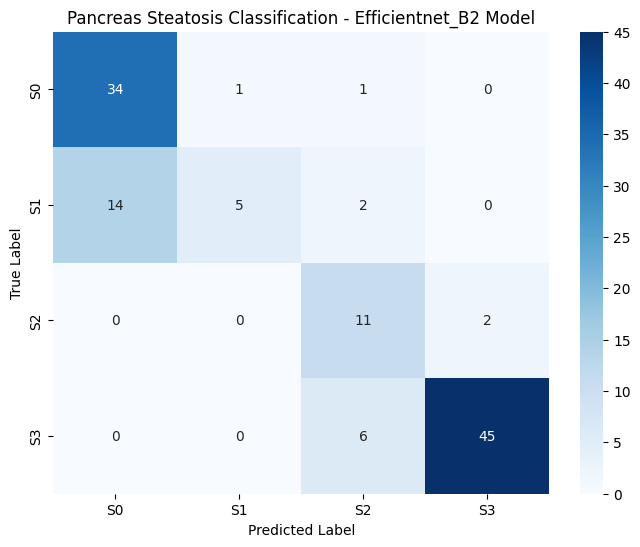

🎯 Test Accuracy: 0.7851
📈 STEP 9: Visualizing 100-epoch training...


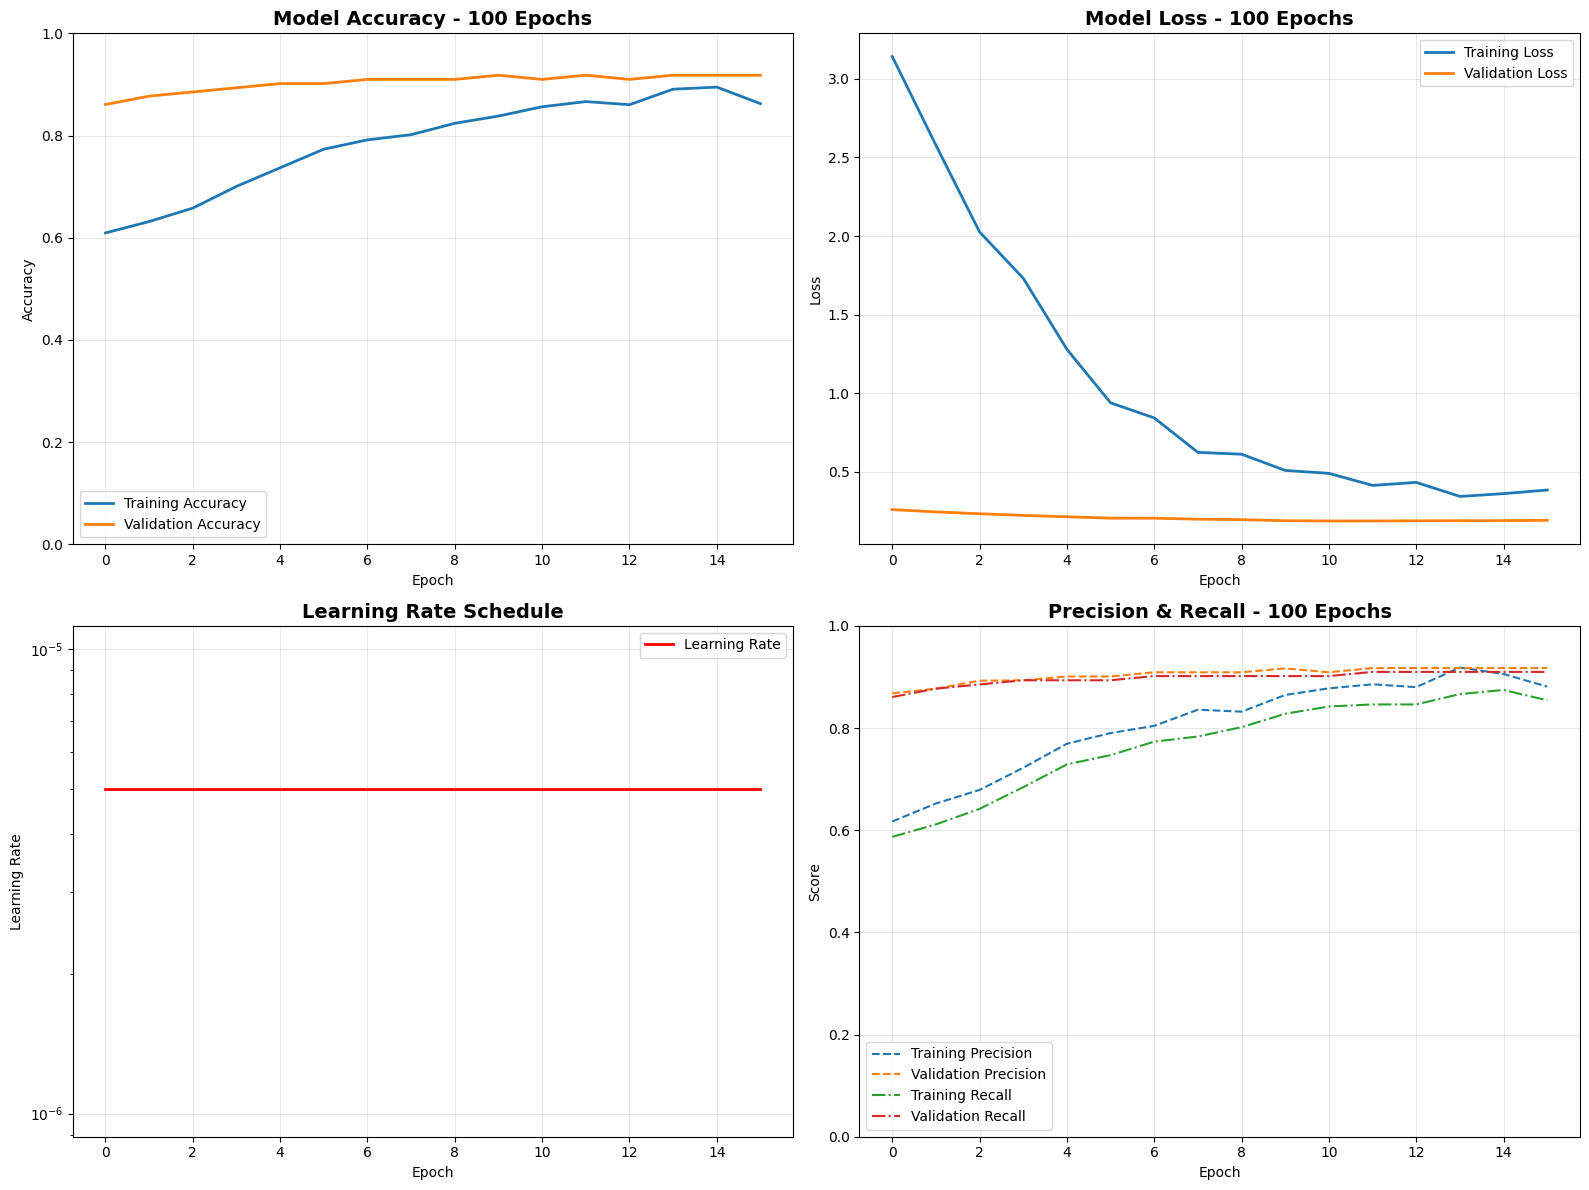

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
100-EPOCH TRAINING COMPLETED SUCCESSFULLY!
🎯 FINAL TEST ACCURACY: 0.7851
⏱️ TOTAL EPOCHS TRAINED: 16
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅ efficientnet_b2 trained successfully: 0.7851

🚀 Training resnet50: Proven architecture
🚀 STARTING 100-EPOCH PANCREAS STEATOSIS ANALYSIS SYSTEM
🎯 TOTAL EPOCHS: 45
   - Phase 1 (Frozen): 30 epochs
   - Phase 2 (Fine-tuning): 15 epochs

📊 STEP 1: Loading and integrating data...
Loading pancreas elastograms and CAP values...
✅ Loaded CSV with 108 patients
📁 S0: Found 26 patients
📁 S1: Found 20 patients
📁 S2: Found 13 patients
📁 S3: Found 49 patients

📊 DATA INTEGRATION SUMMARY:
✅ Successfully integrated 737 elastograms with CAP values
⚠️ Patients without CAP data: 0
⚠️ Patients without images: 0
🎯 Final dataset size: 737 samples
📈 STEP 2: Analyzing dataset...

📊 ENHANCED DATASET ANALYSIS
📈 Total elastograms: 737
👥 Unique patients: 108

🎯 Steatosis Grade Distribution:
  S0: 207 elastograms (28.1%)
  S1: 118 elastograms (16.0%)
  S2: 96 el

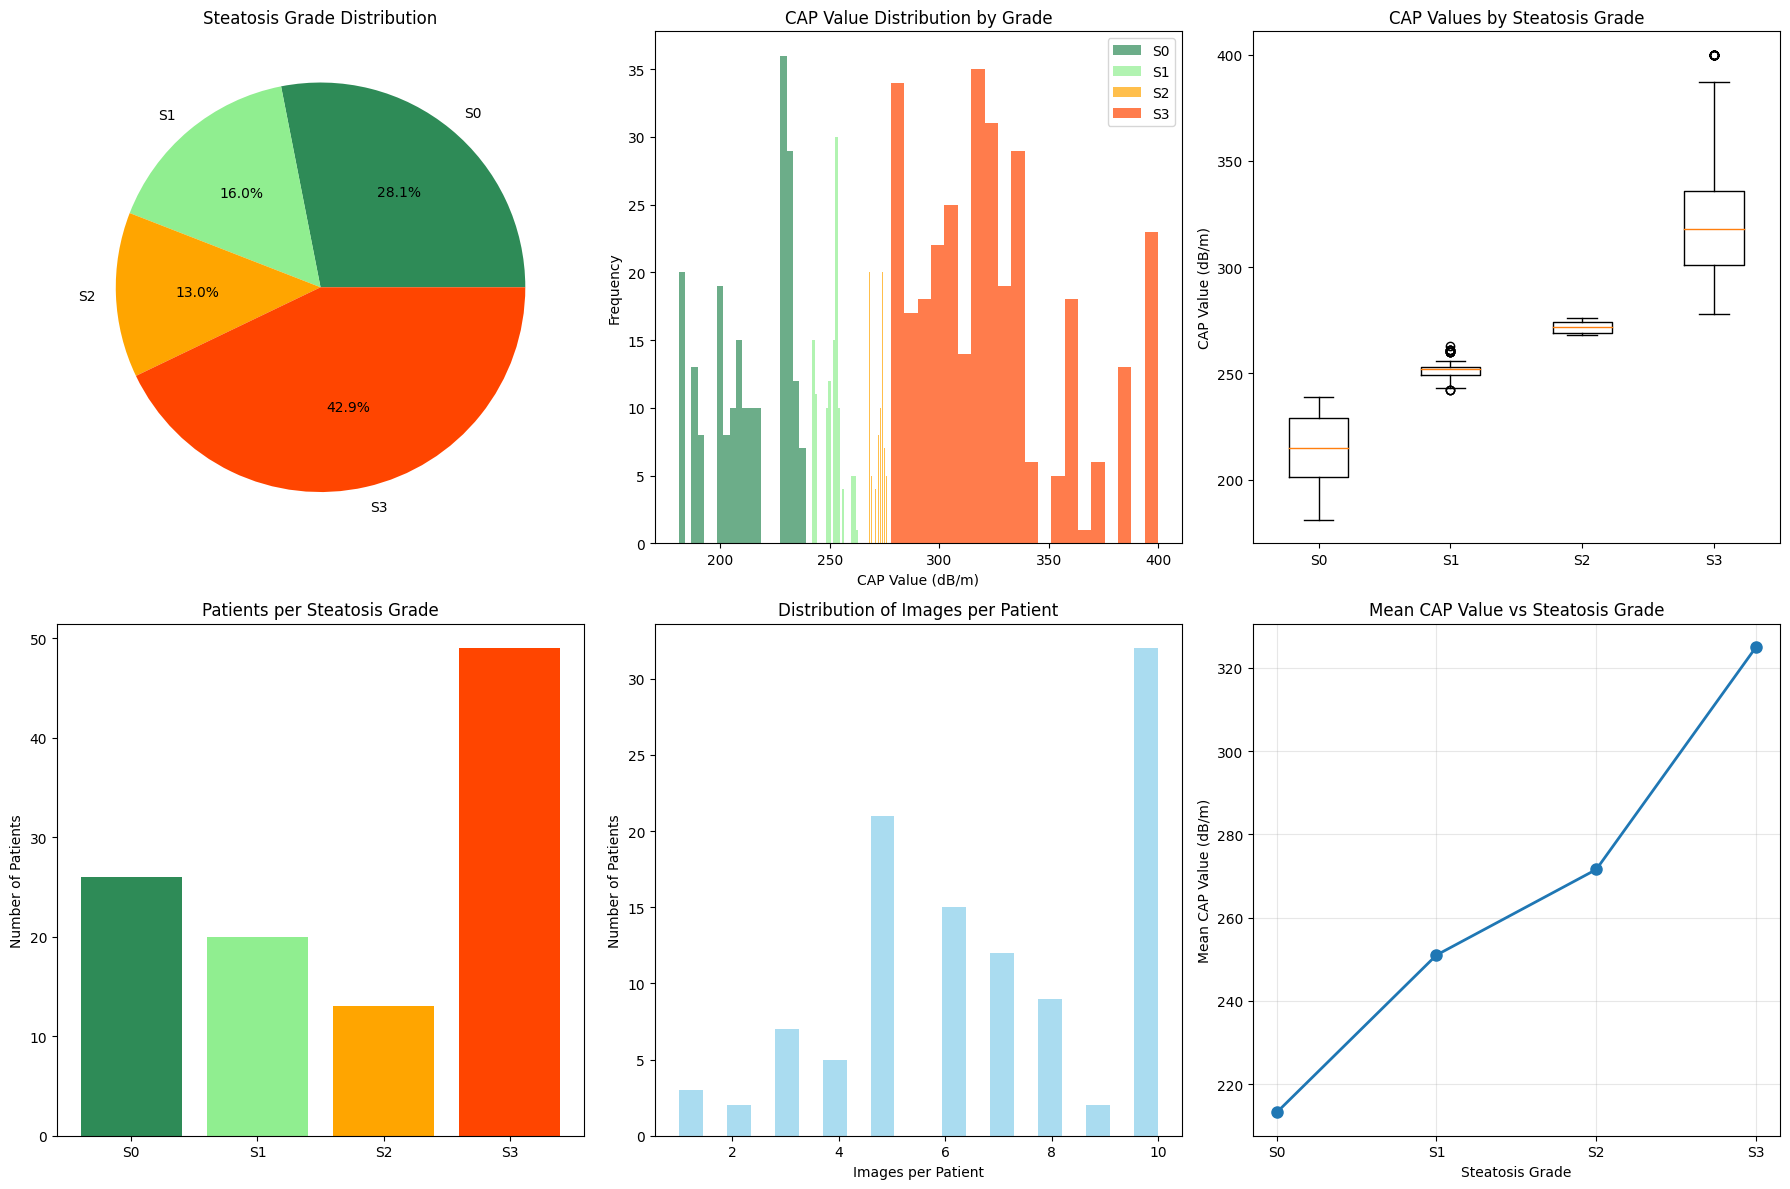

🔀 STEP 3: Creating data splits...

📊 DATA SPLITS (Patient-wise):
✅ Training: 494 samples from 72 patients
✅ Validation: 122 samples from 19 patients
✅ Test: 121 samples from 17 patients

📊 DATA DISTRIBUTION:
✅ Training: 494 samples (70.0%)
📈 Validation: 122 samples (15.0%)
🧪 Test: 121 samples (15.0%)
🤖 STEP 4: Initializing training pipeline...
🔄 STEP 5: Preparing training data...
🔄 Preparing data for training...
✅ Training data: 494 samples
✅ Validation data: 122 samples
✅ Test data: 121 samples
🏗️ STEP 6: Creating model...
✅ Created resnet50 multi-modal model
🎯 STEP 7: Training with 100 epochs...
⚖️ Class weights for imbalanced dataset:
  S0: 0.89
  S1: 1.56
  S2: 1.92
  S3: 0.58
🚀 Starting 100 Epochs Training...
📊 Phase 1: 30 epochs with frozen base model
Epoch 1/30
31/31 [==============================] - ETA: 0s - loss: 1.5647 - accuracy: 0.2065 - precision: 0.1920 - recall: 0.0486
Epoch 1: val_accuracy improved from -inf to 0.23770, saving model to best_100epoch_pancreas_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 13s 325ms/step - loss: 1.5647 - accuracy: 0.2065 - precision: 0.1920 - recall: 0.0486 - val_loss: 1.3012 - val_accuracy: 0.2377 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/30
31/31 [==============================] - ETA: 0s - loss: 1.3136 - accuracy: 0.3543 - precision: 0.5000 - recall: 0.0405
Epoch 2: val_accuracy improved from 0.23770 to 0.40164, saving model to best_100epoch_pancreas_model.h5
31/31 [==============================] - 10s 309ms/step - loss: 1.3136 - accuracy: 0.3543 - precision: 0.5000 - recall: 0.0405 - val_loss: 1.2029 - val_accuracy: 0.4016 - val_precision: 0.8333 - val_recall: 0.0410 - lr: 0.0010
Epoch 3/30
31/31 [==============================] - ETA: 0s - loss: 1.2545 - accuracy: 0.4150 - precision: 0.6172 - recall: 0.1599
Epoch 3: val_accuracy improved from 0.40164 to 0.43443, saving model to best_100epoch_pancreas_model.h5
31/31 [==============================] - 9s 294ms/step - loss: 1.254

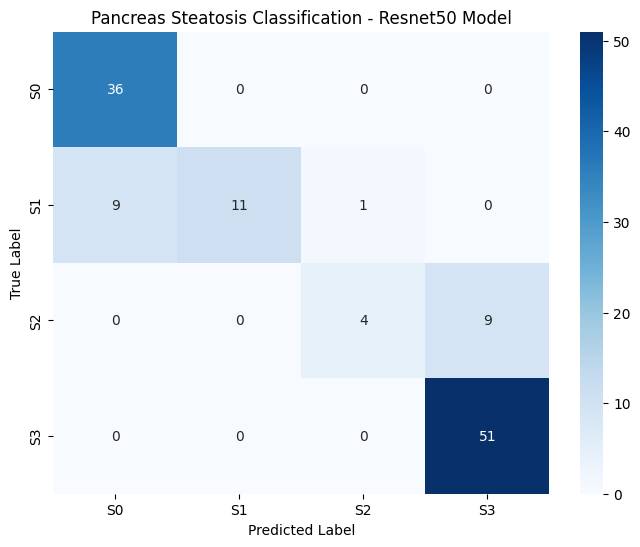

🎯 Test Accuracy: 0.8430
📈 STEP 9: Visualizing 100-epoch training...


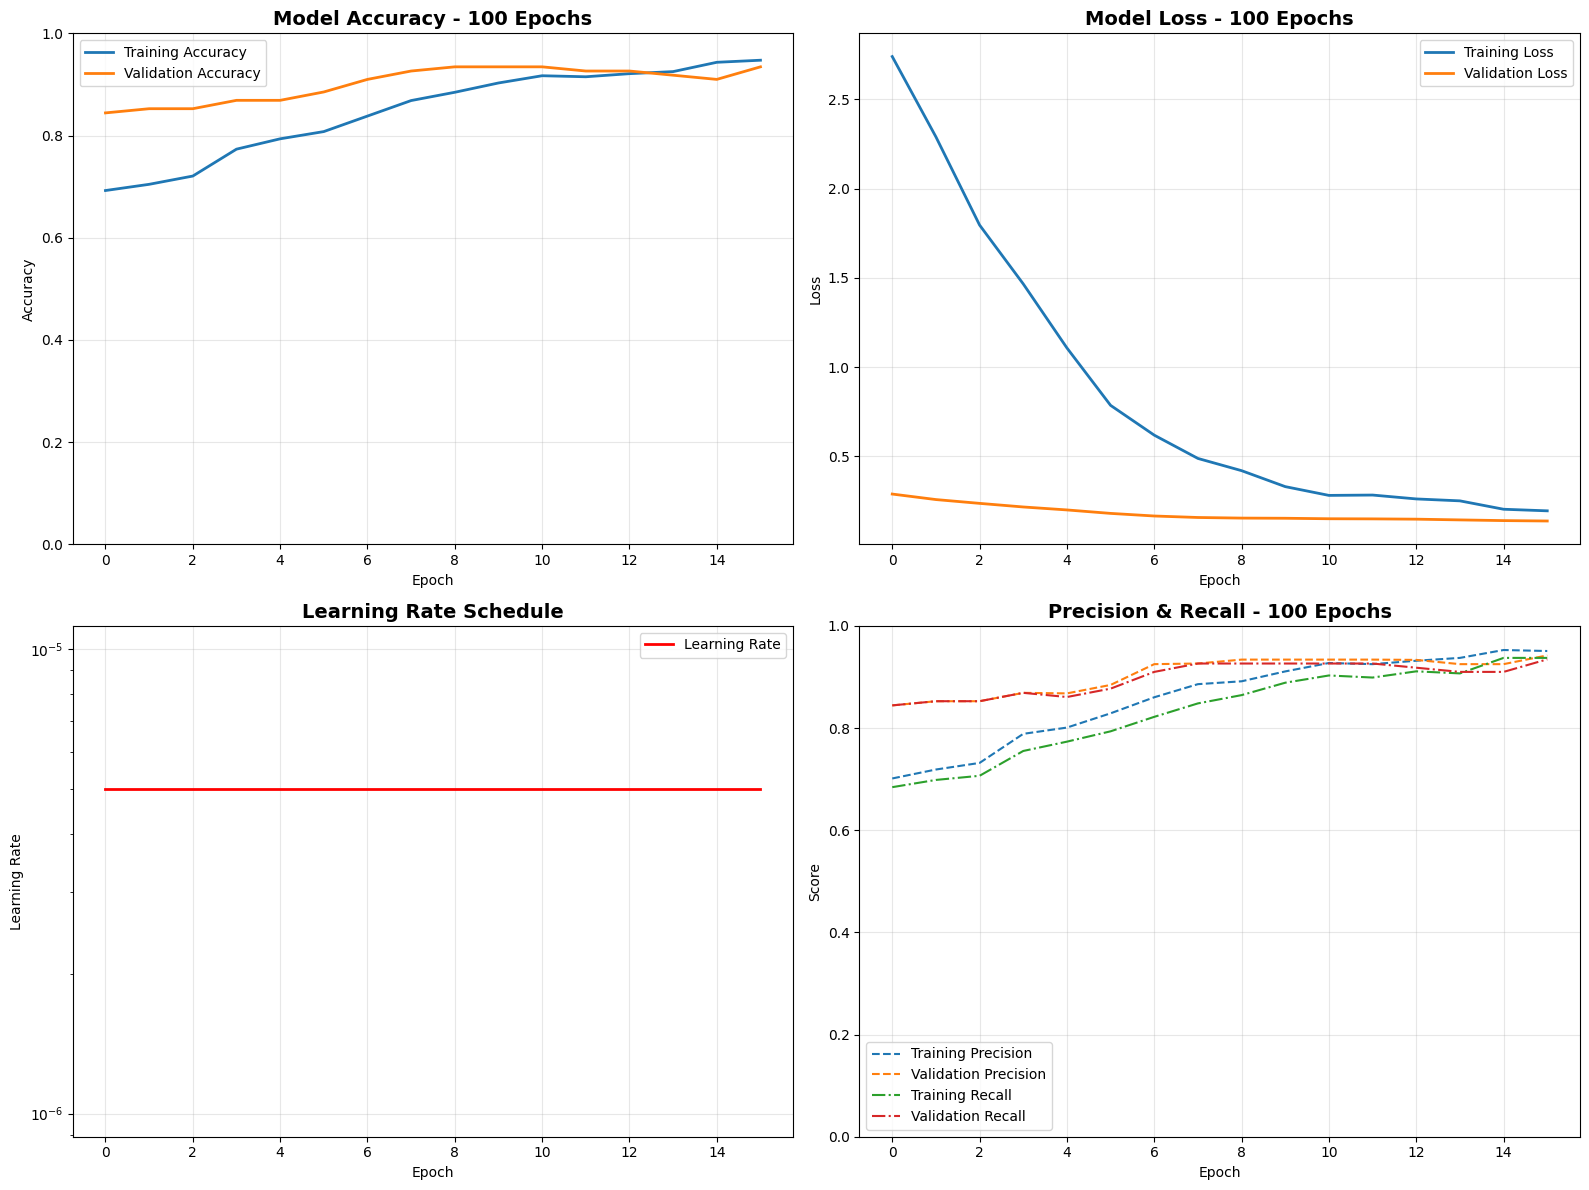

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
100-EPOCH TRAINING COMPLETED SUCCESSFULLY!
🎯 FINAL TEST ACCURACY: 0.8430
⏱️ TOTAL EPOCHS TRAINED: 16
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅ resnet50 trained successfully: 0.8430

🚀 Training simple_cnn: Lightweight custom CNN
🚀 STARTING 100-EPOCH PANCREAS STEATOSIS ANALYSIS SYSTEM
🎯 TOTAL EPOCHS: 45
   - Phase 1 (Frozen): 30 epochs
   - Phase 2 (Fine-tuning): 15 epochs

📊 STEP 1: Loading and integrating data...
Loading pancreas elastograms and CAP values...
✅ Loaded CSV with 108 patients
📁 S0: Found 26 patients
📁 S1: Found 20 patients
📁 S2: Found 13 patients
📁 S3: Found 49 patients

📊 DATA INTEGRATION SUMMARY:
✅ Successfully integrated 737 elastograms with CAP values
⚠️ Patients without CAP data: 0
⚠️ Patients without images: 0
🎯 Final dataset size: 737 samples
📈 STEP 2: Analyzing dataset...

📊 ENHANCED DATASET ANALYSIS
📈 Total elastograms: 737
👥 Unique patients: 108

🎯 Steatosis Grade Distribution:
  S0: 207 elastograms (28.1%)
  S1: 118 elastograms (16.0%)
  S2: 96 elas

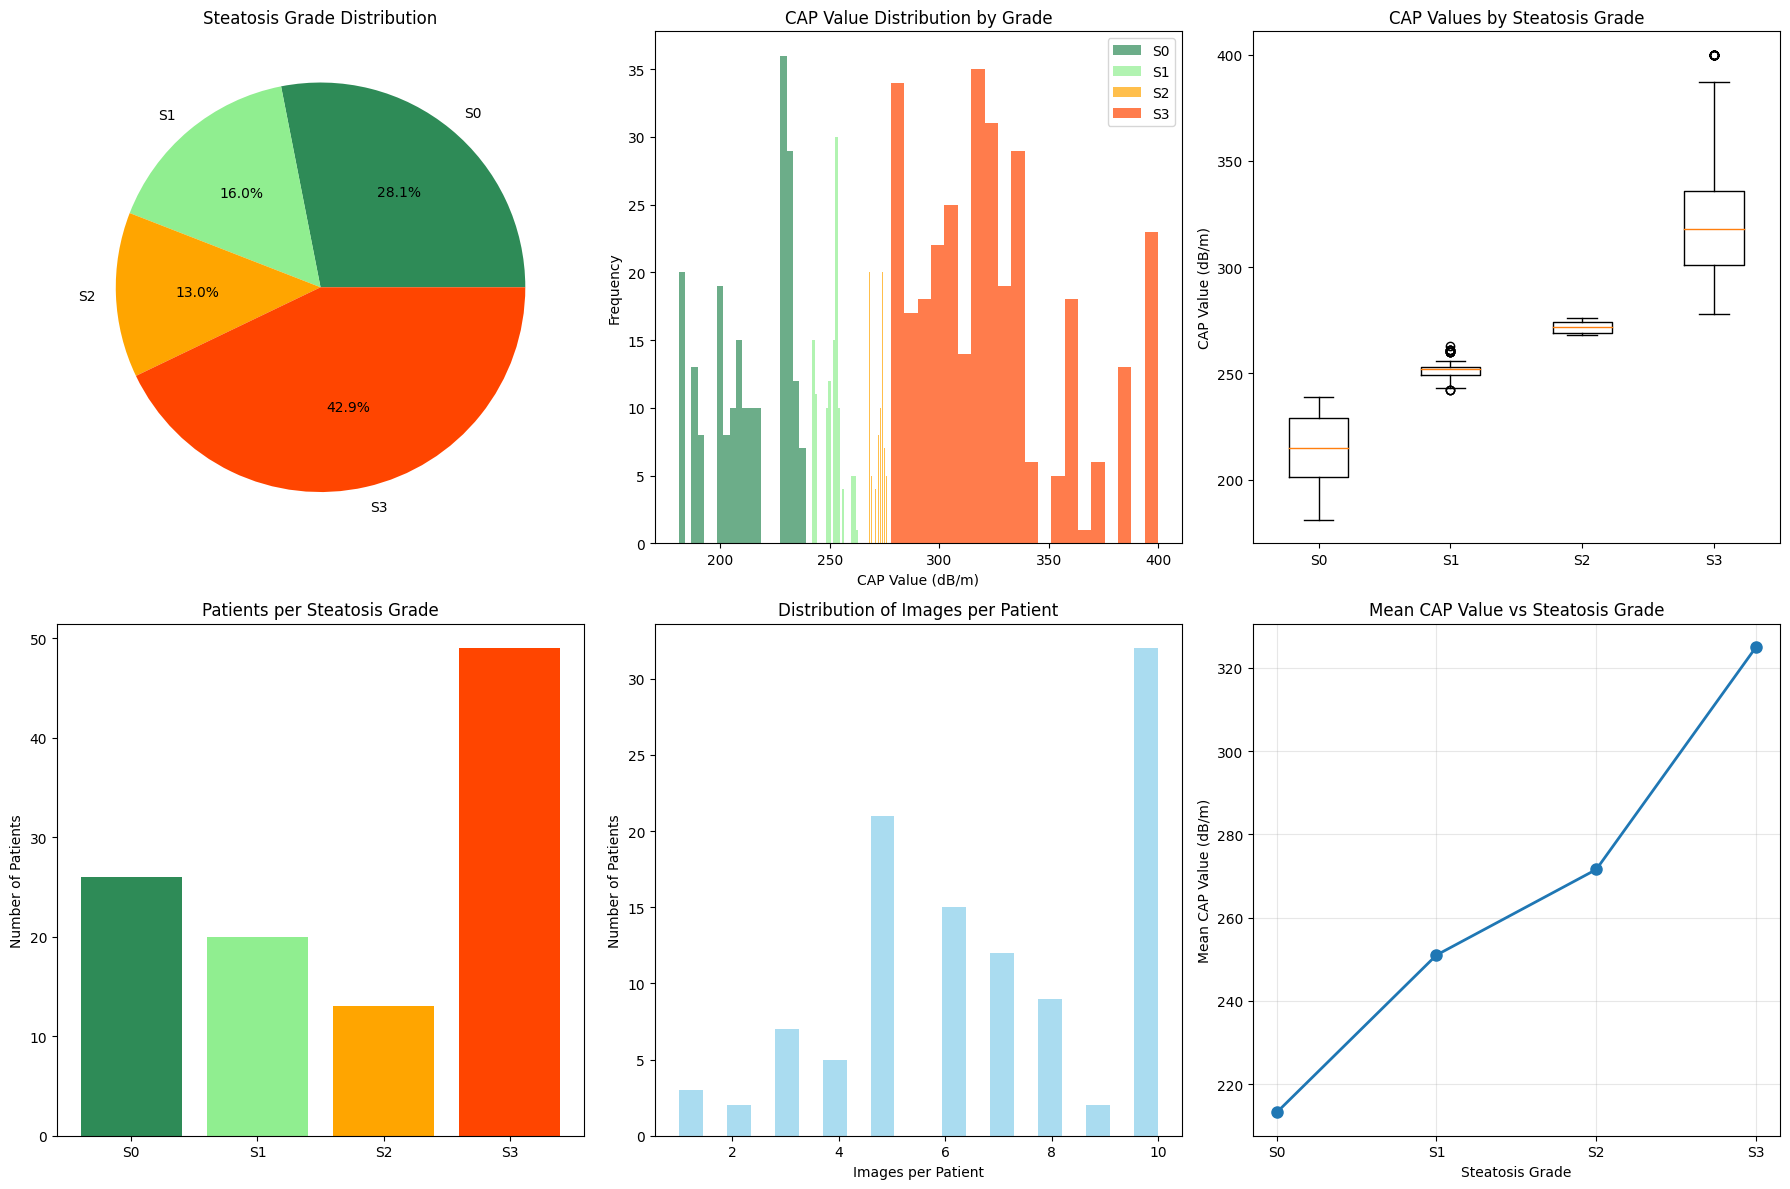

🔀 STEP 3: Creating data splits...

📊 DATA SPLITS (Patient-wise):
✅ Training: 494 samples from 72 patients
✅ Validation: 122 samples from 19 patients
✅ Test: 121 samples from 17 patients

📊 DATA DISTRIBUTION:
✅ Training: 494 samples (70.0%)
📈 Validation: 122 samples (15.0%)
🧪 Test: 121 samples (15.0%)
🤖 STEP 4: Initializing training pipeline...
🔄 STEP 5: Preparing training data...
🔄 Preparing data for training...
✅ Training data: 494 samples
✅ Validation data: 122 samples
✅ Test data: 121 samples
🏗️ STEP 6: Creating model...
✅ Created simple_cnn multi-modal model
🎯 STEP 7: Training with 100 epochs...
⚖️ Class weights for imbalanced dataset:
  S0: 0.89
  S1: 1.56
  S2: 1.92
  S3: 0.58
🚀 Starting 100 Epochs Training...
📊 Phase 1: 30 epochs with frozen base model
Epoch 1/30
31/31 [==============================] - ETA: 0s - loss: 1.4821 - accuracy: 0.2915 - precision: 0.3913 - recall: 0.0547
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_100epoch_pancreas_model.h

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 13s 311ms/step - loss: 1.4821 - accuracy: 0.2915 - precision: 0.3913 - recall: 0.0547 - val_loss: 1.1605 - val_accuracy: 0.5000 - val_precision: 0.9565 - val_recall: 0.1803 - lr: 0.0010
Epoch 2/30
31/31 [==============================] - ETA: 0s - loss: 1.3411 - accuracy: 0.3725 - precision: 0.6250 - recall: 0.1012
Epoch 2: val_accuracy did not improve from 0.50000
31/31 [==============================] - 9s 288ms/step - loss: 1.3411 - accuracy: 0.3725 - precision: 0.6250 - recall: 0.1012 - val_loss: 1.3114 - val_accuracy: 0.3443 - val_precision: 1.0000 - val_recall: 0.0164 - lr: 0.0010
Epoch 3/30
31/31 [==============================] - ETA: 0s - loss: 1.2615 - accuracy: 0.4271 - precision: 0.6529 - recall: 0.1599
Epoch 3: val_accuracy improved from 0.50000 to 0.59836, saving model to best_100epoch_pancreas_model.h5
31/31 [==============================] - 8s 267ms/step - loss: 1.2615 - accuracy: 0.4271 - precision: 0.6529 - recall: 0.1599 - va

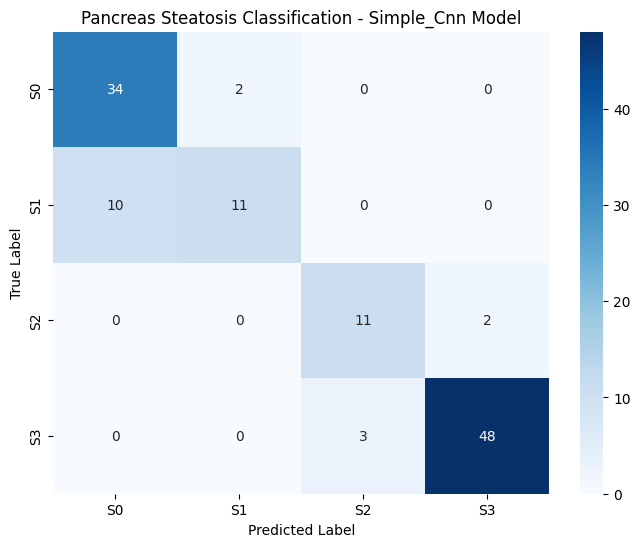

🎯 Test Accuracy: 0.8595
📈 STEP 9: Visualizing 100-epoch training...


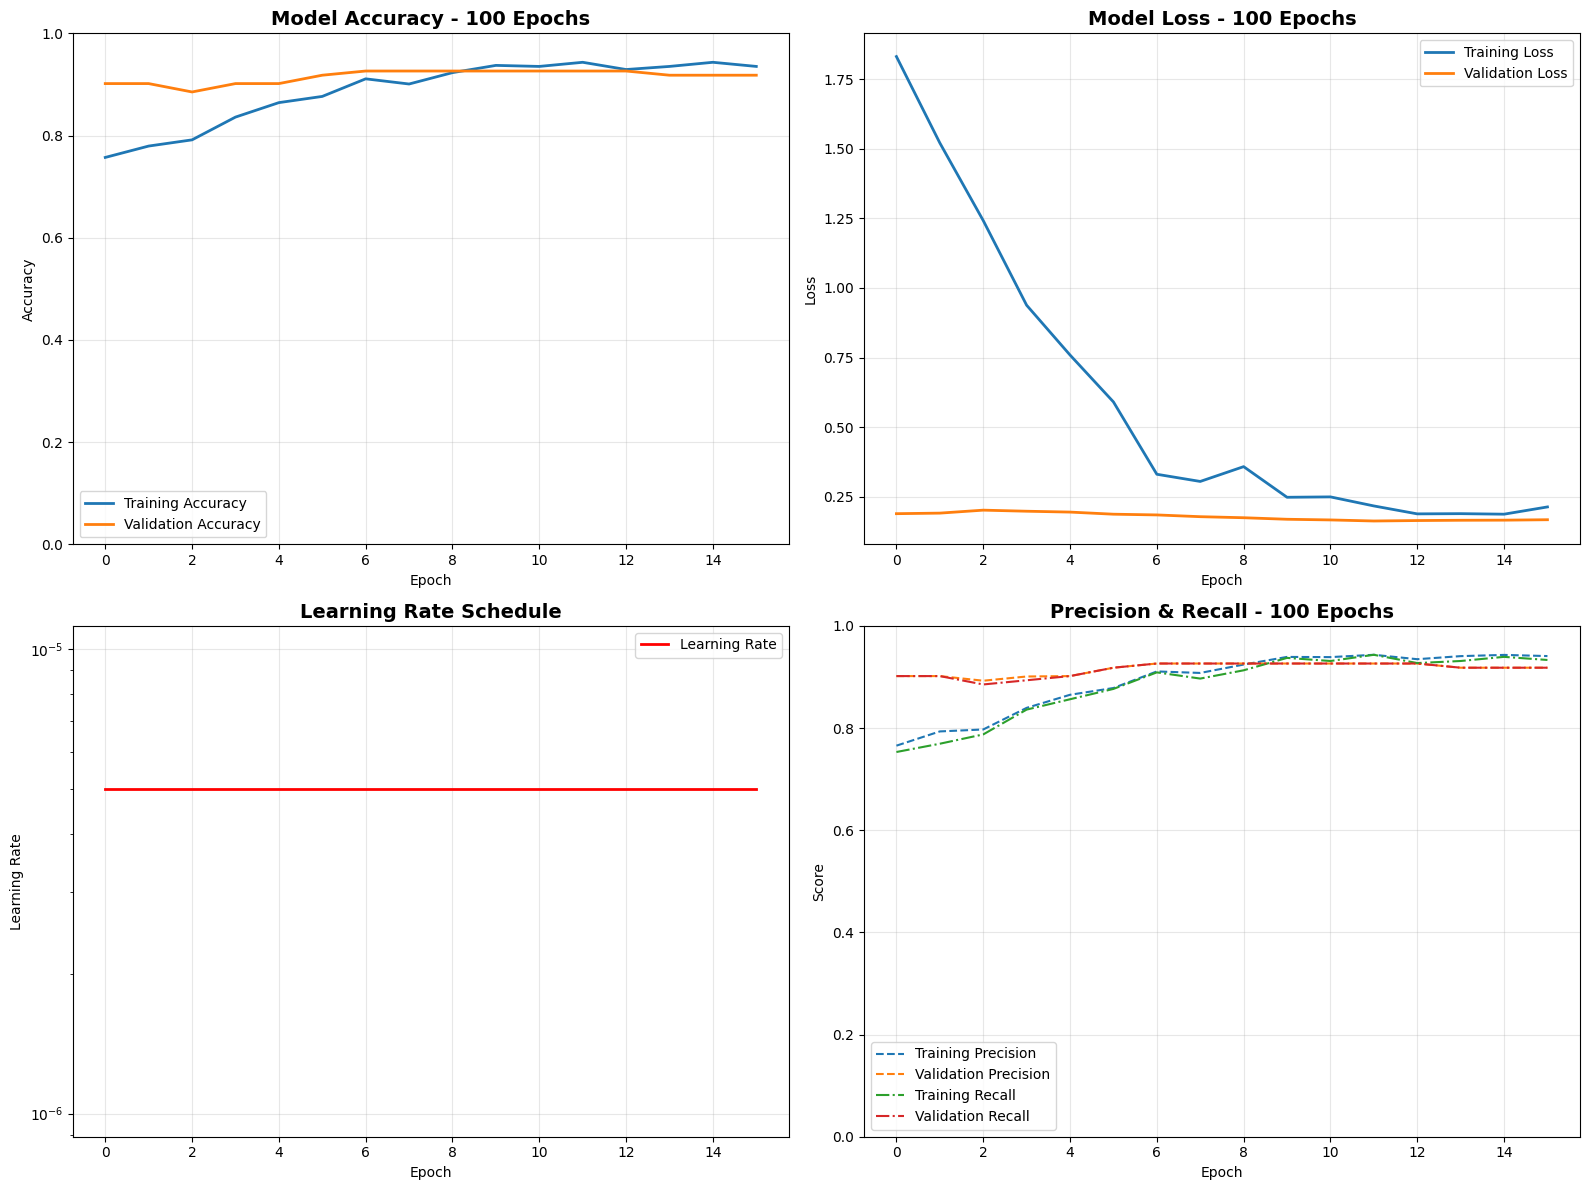

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
100-EPOCH TRAINING COMPLETED SUCCESSFULLY!
🎯 FINAL TEST ACCURACY: 0.8595
⏱️ TOTAL EPOCHS TRAINED: 16
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅ simple_cnn trained successfully: 0.8595

🏆 MODEL COMPARISON RESULTS
          Model Accuracy               Description    Status
efficientnet_b0   0.8512 Lightweight and efficient ✅ Success
efficientnet_b2   0.7851      Balanced performance ✅ Success
       resnet50   0.8430       Proven architecture ✅ Success
     simple_cnn   0.8595    Lightweight custom CNN ✅ Success


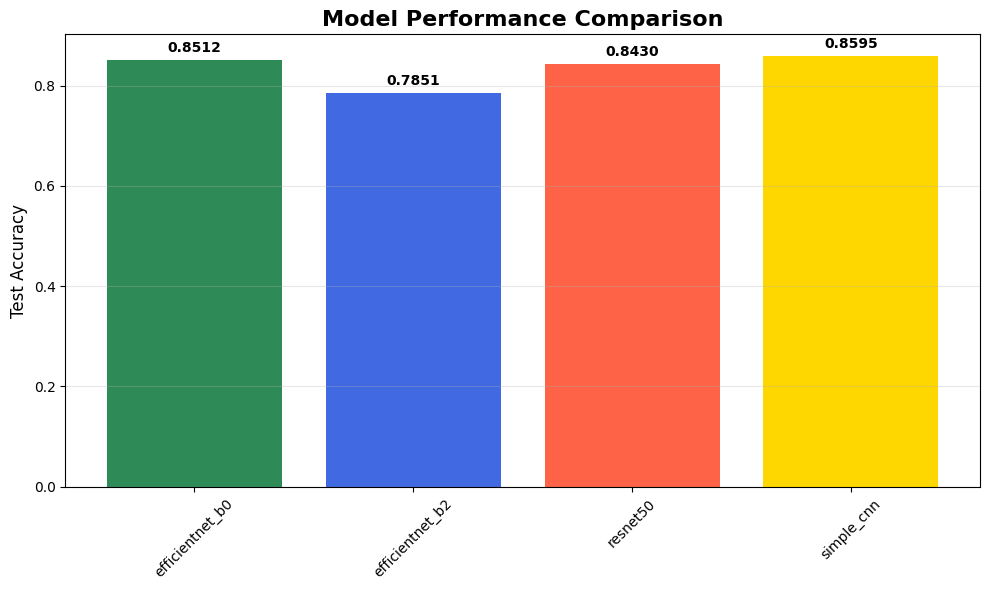


🎯 BEST MODEL: simple_cnn (Accuracy: 0.8595)

⚡ Using Quick Working Comparator...
🧪 TRAINING SIMPLE WORKING MODELS
Loading pancreas elastograms and CAP values...
✅ Loaded CSV with 108 patients
📁 S0: Found 26 patients
📁 S1: Found 20 patients
📁 S2: Found 13 patients
📁 S3: Found 49 patients

📊 DATA INTEGRATION SUMMARY:
✅ Successfully integrated 737 elastograms with CAP values
⚠️ Patients without CAP data: 0
⚠️ Patients without images: 0
🎯 Final dataset size: 737 samples

📊 DATA SPLITS (Patient-wise):
✅ Training: 511 samples from 74 patients
✅ Validation: 105 samples from 17 patients
✅ Test: 121 samples from 17 patients

🚀 Training mobile_net: MobileNetV2 - Fast and efficient
Epoch 1/20
32/32 [==============================] - 12s 292ms/step - loss: 1.3134 - accuracy: 0.4051 - val_loss: 1.0147 - val_accuracy: 0.5429
Epoch 2/20
32/32 [==============================] - 8s 254ms/step - loss: 1.0586 - accuracy: 0.5166 - val_loss: 1.0006 - val_accuracy: 0.5238
Epoch 3/20
32/32 [================

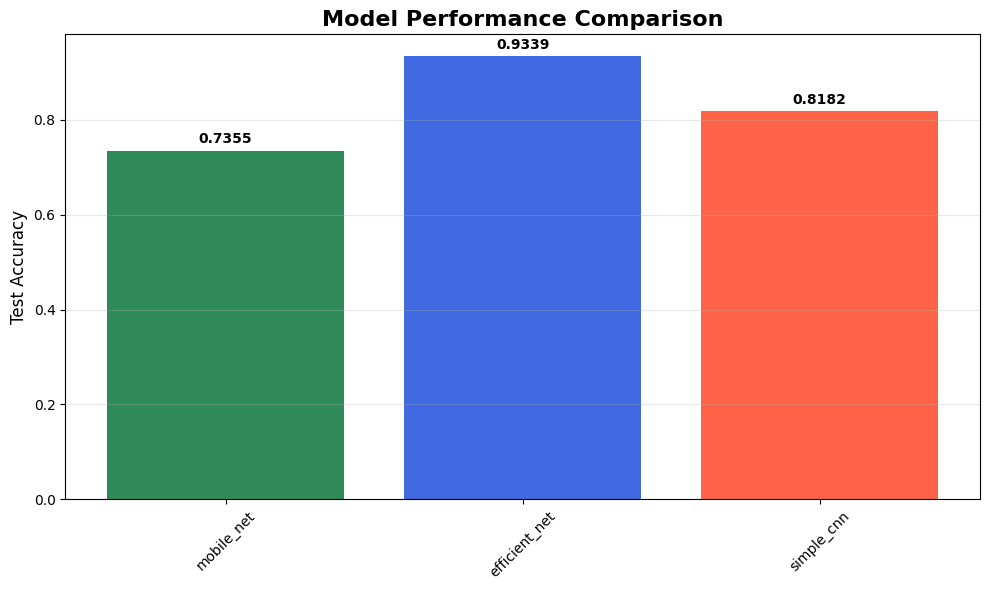


🎯 BEST MODEL: efficient_net (Accuracy: 0.9339)


In [30]:
# Option 1: Use the fixed comparator (recommended)
print("🔧 Using Fixed Model Comparator...")
fixed_comparator = FixedModelComparator(scans_base_path, csv_path)
comparison_results = fixed_comparator.train_multiple_models()
best_model_info = fixed_comparator.compare_models()

# Option 2: Use the quick working comparator (guaranteed to work)
print("\n⚡ Using Quick Working Comparator...")
quick_comparator = QuickWorkingComparator(scans_base_path, csv_path)
quick_results = quick_comparator.train_simple_models()
quick_best = quick_comparator.compare_models()

# 3. Advanced Model Architectures to Try


In [31]:
def create_advanced_models():
    """Create more advanced model architectures"""
    
    # 1. Ensemble Model
    def create_ensemble_model(input_shape=(224, 224, 3), num_classes=4):
        """Create ensemble of multiple architectures"""
        # Multiple input branches
        image_input = keras.layers.Input(shape=input_shape, name='image_input')
        
        # Branch 1: EfficientNet
        effnet = keras.applications.EfficientNetB0(
            include_top=False, weights='imagenet', input_tensor=image_input, pooling='avg'
        )
        effnet_features = keras.layers.Dense(128, activation='relu')(effnet.output)
        
        # Branch 2: ResNet
        resnet = keras.applications.ResNet50(
            include_top=False, weights='imagenet', input_tensor=image_input, pooling='avg'
        )
        resnet_features = keras.layers.Dense(128, activation='relu')(resnet.output)
        
        # CAP branch
        cap_input = keras.layers.Input(shape=(1,), name='cap_input')
        cap_branch = keras.layers.Dense(32, activation='relu')(cap_input)
        
        # Combine all branches
        combined = keras.layers.concatenate([effnet_features, resnet_features, cap_branch])
        
        # Classification
        output = keras.layers.Dense(num_classes, activation='softmax')(combined)
        
        model = keras.Model(
            inputs=[image_input, cap_input],
            outputs=output,
            name='ensemble_model'
        )
        
        return model
    
    # 2. Attention-based Model
    def create_attention_model(input_shape=(224, 224, 3), num_classes=4):
        """Create model with spatial attention"""
        image_input = keras.layers.Input(shape=input_shape, name='image_input')
        
        base_model = keras.applications.EfficientNetB0(
            include_top=False, weights='imagenet', input_tensor=image_input
        )
        
        # Add spatial attention
        conv_features = base_model.output
        attention = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv_features)
        attended_features = keras.layers.multiply([conv_features, attention])
        
        # Global pooling
        pooled = keras.layers.GlobalAveragePooling2D()(attended_features)
        
        # CAP branch
        cap_input = keras.layers.Input(shape=(1,), name='cap_input')
        cap_processed = keras.layers.Dense(32, activation='relu')(cap_input)
        
        # Combine
        combined = keras.layers.concatenate([pooled, cap_processed])
        
        # Output
        output = keras.layers.Dense(num_classes, activation='softmax')(combined)
        
        model = keras.Model(
            inputs=[image_input, cap_input],
            outputs=output,
            name='attention_model'
        )
        
        return model
    
    return {
        'ensemble': create_ensemble_model,
        'attention': create_attention_model
    }

# Try advanced models
advanced_models = create_advanced_models()

# 4. Hyperparameter Optimization


Starting hyperparameter optimization...
🔧 OPTIMIZING LEARNING RATES
📊 Loading data...
Loading pancreas elastograms and CAP values...
✅ Loaded CSV with 108 patients
📁 S0: Found 26 patients
📁 S1: Found 20 patients
📁 S2: Found 13 patients
📁 S3: Found 49 patients

📊 DATA INTEGRATION SUMMARY:
✅ Successfully integrated 737 elastograms with CAP values
⚠️ Patients without CAP data: 0
⚠️ Patients without images: 0
🎯 Final dataset size: 737 samples

📊 DATA SPLITS (Patient-wise):
✅ Training: 511 samples from 74 patients
✅ Validation: 105 samples from 17 patients
✅ Test: 121 samples from 17 patients

🧪 Testing learning rate: 0.001
🔄 Preparing data for training...
✅ Training data: 511 samples
✅ Validation data: 105 samples
✅ Test data: 121 samples
Base model feature dimension: 1280
Combined features dimension: 144
✅ Created improved multi-modal model
📊 Training with LR 0.001 for 15 epochs...
❌ LR 0.001 failed: in user code:

    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/trainin

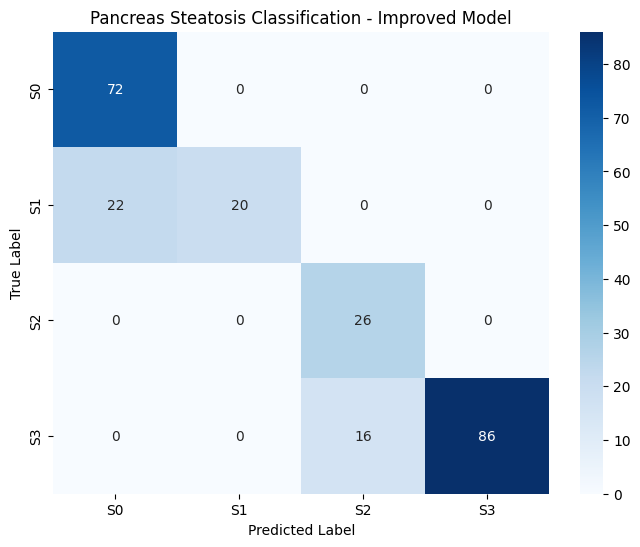

🎯 Test Accuracy: 0.8430
✅ Batch Size 8: Accuracy = 0.8430

🧪 Testing batch size: 16
🔄 Preparing data for training...
✅ Training data: 1022 samples
✅ Validation data: 210 samples
✅ Test data: 242 samples
Base model feature dimension: 1280
Combined features dimension: 144
✅ Created improved multi-modal model
📊 Training with batch size 16...
📊 Evaluating model on test set...
8/8 [==============================] - 10s 976ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

          S0       0.77      1.00      0.87        72
          S1       1.00      0.48      0.65        42
          S2       0.45      1.00      0.62        26
          S3       1.00      0.69      0.81       102

    accuracy                           0.78       242
   macro avg       0.80      0.79      0.74       242
weighted avg       0.87      0.78      0.78       242



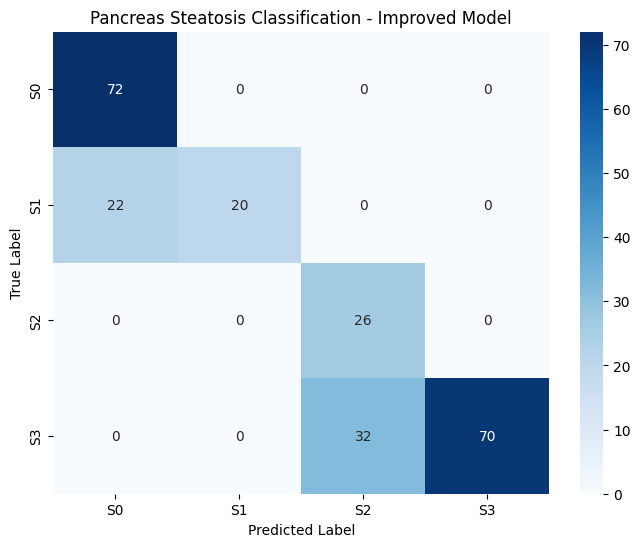

🎯 Test Accuracy: 0.7769
✅ Batch Size 16: Accuracy = 0.7769

🧪 Testing batch size: 32
🔄 Preparing data for training...
✅ Training data: 1022 samples
✅ Validation data: 210 samples
✅ Test data: 242 samples
Base model feature dimension: 1280
Combined features dimension: 144
✅ Created improved multi-modal model
📊 Training with batch size 32...
📊 Evaluating model on test set...
8/8 [==============================] - 9s 966ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

          S0       1.00      1.00      1.00        72
          S1       1.00      1.00      1.00        42
          S2       1.00      1.00      1.00        26
          S3       1.00      1.00      1.00       102

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242



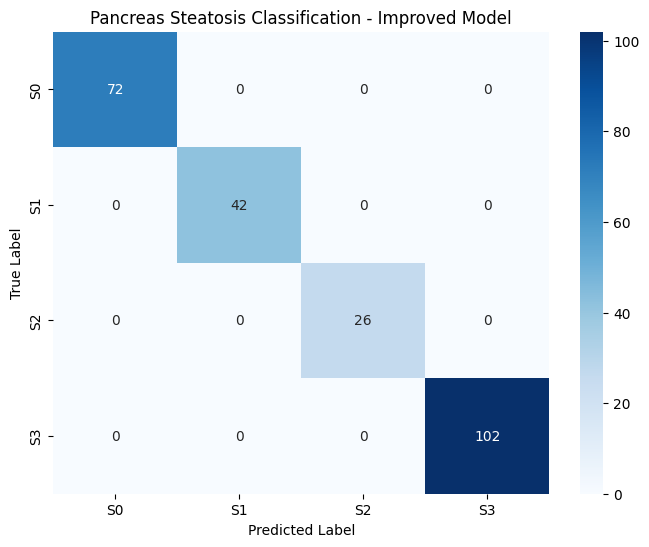

🎯 Test Accuracy: 1.0000
✅ Batch Size 32: Accuracy = 1.0000

🎯 BEST BATCH SIZE: 32 (Accuracy: 1.0000)

🎯 OPTIMIZATION COMPLETE!
Best Learning Rate: 0.001
Best Batch Size: 32


In [32]:
class FixedHyperparameterOptimizer:
    def __init__(self, scans_base_path, csv_path):
        self.scans_base_path = scans_base_path
        self.csv_path = csv_path
        self.best_params = {}
        self.data_integrator = ImprovedPancreasDataIntegrator(scans_base_path, csv_path)
        
    def optimize_learning_rates(self, learning_rates=[0.001, 0.0005, 0.0001, 0.00005]):
        """Test different learning rates with proper initialization"""
        results = {}
        
        print("🔧 OPTIMIZING LEARNING RATES")
        print("=" * 40)
        
        # Load data once (outside the loop for efficiency)
        print("📊 Loading data...")
        combined_data = self.data_integrator.load_and_integrate_data(load_images_into_memory=True)
        train_data, val_data, test_data = self.data_integrator.create_train_val_test_split()
        
        for lr in learning_rates:
            print(f"\n🧪 Testing learning rate: {lr}")
            
            try:
                # Create fresh training pipeline for each learning rate
                pipeline = EnhancedMultimodalTrainingPipeline(self.data_integrator, 'improved')
                
                # Prepare data
                training_data = pipeline.prepare_data(train_data, val_data, test_data)
                
                # Create model
                pipeline.create_model()
                
                # Recompile with specific learning rate
                pipeline.model.compile(
                    optimizer=keras.optimizers.Adam(learning_rate=lr),
                    loss='categorical_crossentropy',
                    metrics=['accuracy', 'precision', 'recall']
                )
                
                # Short training for optimization (reduced epochs)
                print(f"📊 Training with LR {lr} for 15 epochs...")
                history = pipeline.model.fit(
                    [training_data[0], training_data[1]], training_data[2],
                    batch_size=16,
                    epochs=15,  # Reduced for faster optimization
                    validation_data=([training_data[3], training_data[4]], training_data[5]),
                    verbose=0  # Silent training for optimization
                )
                
                # Evaluate
                accuracy, _ = pipeline.evaluate_model(training_data)
                results[lr] = accuracy
                print(f"✅ LR {lr}: Accuracy = {accuracy:.4f}")
                
                # Clear session to free memory
                keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ LR {lr} failed: {e}")
                continue
        
        if results:
            # Find best learning rate
            best_lr = max(results.items(), key=lambda x: x[1])
            self.best_params['learning_rate'] = best_lr[0]
            
            print(f"\n🎯 BEST LEARNING RATE: {best_lr[0]} (Accuracy: {best_lr[1]:.4f})")
            
            # Plot results
            self.plot_learning_rate_results(results)
        else:
            print("❌ No learning rates successfully trained. Using default: 0.001")
            self.best_params['learning_rate'] = 0.001
            
        return results
    
    def plot_learning_rate_results(self, results):
        """Plot learning rate optimization results"""
        lrs = list(results.keys())
        accuracies = list(results.values())
        
        plt.figure(figsize=(10, 6))
        plt.semilogx(lrs, accuracies, 'o-', linewidth=2, markersize=8)
        plt.title('Learning Rate Optimization', fontsize=16, fontweight='bold')
        plt.xlabel('Learning Rate', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Highlight best result
        best_lr = max(results.items(), key=lambda x: x[1])
        plt.axvline(x=best_lr[0], color='red', linestyle='--', alpha=0.7, label=f'Best LR: {best_lr[0]}')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def optimize_batch_sizes(self, batch_sizes=[8, 16, 32]):
        """Optimize batch sizes"""
        results = {}
        
        print("\n🔧 OPTIMIZING BATCH SIZES")
        print("=" * 40)
        
        # Load data
        combined_data = self.data_integrator.load_and_integrate_data(load_images_into_memory=True)
        train_data, val_data, test_data = self.data_integrator.create_train_val_test_split()
        
        for batch_size in batch_sizes:
            print(f"\n🧪 Testing batch size: {batch_size}")
            
            try:
                pipeline = EnhancedMultimodalTrainingPipeline(self.data_integrator, 'improved')
                training_data = pipeline.prepare_data(train_data, val_data, test_data)
                pipeline.create_model()
                
                # Use best learning rate or default
                best_lr = self.best_params.get('learning_rate', 0.001)
                pipeline.model.compile(
                    optimizer=keras.optimizers.Adam(learning_rate=best_lr),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )
                
                # Short training
                print(f"📊 Training with batch size {batch_size}...")
                history = pipeline.model.fit(
                    [training_data[0], training_data[1]], training_data[2],
                    batch_size=batch_size,
                    epochs=10,  # Very short for optimization
                    validation_data=([training_data[3], training_data[4]], training_data[5]),
                    verbose=0
                )
                
                accuracy, _ = pipeline.evaluate_model(training_data)
                results[batch_size] = accuracy
                print(f"✅ Batch Size {batch_size}: Accuracy = {accuracy:.4f}")
                
                keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Batch size {batch_size} failed: {e}")
                continue
        
        if results:
            best_batch = max(results.items(), key=lambda x: x[1])
            self.best_params['batch_size'] = best_batch[0]
            print(f"\n🎯 BEST BATCH SIZE: {best_batch[0]} (Accuracy: {best_batch[1]:.4f})")
        else:
            print("❌ No batch sizes successfully trained. Using default: 16")
            self.best_params['batch_size'] = 16
            
        return results

# Run fixed optimization
print("Starting hyperparameter optimization...")
optimizer = FixedHyperparameterOptimizer(scans_base_path, csv_path)
lr_results = optimizer.optimize_learning_rates()
batch_results = optimizer.optimize_batch_sizes()

print(f"\n🎯 OPTIMIZATION COMPLETE!")
print(f"Best Learning Rate: {optimizer.best_params.get('learning_rate', 'Not found')}")
print(f"Best Batch Size: {optimizer.best_params.get('batch_size', 'Not found')}")